In [30]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata, zscore
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
import warnings
from adjustText import adjust_text




# settings
plt.rc('font', size = 14)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
scv.settings.n_jobs=-1
sns.set_style("ticks")


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [31]:
# utils
def marker_check(markers, AnnData, verbose=True):
    """Check that the maker annotation is in the dataset
    
    TODO (before distribution): use ensembl ids instead of names
    
    Arguments:
        markers (dict): keys=cell type, values are markers associated
    """
    missing = {}
    for k,v in markers.items():
        missing_genes = []
        for g in v:
            if g not in AnnData.var_names:
                missing_genes.append(g)
        if len(missing_genes) != 0:
            missing[k] = missing_genes
    
    if verbose:
        for ctype in missing.keys():
            print('{} has missing genes:'.format(ctype))
            for g in missing[ctype]:
                print('  {}'.format(g))
    if len(missing) == 0:
        print('All markers in data.')
    if not verbose:
        return missing
    else:
        return None
    
def mwu(X,Y,gene_names,correction=None,debug=False,verbose=False) :
    '''
    Benjamini-Hochberg correction implemented. Can change to Bonferonni

    gene_names (list)
    if X,Y single gene expression array, input x.reshape(-1,1), y.reshape(-1,1)

    NOTE: get zeros sometimes because difference (p-value is so small)
    '''
    p=pd.DataFrame()
    print('starting Mann-Whitney U w/Benjamini/Hochberg correction...\n')
    start = time.time()
    for i,g in enumerate(gene_names) :
        if i==np.round(np.quantile(np.arange(len(gene_names)),0.25)) :
            print('... 25% completed in {:.2f}-s'.format(time.time()-start))
        elif i==np.round(np.quantile(np.arange(len(gene_names)),0.5)) :
            print('... 50% completed in {:.2f}-s'.format(time.time()-start))
        elif i==np.round(np.quantile(np.arange(len(gene_names)),0.75)) :
            print('... 75% completed in {:.2f}-s'.format(time.time()-start))
        p.loc[i,'Gene']=g
        if (tiecorrect(rankdata(np.concatenate((np.asarray(X[:,i]),np.asarray(Y[:,i])))))==0) :
            if debug :
                print('P-value not calculable for {}'.format(g))
            p.loc[i,'pval']=np.nan
        else :
            _,p.loc[i,'pval']=mannwhitneyu(X[:,i],Y[:,i]) # continuity correction is True
    print('\n... mwu computed in {:.2f}-s\n'.format(time.time() - start))
    if True :
        # ignore NaNs, since can't do a comparison on these (change numbers for correction)
        p_corrected = p.loc[p['pval'].notna(),:]
        if p['pval'].isna().any():
            if verbose:
                print('Following genes had NA p-val:')
                for gene in p['Gene'][p['pval'].isna()]:
                    print('  %s' % gene)
    else : 
        p_corrected = p
    new_pvals = multipletests(p_corrected['pval'],method='fdr_bh')
    p_corrected['pval_corrected'] = new_pvals[1]
    return p_corrected

def log2aveFC(X,Y,gene_names,AnnData=None) :
    '''not sensitivity to directionality due to subtraction

    X and Y full arrays, subsetting performed here

    `gene_names` (list): reduced list of genes to calc

    `adata` (sc.AnnData): to calculate reduced list. NOTE: assumes X,Y drawn from adata.var_names
    '''
    if not AnnData is None :
        g_idx = [i for i,g in enumerate(AnnData.var_names) if g in gene_names]
        fc=pd.DataFrame({'Gene':AnnData.var_names[g_idx],
                         'log2FC':np.log2(X[:,g_idx].mean(axis=0)) - np.log2(Y[:,g_idx].mean(axis=0))}) # returns NaN if negative value 
    else :
        fc=pd.DataFrame({'Gene':gene_names,
                         'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
    return fc

In [32]:

# fps
dfp = '/home/ngr4/project/sccovid/data/'
pfp = '/home/ngr4/project/sccovid/results/'
pdfp = '/home/ngr4/project/sccovid/data/processed/'
sc.settings.figdir = pfp
scv.settings.figdir = pfp


def loader(fname,fpath,backed=None) : 
    start = time.time()
    adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    AnnData.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))
    

if False :
    # load personal
    fname='scv2_200428.h5ad'
    %memit hdata = loader(fname,pdfp)

if False :
    pdfp = '/home/ngr4/project/covid_lung/data/processed'
    fname='liao2020.h5ad'
    %memit ldata = loader(fname,pdfp)
    
if True :
    pdfp = '/home/ngr4/project/covid_lung/data/processed'
    fname='covid3balfs.h5ad'
    %memit rpdata = loader(fname,pdfp)

loaded @200624.15:30:22
took 0.96-s to load data
peak memory: 19695.45 MiB, increment: 367.01 MiB


## Overview of data 

Subset to just patient 1 + CTRL

In [33]:
rpdata.obs['scv2_geq1'] = np.asarray(rpdata.raw[:,'scv2_orf1-10'].X.todense()).flatten()>=1
rpdata.obs['init_ctype'] = rpdata.obs['init_ctype'].astype(str)
rpdata.obs.loc[rpdata.obs['init_ctype']=='Tcell', 'init_ctype'] = 'T cells'
rpdata.obs.loc[rpdata.obs['init_ctype']=='Epithelial', 'init_ctype'] = 'Other epithelial'
rpdata.obs['init_ctype'] = rpdata.obs['init_ctype'].astype('category')
adata = sc.AnnData(X=rpdata[(rpdata.obs['Condition']=='CTRL')|
                            (rpdata.obs['Condition']=='Extubated Pt 1')|
                            (rpdata.obs['Condition']=='Intubated Pt 1'), :].X,
                   obs=rpdata[(rpdata.obs['Condition']=='CTRL')|
                            (rpdata.obs['Condition']=='Extubated Pt 1')|
                            (rpdata.obs['Condition']=='Intubated Pt 1'), :].obs,
                   var=rpdata[(rpdata.obs['Condition']=='CTRL')|
                            (rpdata.obs['Condition']=='Extubated Pt 1')|
                            (rpdata.obs['Condition']=='Intubated Pt 1'), :].var)
# adata.obs['Condition'] = adata.obs['Condition'].astype(str)
# adata.obs.loc[adata.obs['Condition']=='Intubated Pt 1','Condition'] = 'Intubated'
# adata.obs.loc[adata.obs['Condition']=='Extubated Pt 1','Condition'] = 'Extubated'

In [34]:
# re-calculate umap
sc.tl.pca(adata)
sc.external.pp.bbknn(adata, neighbors_within_batch=5)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:10)
computing batch balanced neighbors
	finished (0:00:03)
computing UMAP
    finished (0:00:25)


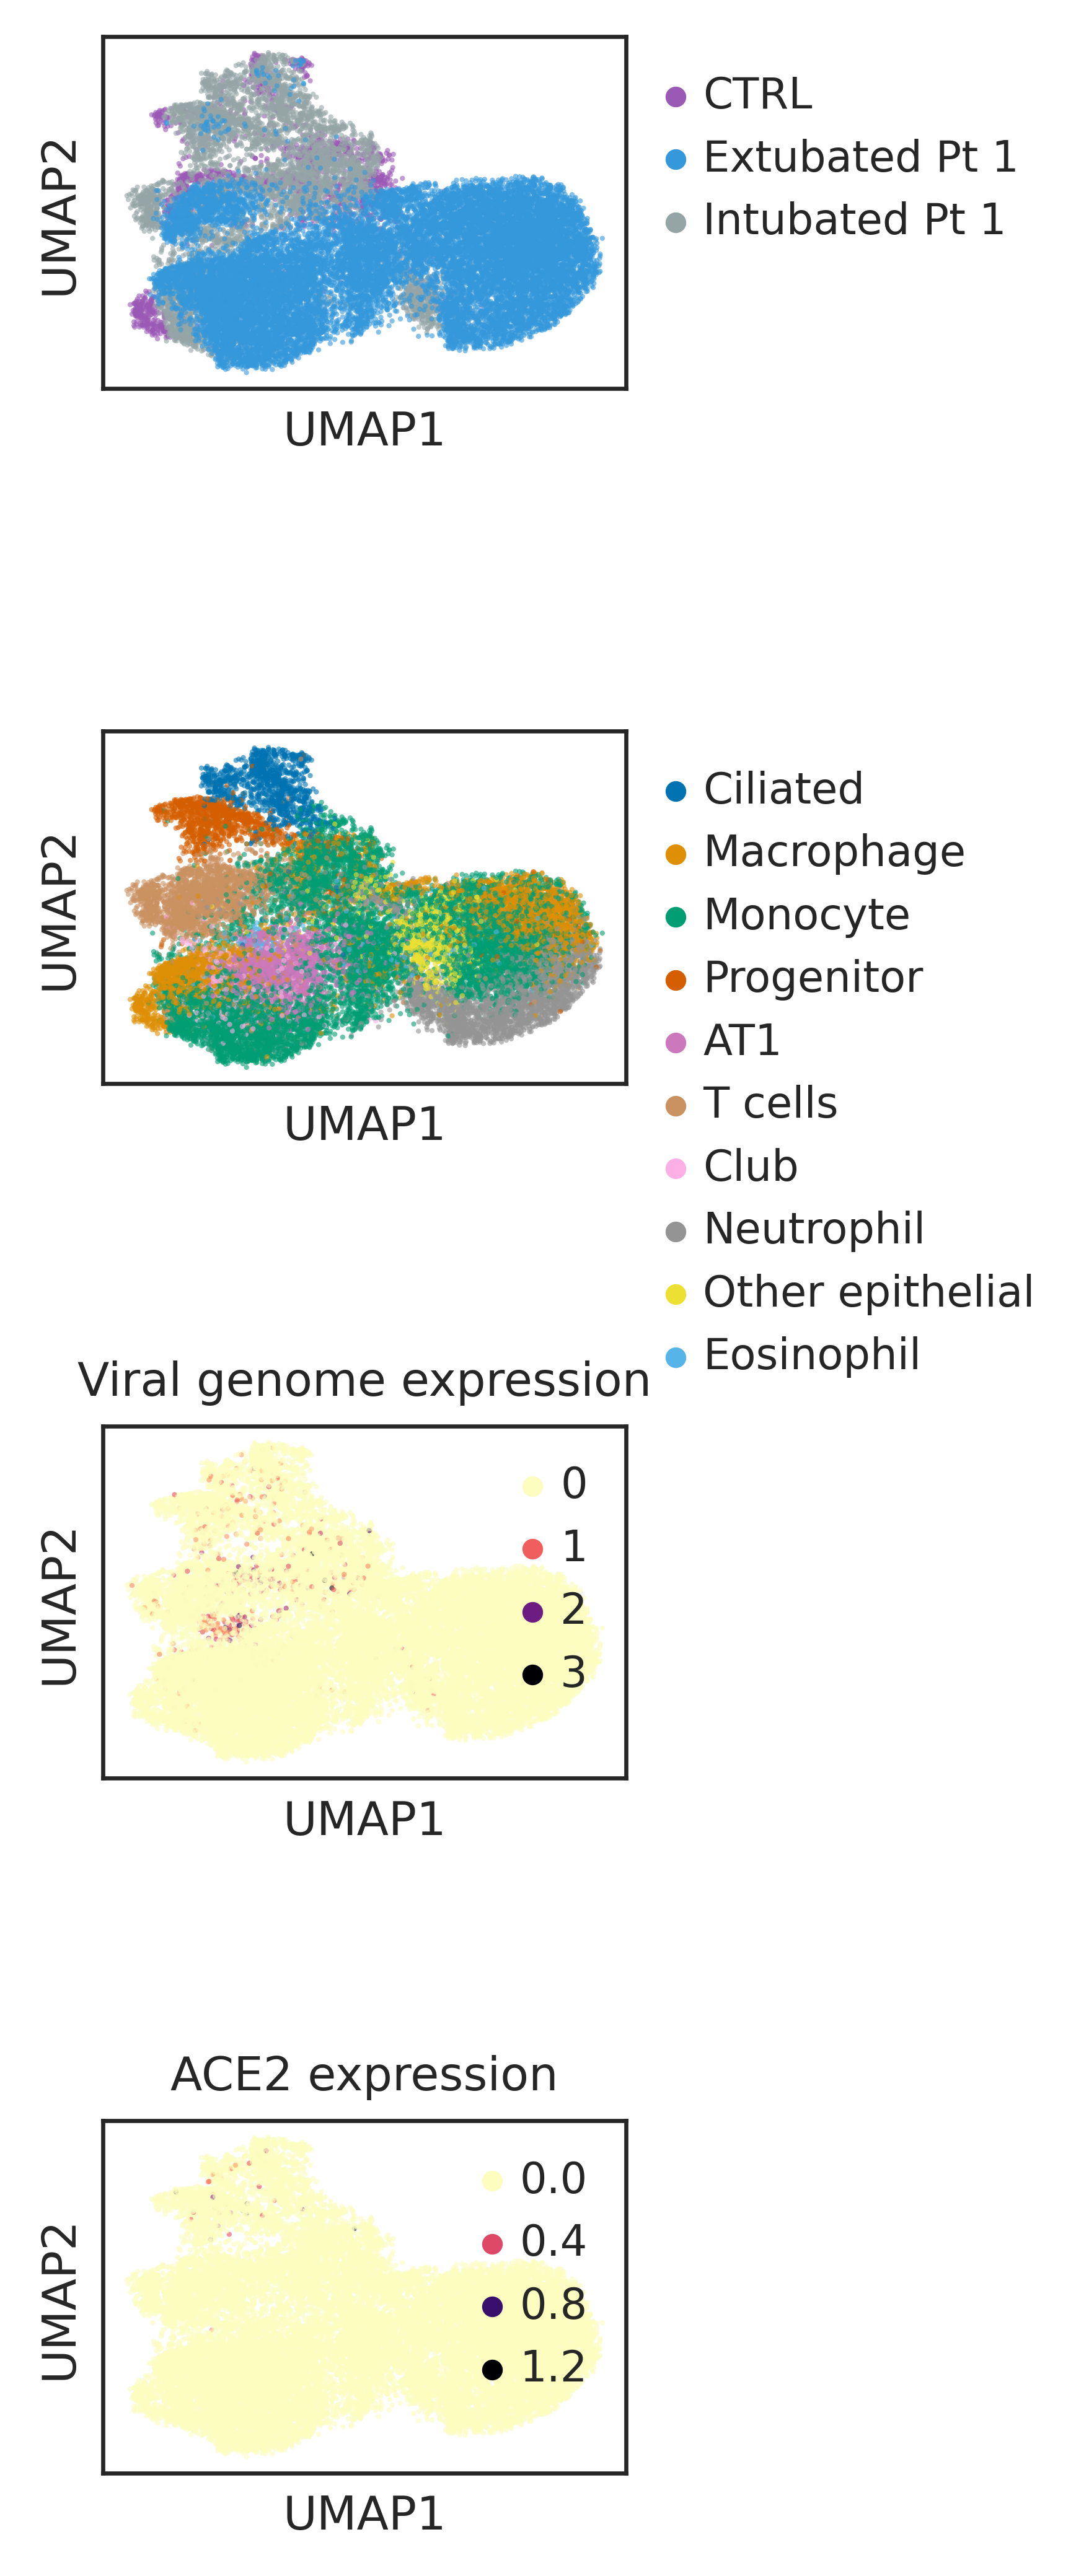

In [47]:
# aesthetics
order = ['CTRL', 'Extubated Pt 1', 'Intubated Pt 1']
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
pal = sns.color_palette(flatui)

# sample
fig,ax = plt.subplots(4,1,figsize=(3,7))
sns.scatterplot(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    hue=adata.obs['Condition'].to_list(),
    palette=pal[0:3],
    hue_order=order,
    alpha=0.6,
    ax=ax[0],
    linewidth=0, 
    s=1, 
    rasterized=True
)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].legend(bbox_to_anchor=(1,1))

ax[0].legend(bbox_to_anchor=(1,1))

# cell type
sns.scatterplot(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    hue=adata.obs['init_ctype'].to_list(),
    palette=sns.color_palette('colorblind'),
#     hue_order=order,
    alpha=0.6,
    ax=ax[1],
    linewidth=0, 
    s=1, 
    rasterized=True
)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].legend(bbox_to_anchor=(1,1))


# select genes
sns.scatterplot(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    hue=np.asarray(adata[:,'scv2_orf1-10'].X.todense()).flatten(),
    palette='magma_r',
    alpha=0.6,
    ax=ax[2],
    linewidth=0, 
    s=1, 
    rasterized=True
)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Viral genome expression')


sns.scatterplot(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    hue=np.asarray(adata[:,'ACE2'].X.todense()).flatten(),
    palette='magma_r',
    alpha=0.6,
    ax=ax[3],
    linewidth=0, 
    s=1,
    rasterized=True
)
ax[3].set_yticks([])
ax[3].set_xticks([])
ax[3].set_xlabel('UMAP1')
ax[3].set_ylabel('UMAP2')
ax[3].set_title('ACE2 expression')
fig.tight_layout()
fig.savefig(os.path.join(pfp,'embeddings_2balfs.pdf'),bbox_inches='tight',dpi=600)

In [35]:
order = ['CTRL', 'Extubated Pt 1', 'Intubated Pt 1']
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
pal = sns.color_palette(flatui)

In [36]:
cmap_condition = {v:pal[i] for i,v in enumerate(order)}


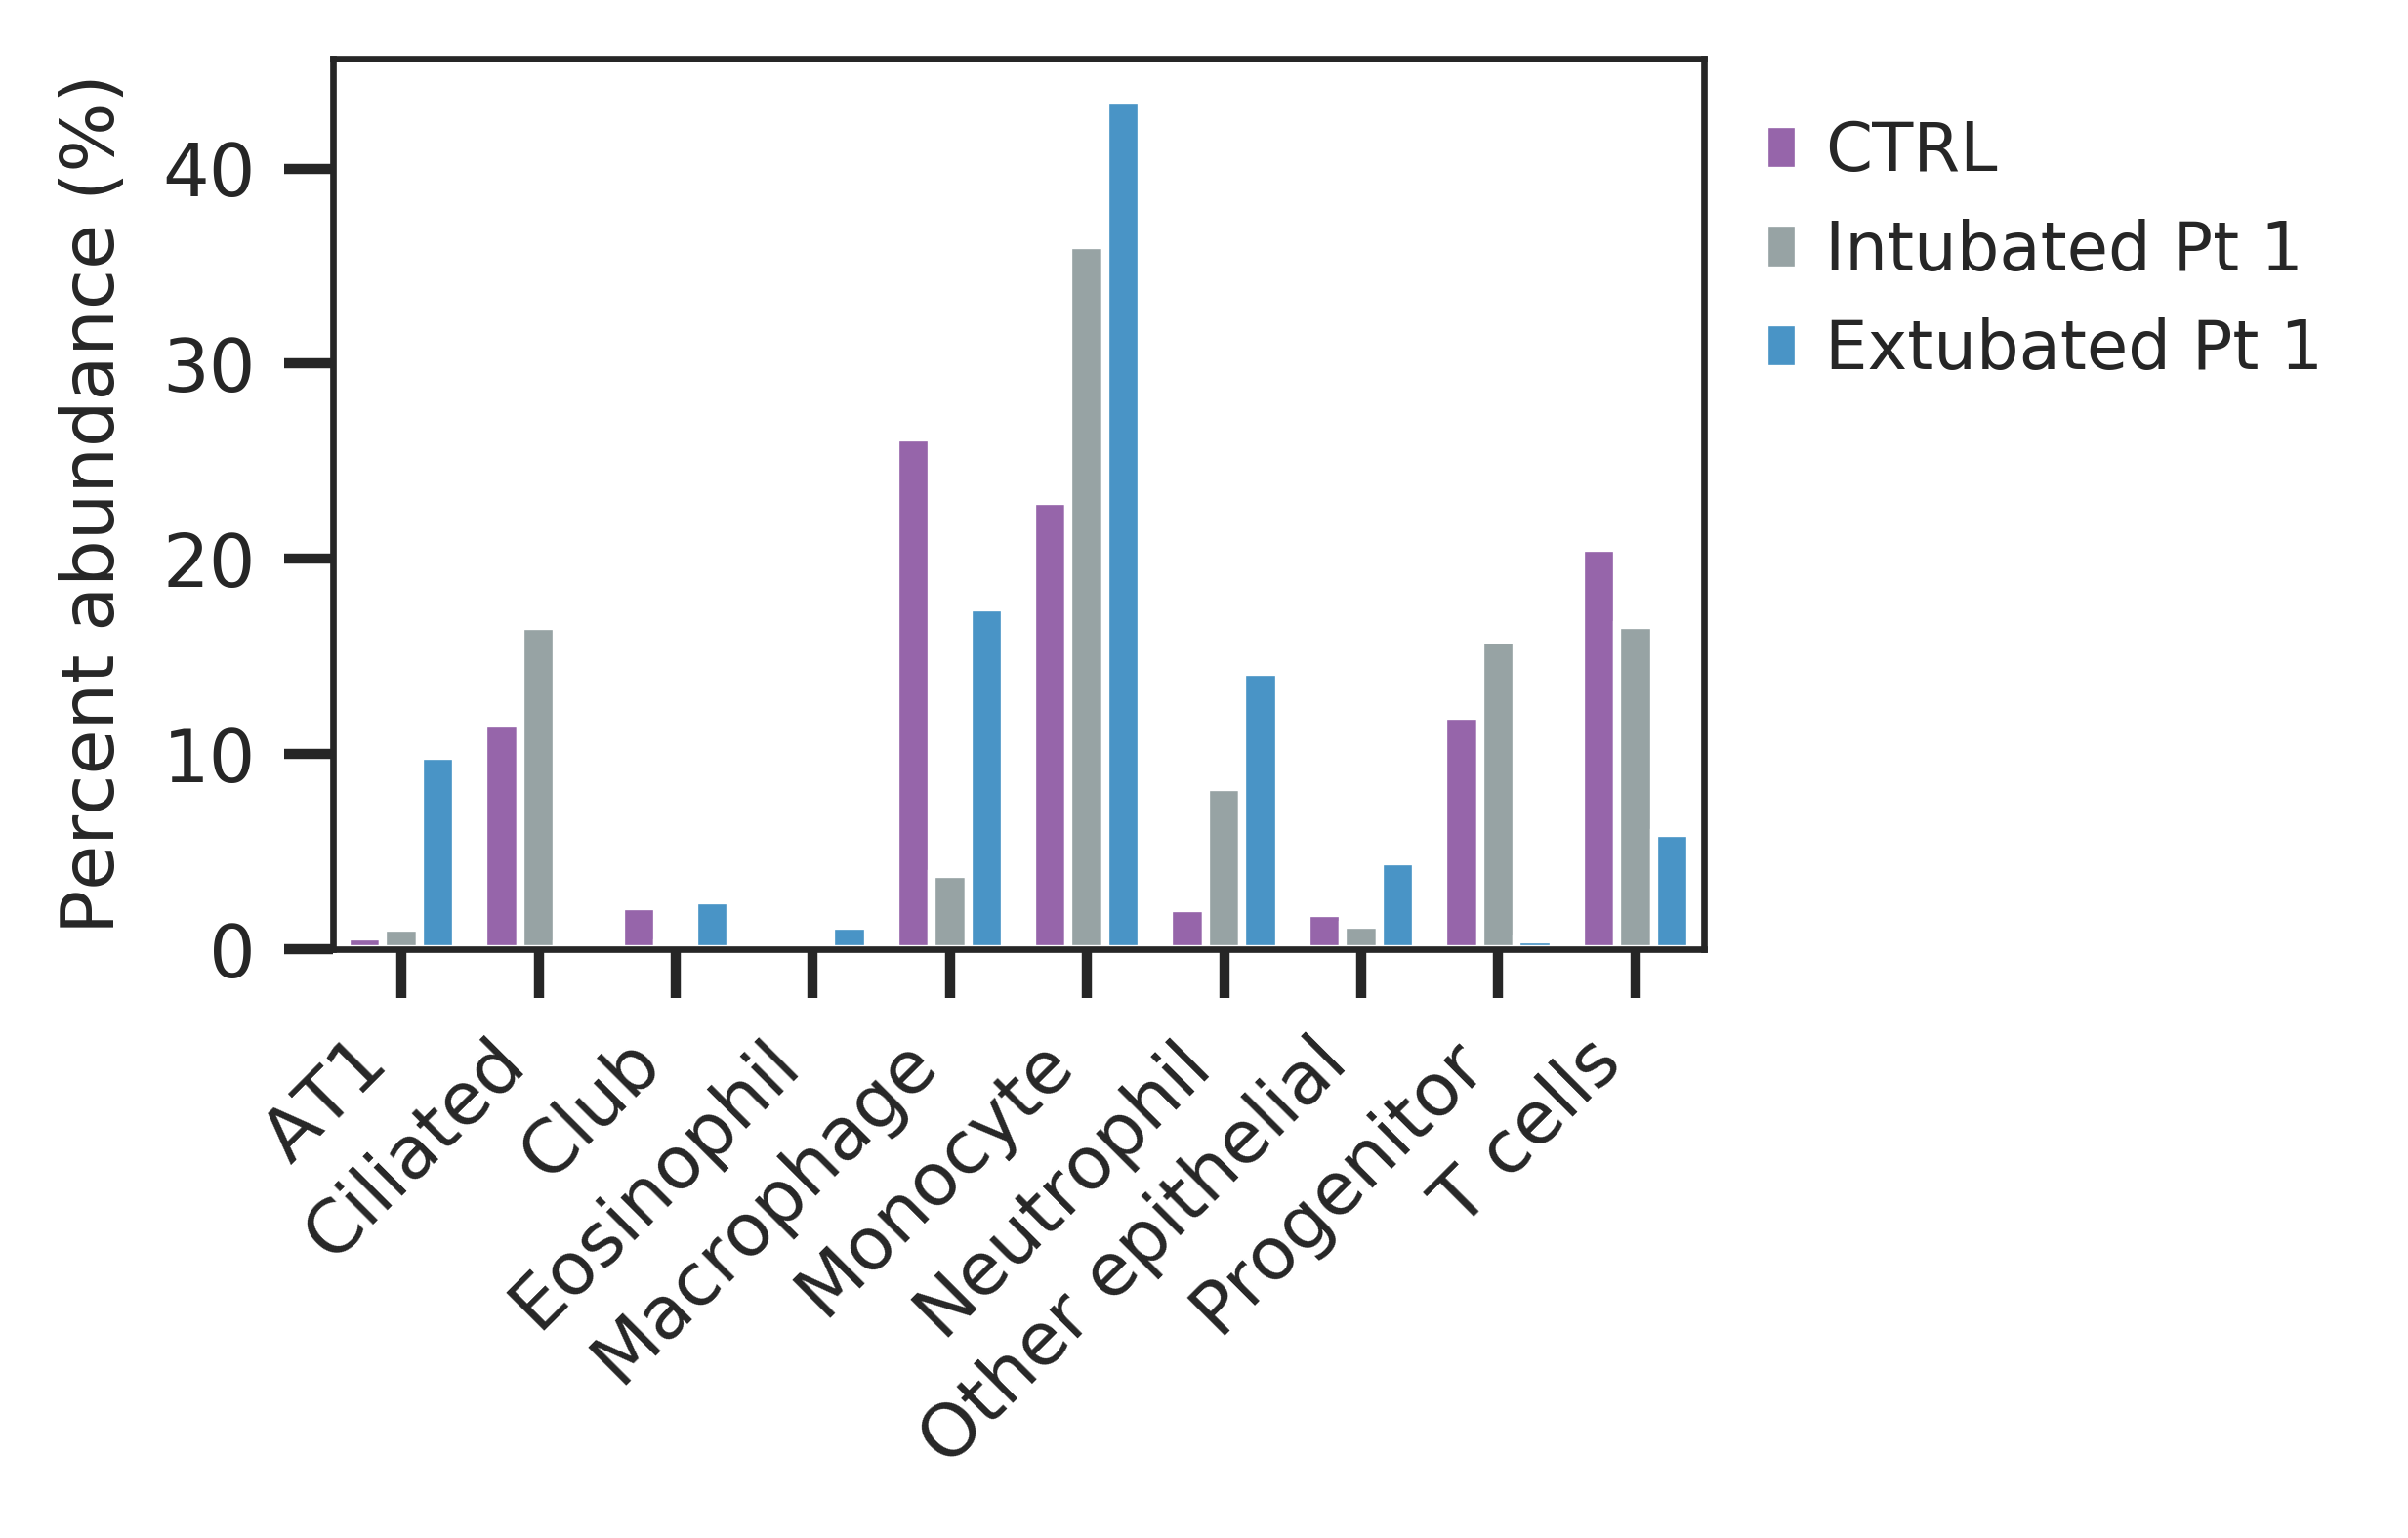

In [37]:
# relative cell type abundance 
x = 100*adata.obs.groupby(['Condition','init_ctype']).count()['batch']/adata.obs.groupby(['Condition']).count()['batch']
x = x.unstack(level=0)

x.columns = x.columns.add_categories(['init_ctype'])
x = x.reset_index()
x = x.melt(id_vars=['init_ctype'])
fig,ax=plt.subplots(1,1,figsize=(3,2))
sns.barplot(x='init_ctype',y='value',hue='Condition',
            hue_order = ['CTRL', 'Intubated Pt 1', 'Extubated Pt 1'],
            data=x,
            palette=cmap_condition)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Percent abundance (%)')
fig.savefig(os.path.join(pfp,'ctype_abundance.pdf'),bbox_inches='tight')

In [38]:
# N infected 
x = adata.obs.groupby(['Condition','grouped_ctype']).sum()['scv2_geq1']
x = x.unstack(level=0)

x.columns = x.columns.add_categories(['grouped_ctype'])
x = x.reset_index()
x = x.melt(id_vars=['grouped_ctype'])
fig,ax=plt.subplots(1,1,figsize=(3,2))
sns.barplot(x='grouped_ctype',y='value',hue='Condition',
            data=x,
            palette=cmap_condition)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Number infected')


KeyError: 'grouped_ctype'

Text(0, 0.5, 'Percent infected')

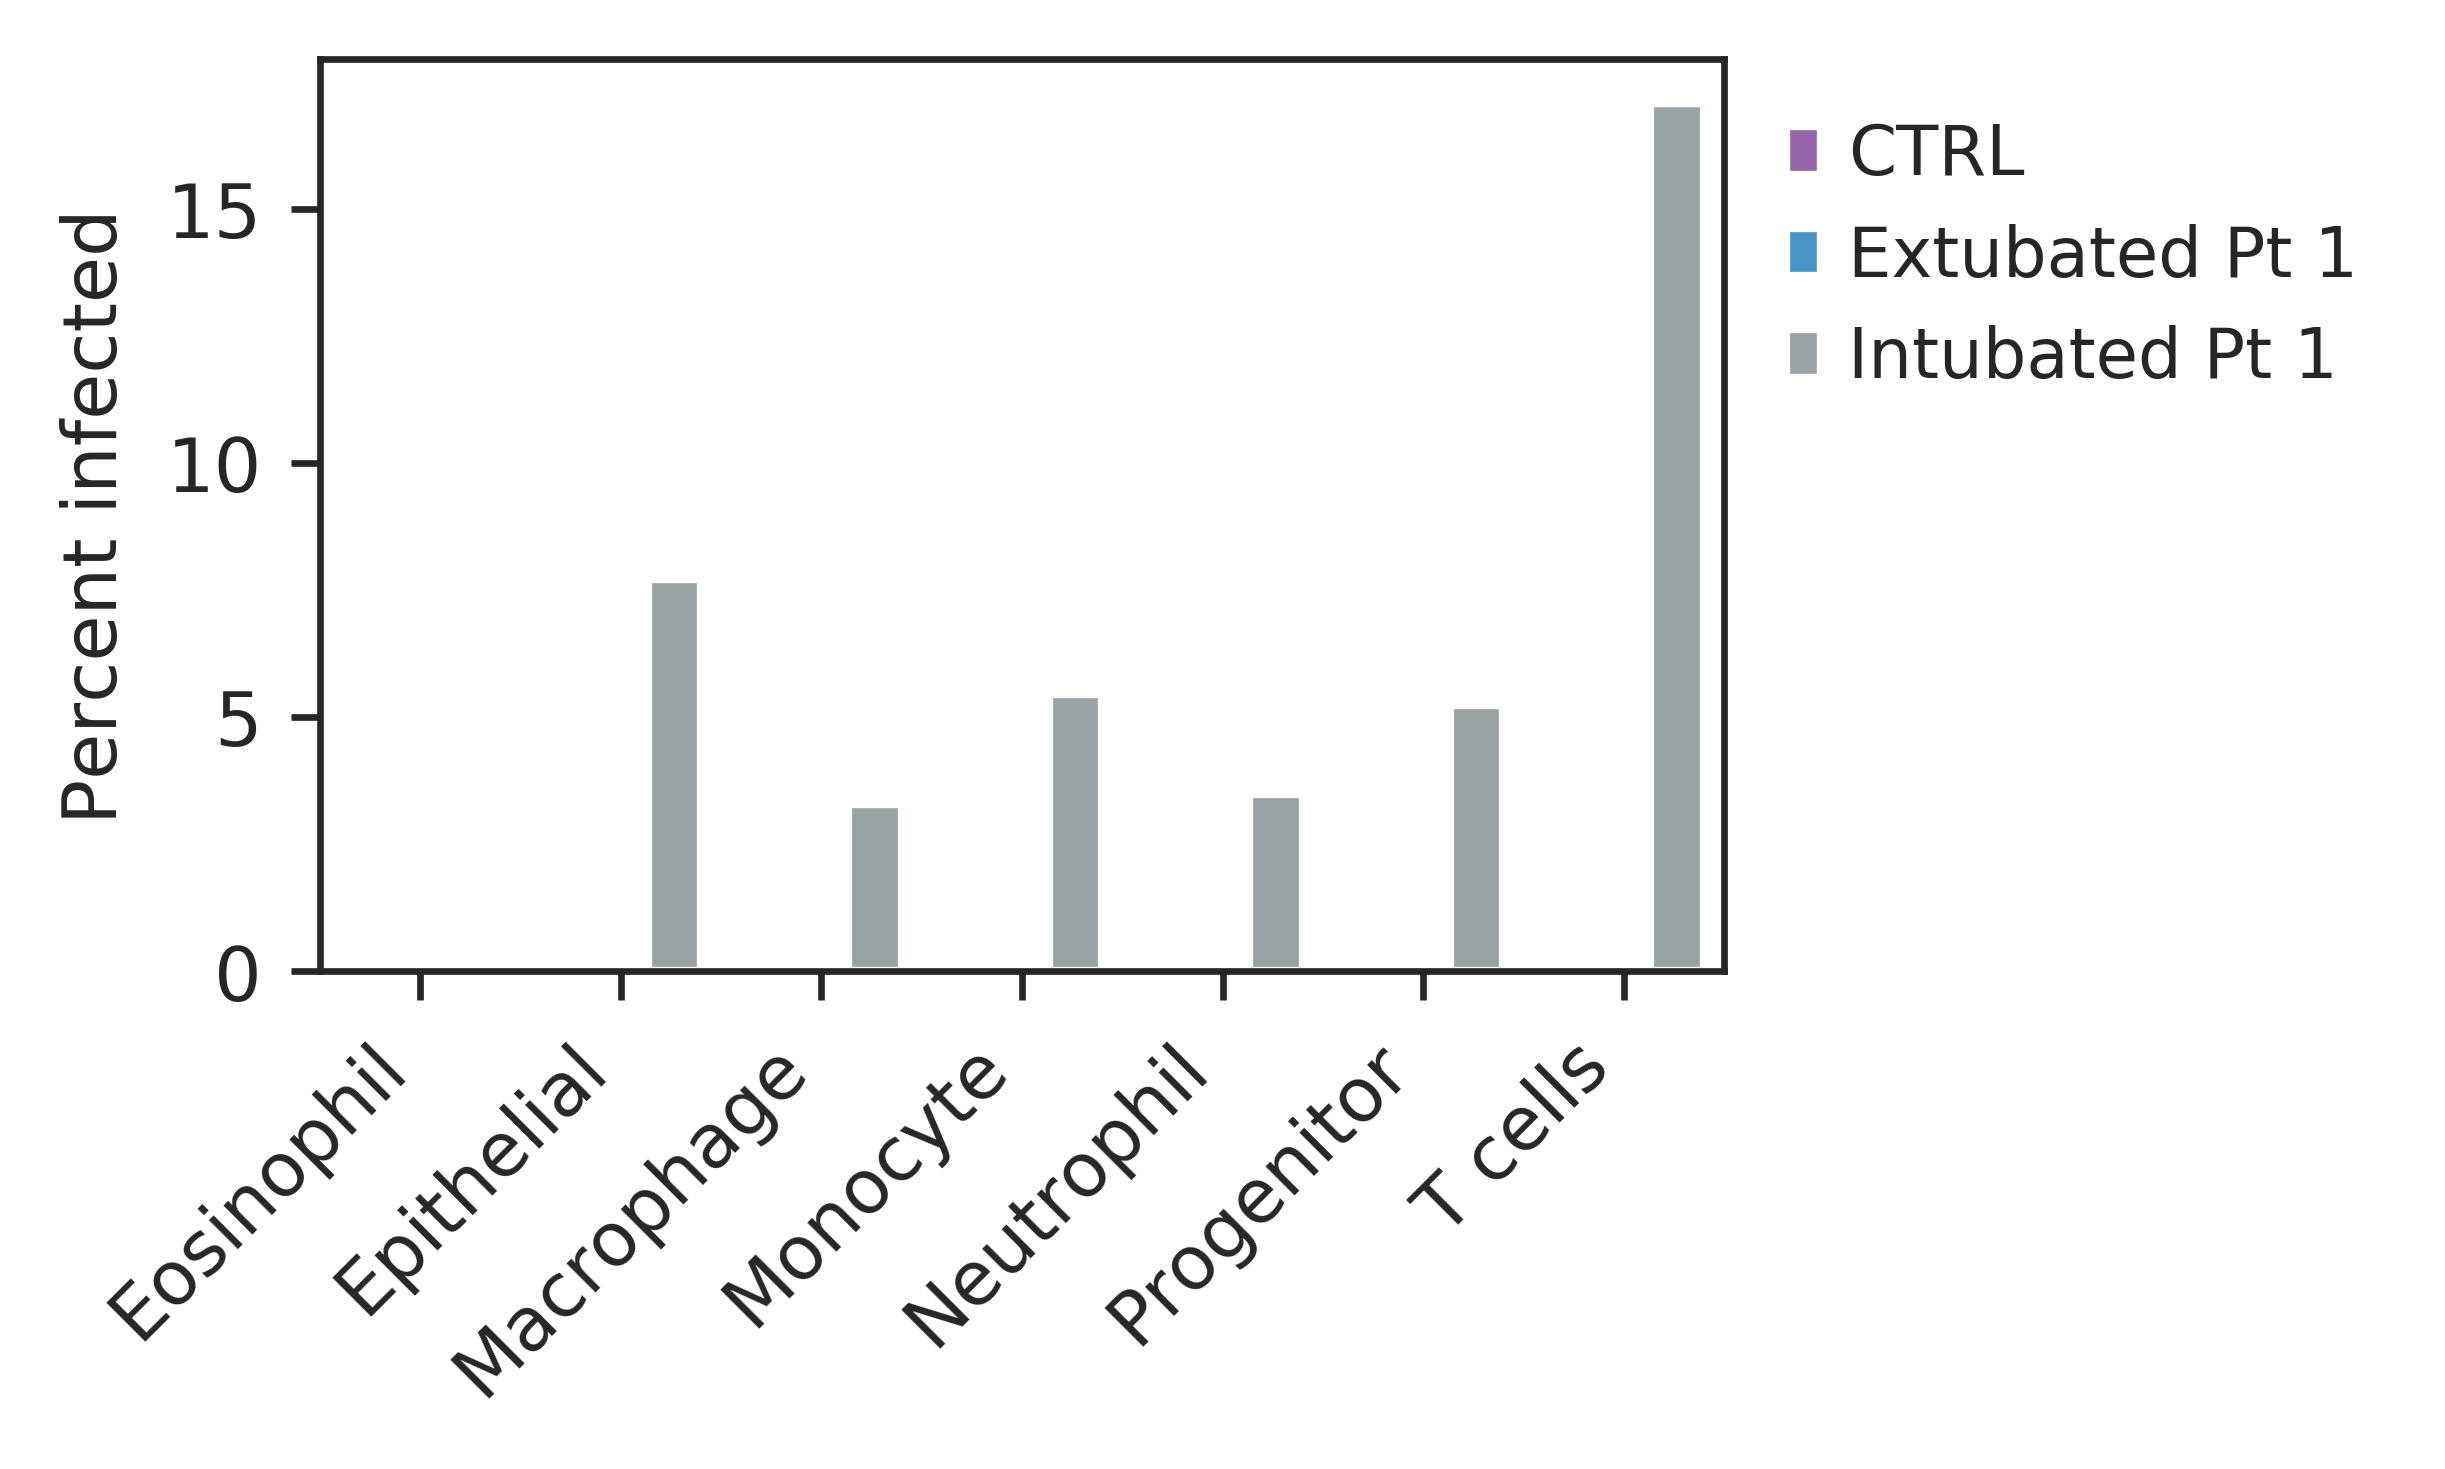

In [59]:
# percent infected 
x = 100*adata.obs.groupby(['Condition','grouped_ctype']).sum()['scv2_geq1']/adata.obs.groupby(['Condition','grouped_ctype']).count()['batch']
x = x.unstack(level=0)

x.columns = x.columns.add_categories(['grouped_ctype'])
x = x.reset_index()
x = x.melt(id_vars=['grouped_ctype'])
fig,ax=plt.subplots(1,1,figsize=(3,2))
sns.barplot(x='grouped_ctype',y='value',hue='Condition',
            data=x,
            palette=cmap_condition)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Percent infected')


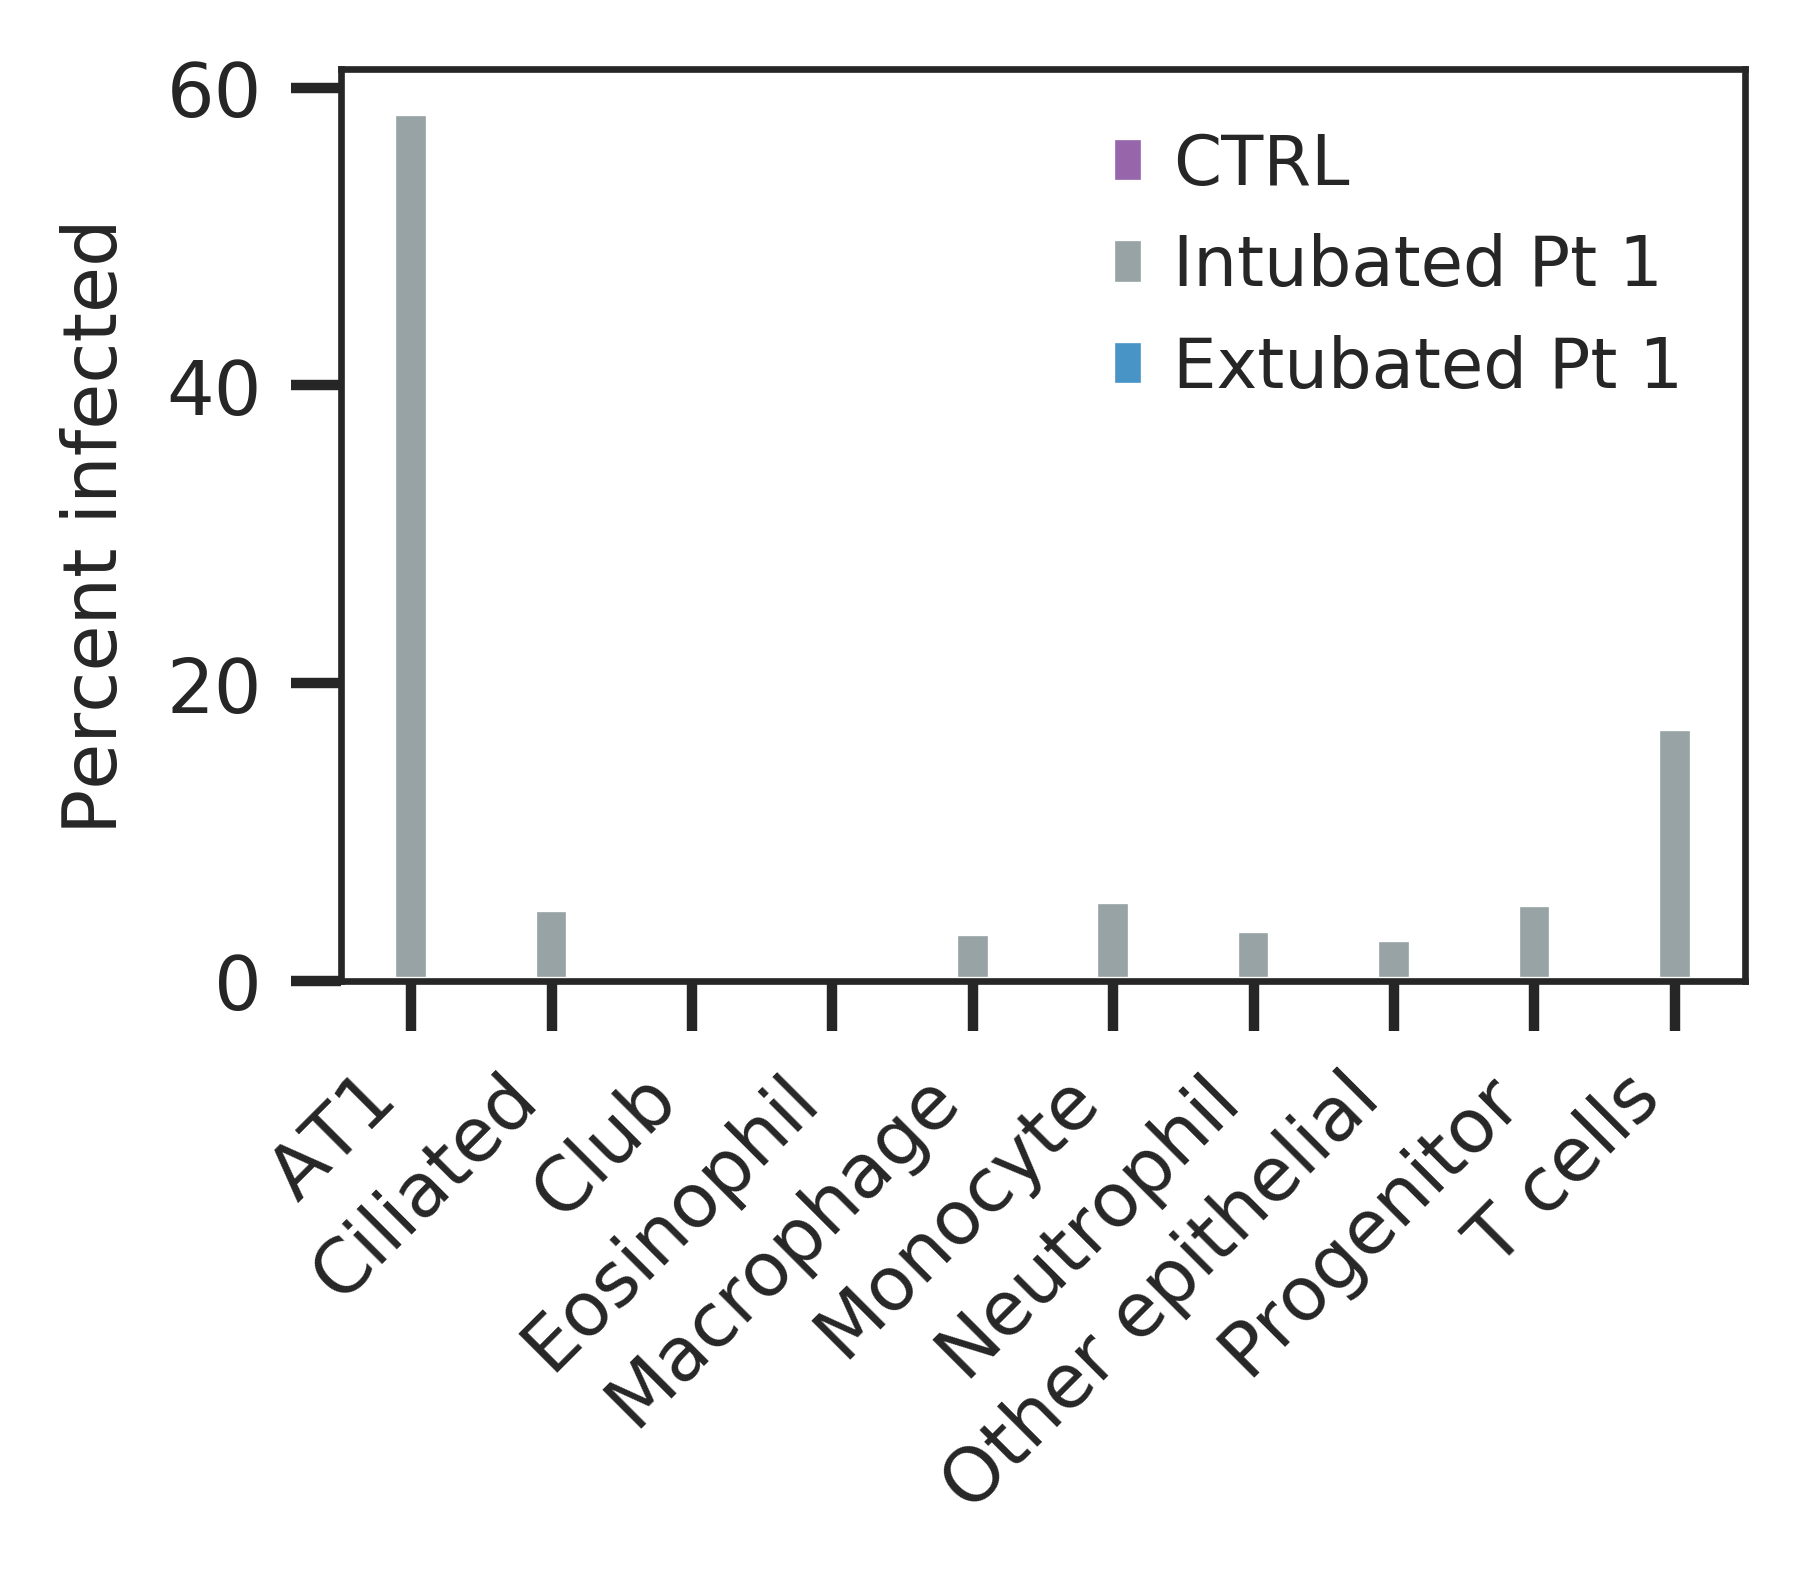

In [39]:
# percent infected 
x = 100*adata.obs.groupby(['Condition','init_ctype']).sum()['scv2_geq1']/adata.obs.groupby(['Condition','init_ctype']).count()['batch']
x = x.unstack(level=0)

x.columns = x.columns.add_categories(['init_ctype'])
x = x.reset_index()
x = x.melt(id_vars=['init_ctype'])
fig,ax=plt.subplots(1,1,figsize=(3,2))
sns.barplot(x='init_ctype',y='value',hue='Condition',
            data=x,
            hue_order = ['CTRL', 'Intubated Pt 1', 'Extubated Pt 1'],
            palette=cmap_condition)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Percent infected')
fig.savefig(os.path.join(pfp,'pInfected.pdf'),bbox_inches='tight')

## Heatmaps of goi

In [9]:
adata.obs['grouped_ctype'] = adata.obs['init_ctype'].astype(str)
adata.obs.loc[adata.obs['init_ctype']=='AT1','grouped_ctype'] = 'Epithelial'
adata.obs.loc[adata.obs['init_ctype']=='Ciliated','grouped_ctype'] = 'Epithelial'
adata.obs.loc[adata.obs['init_ctype']=='Club','grouped_ctype'] = 'Epithelial'
adata.obs.loc[adata.obs['init_ctype']=='Other epithelial','grouped_ctype'] = 'Epithelial'

In [10]:
genes = {'Immune-related':['IFNL1','IFNAR1','IFNLR1','IFI27','IFITM3','IFI6','IFIT1',
         'MX1','ISG15','CCL2','CXCL9','CXCL10','CXCL11','CXCL16','IL1A','IL1B','IL1RN','IL6','IL10','TNF'],
         
         'Virus-related':['scv2_orf1-10','ACE','ACE2','TMPRSS2','TMPRSS4','CTSL',
                          'CLTRN','DPP4','ANPEP'],
         
         'EGFR induces':[
             'MUC5B', 'MUC5AC', 'CXCL8', 'IL13RA1', 'IL33', 'VEGFA', 
             'TGFB1', 'TGFB2', 'TGFBR1', 'TGFBR2', 'SMAD2', 'SMAD3', 'PRKCA', 'PRKCB', 
             'PRKCD', 'CAV1', 'STAT3', 'STAT5A', 'CHI3L1', 'CHIT1', 'MAP2K1', 
             'MAPK1', 'MAPK3', 'NOTCH1', 'CCL17', 'CCL20', 'AKT1', 'AKT2', 'NFKB1', 
             'TLR2', 'TLR4', 'TLR5', 'TLR6', 'PTGS2', 'PTGES2', 'MAPK14', 'MMP9', 'HMOX1', 
             'IL6', 'MMP2', 'CCND1', 'EPS8', 'EPS15', 'JUN', 'IL1B', 'TSLP', 'SOCS1', 'SOCS5',], # could not find 'CHIA', 
         
        'EGFR suppresses':[
            'IRF1', 'IRF2', 'IRF3', 'IRF4', 'IRF5', 'IRF7', 'IFNL1', 
            'SOCS3', 'MX1', 'IL10RB', 'CXCL9', 'CXCL10', 'CXCL11', 'DDX60', 'DDX60L', 
            'IFNAR1', 'STAT1', 'JAK1', 'JAK2', 'PPARG', 'TNFAIP3', 'CASP1', 'NOS1', 'NOS2', 'NOS3',], # could not find 'IFNL4'
         
         'Activates EGFR':[
             'EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'AREG', 'EREG', 'TGFA', 'HBEGF', 'ADAM17', 'DUOX1', 'DUOX2', 'TNF', 'IL1A',
         ]
        }
marker_check(genes, adata)


All markers in data.


In [11]:
sns.set(font_scale=2)

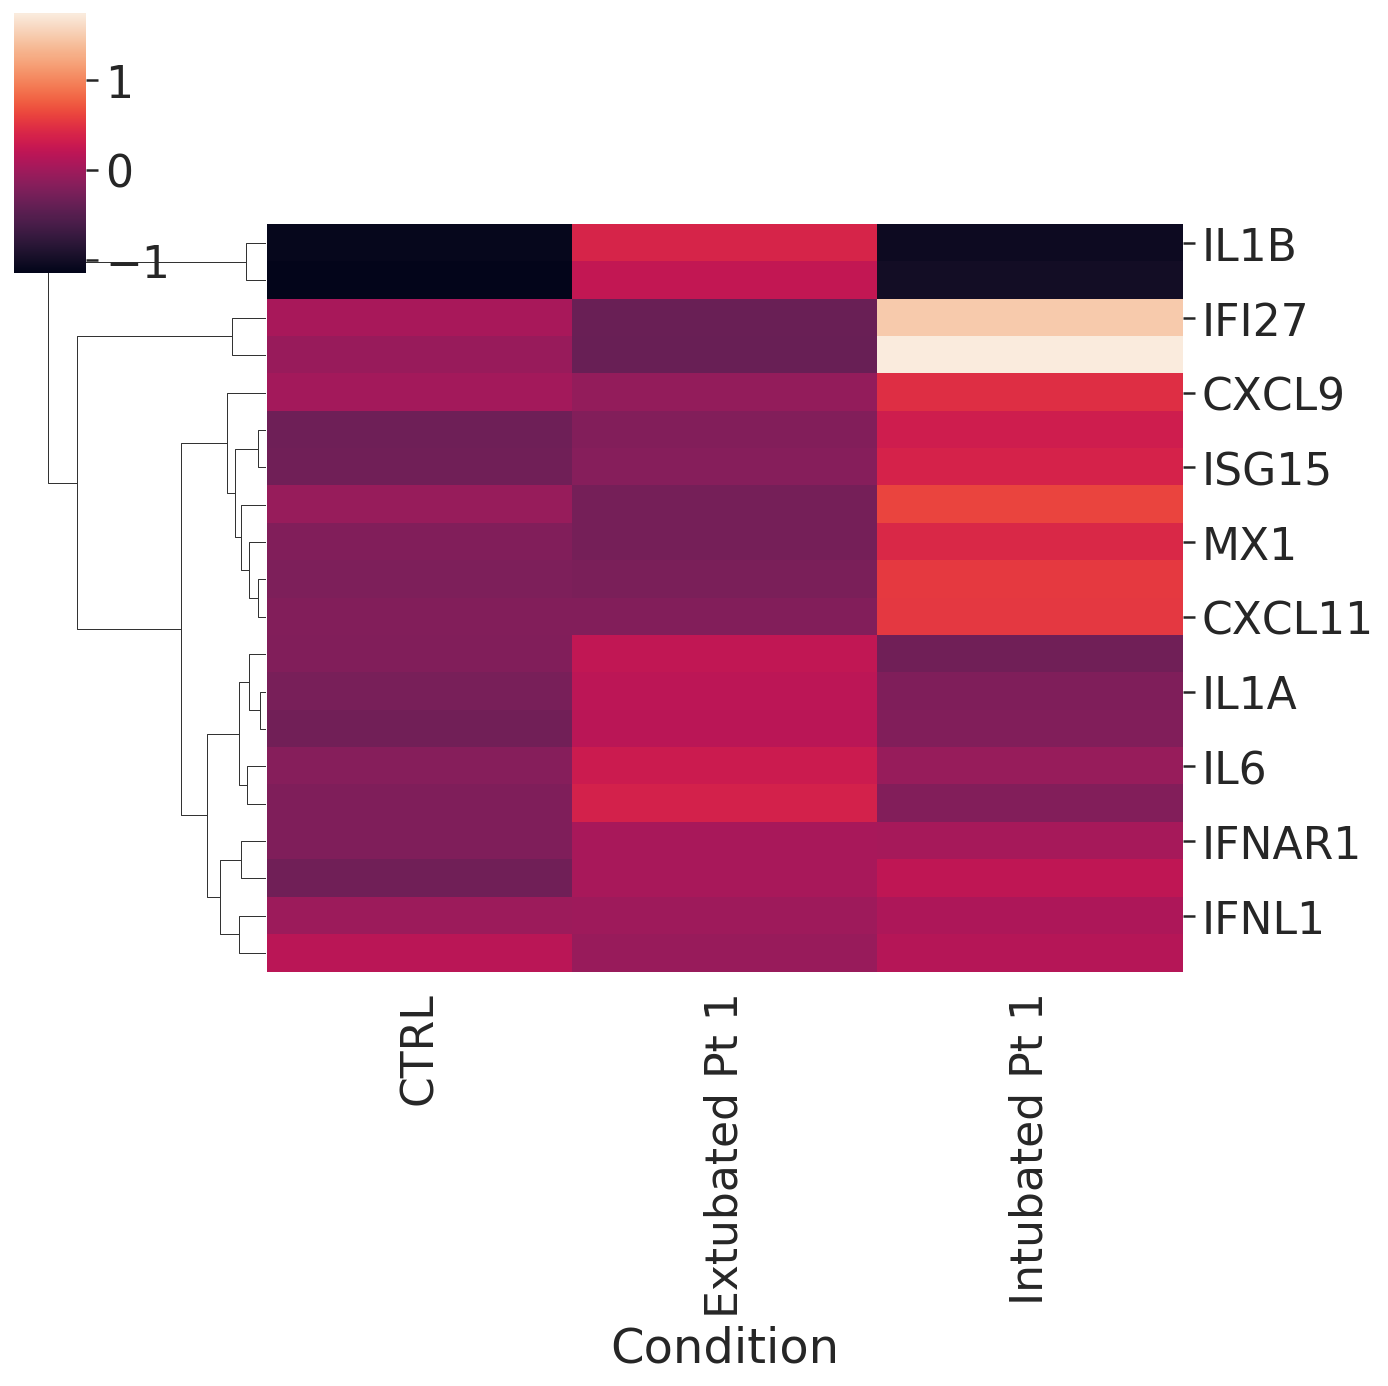

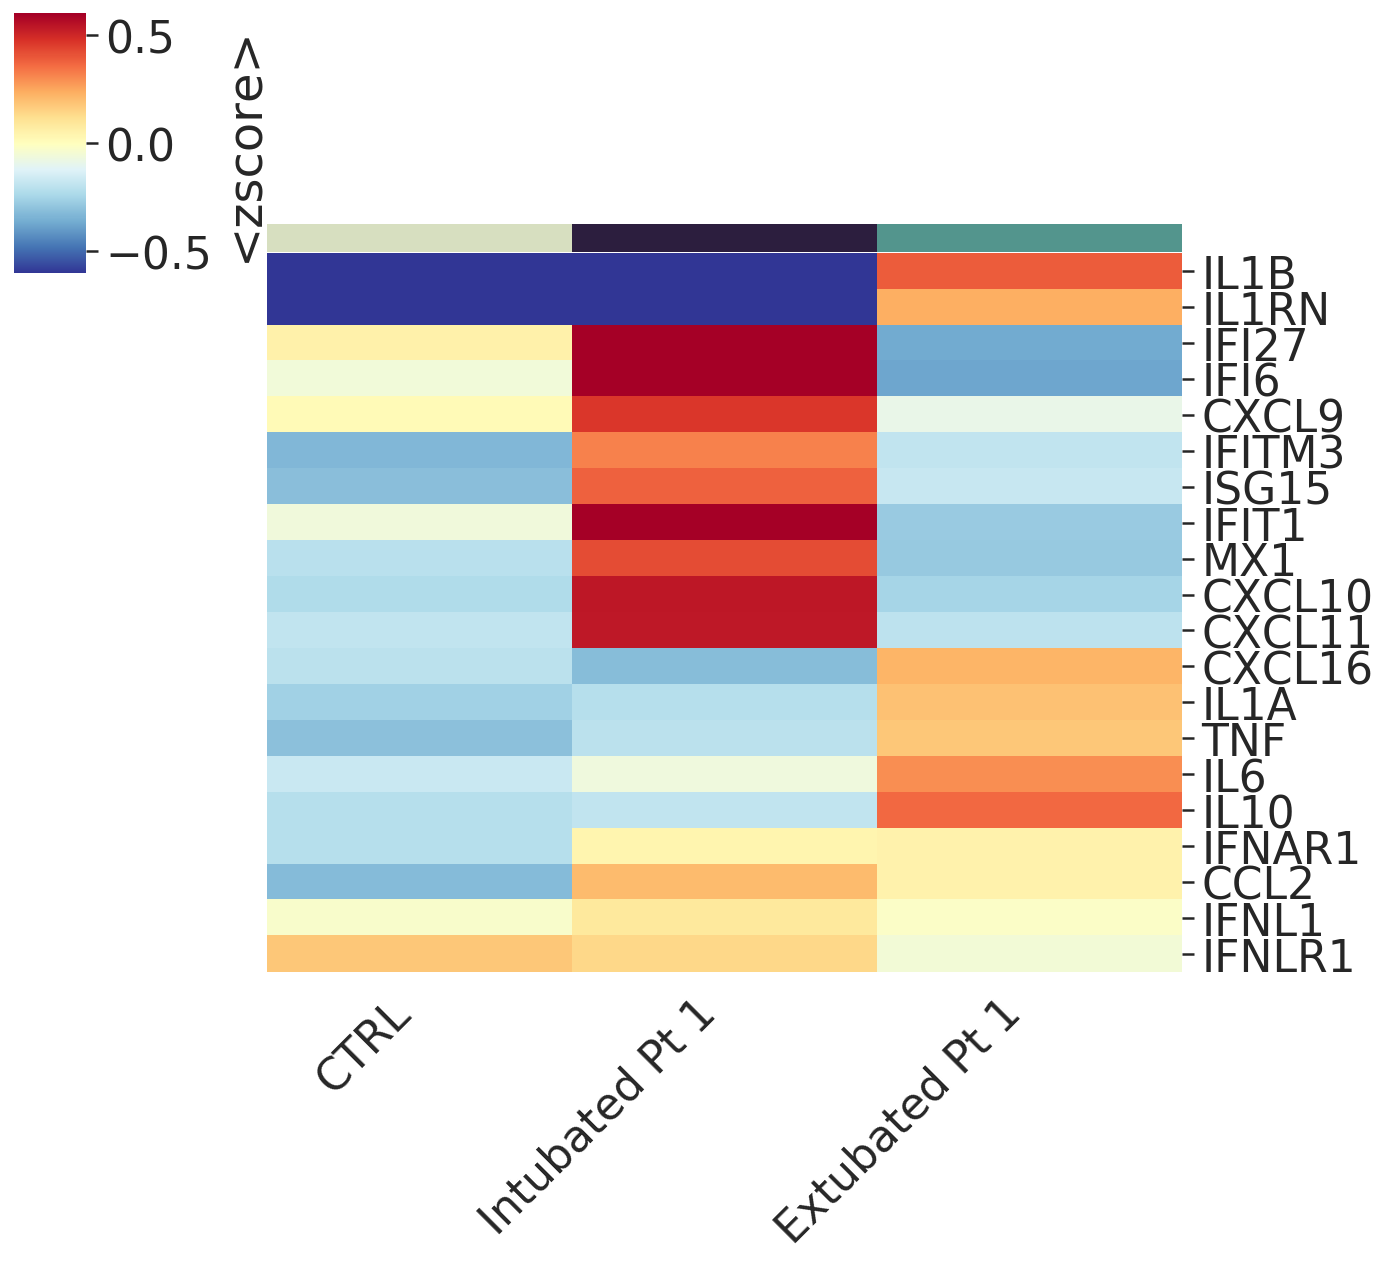

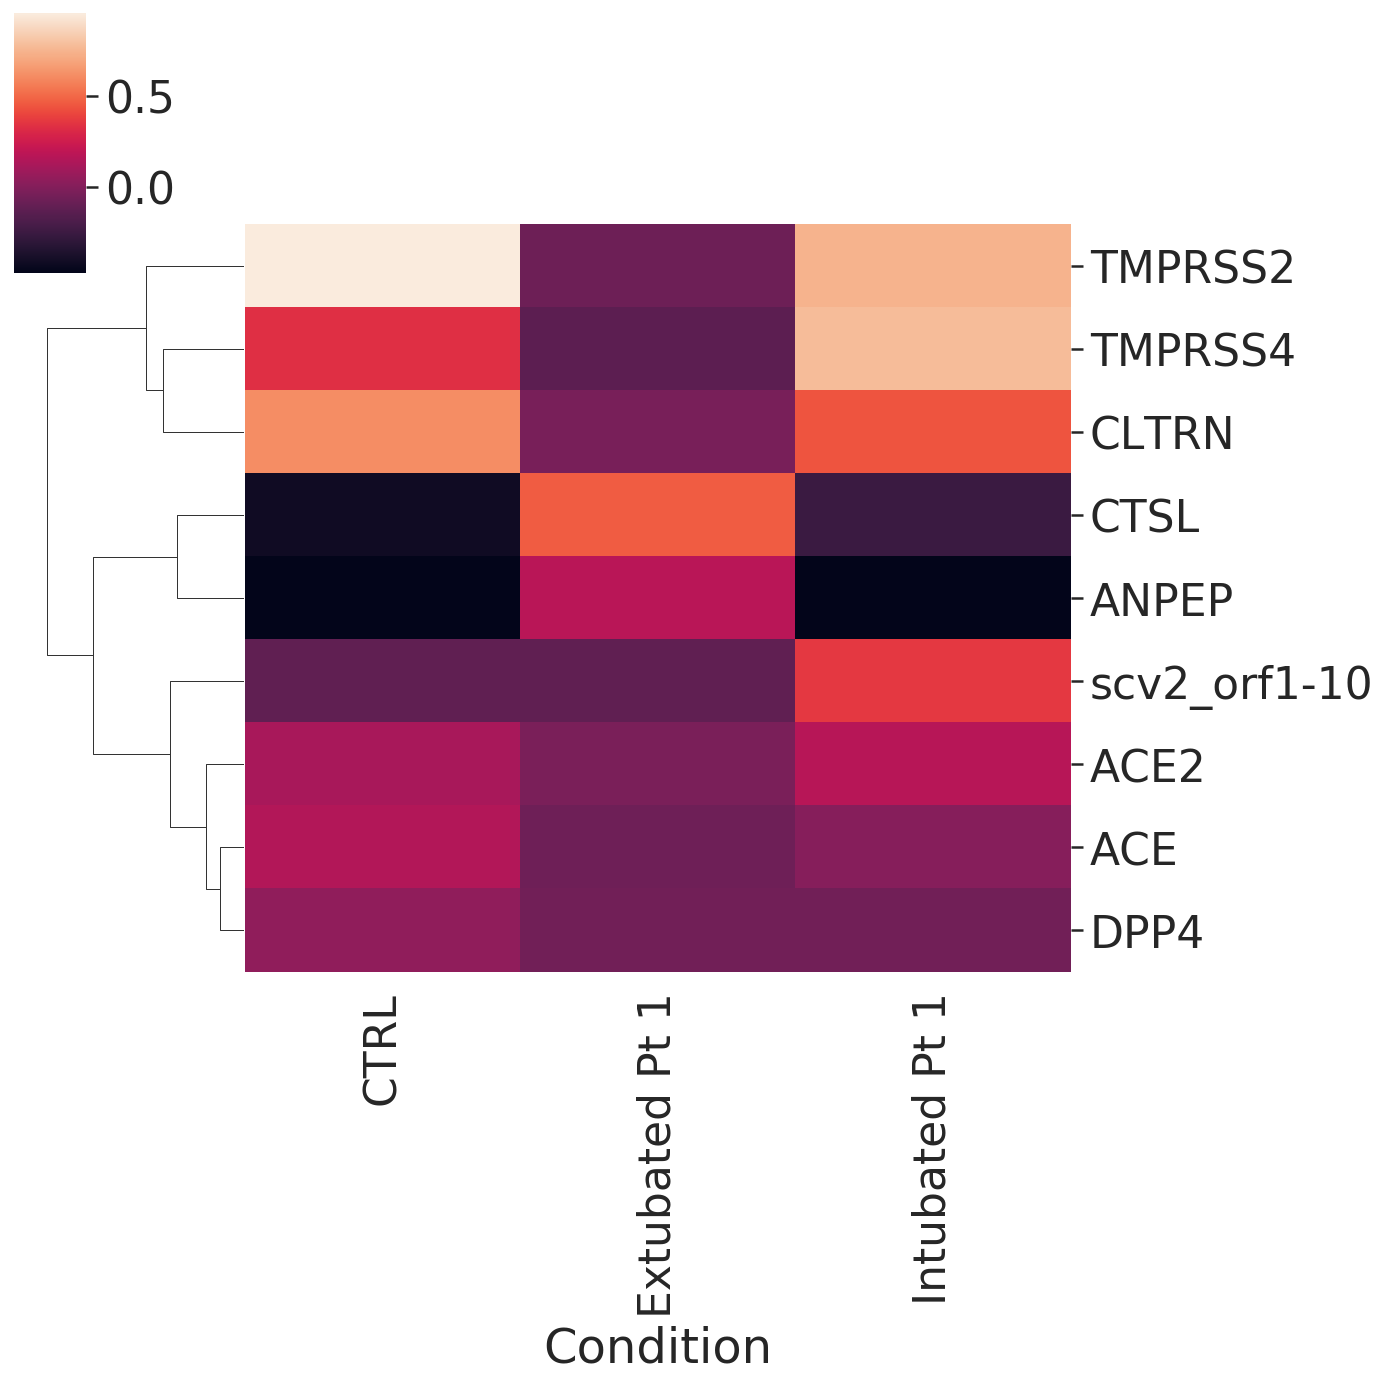

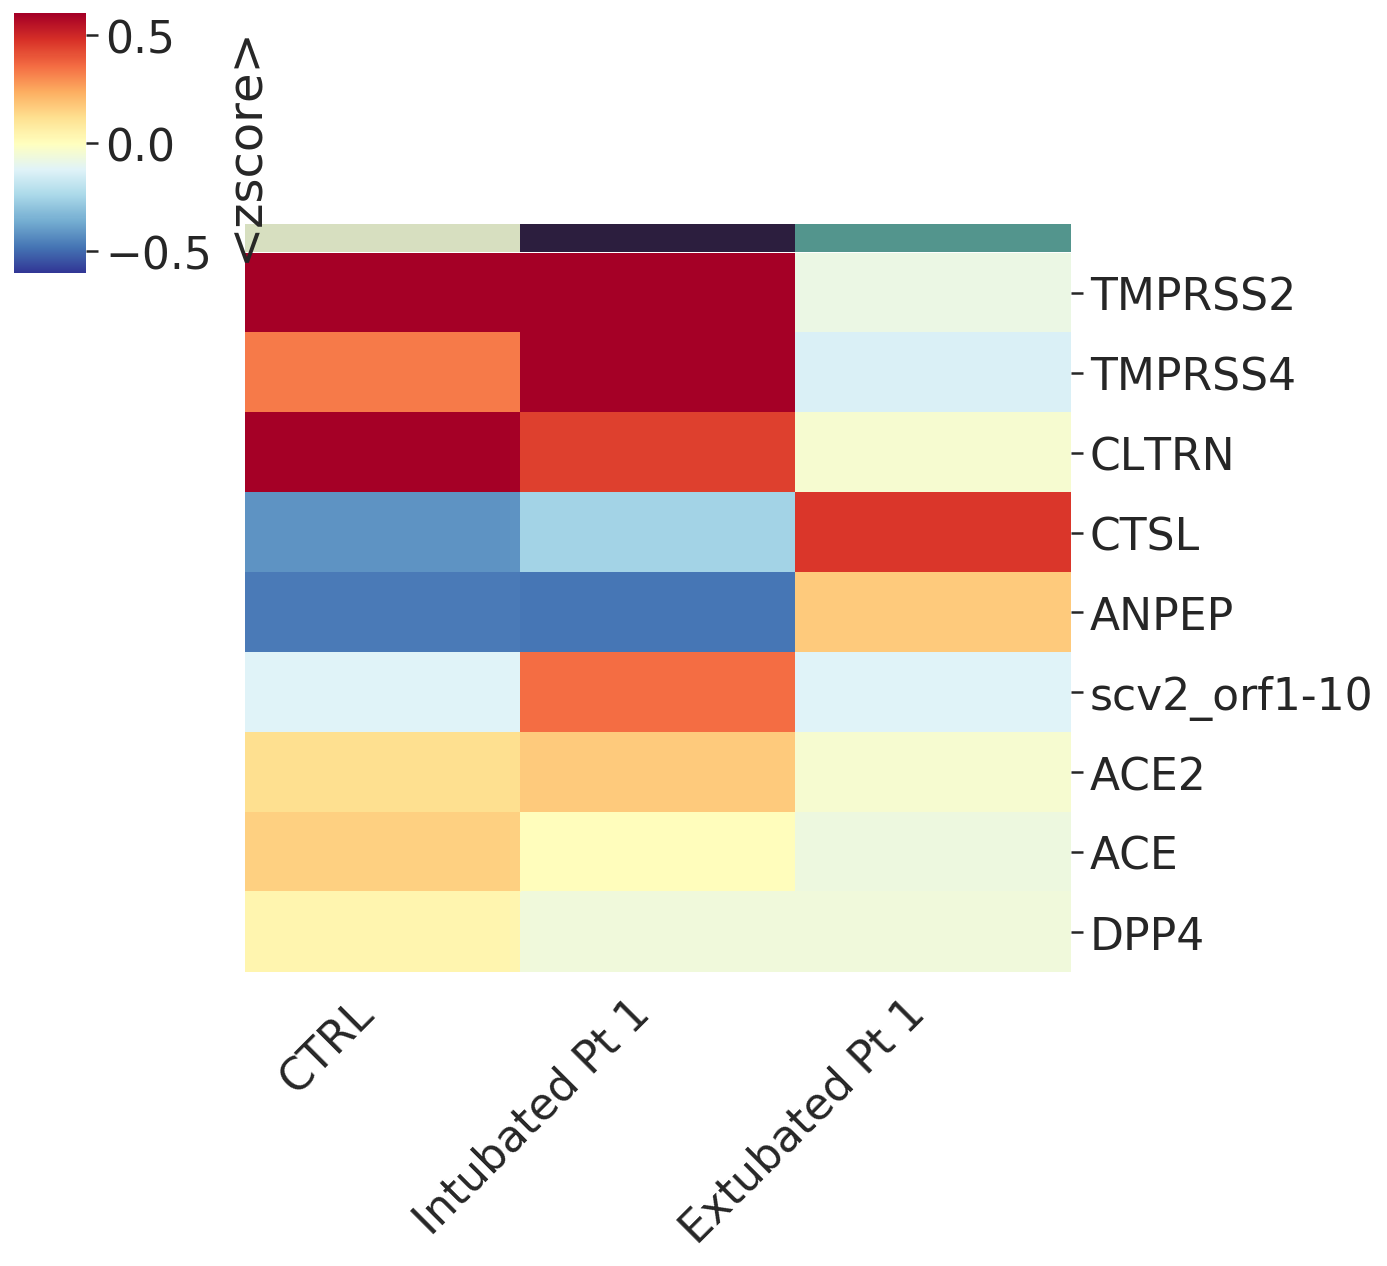

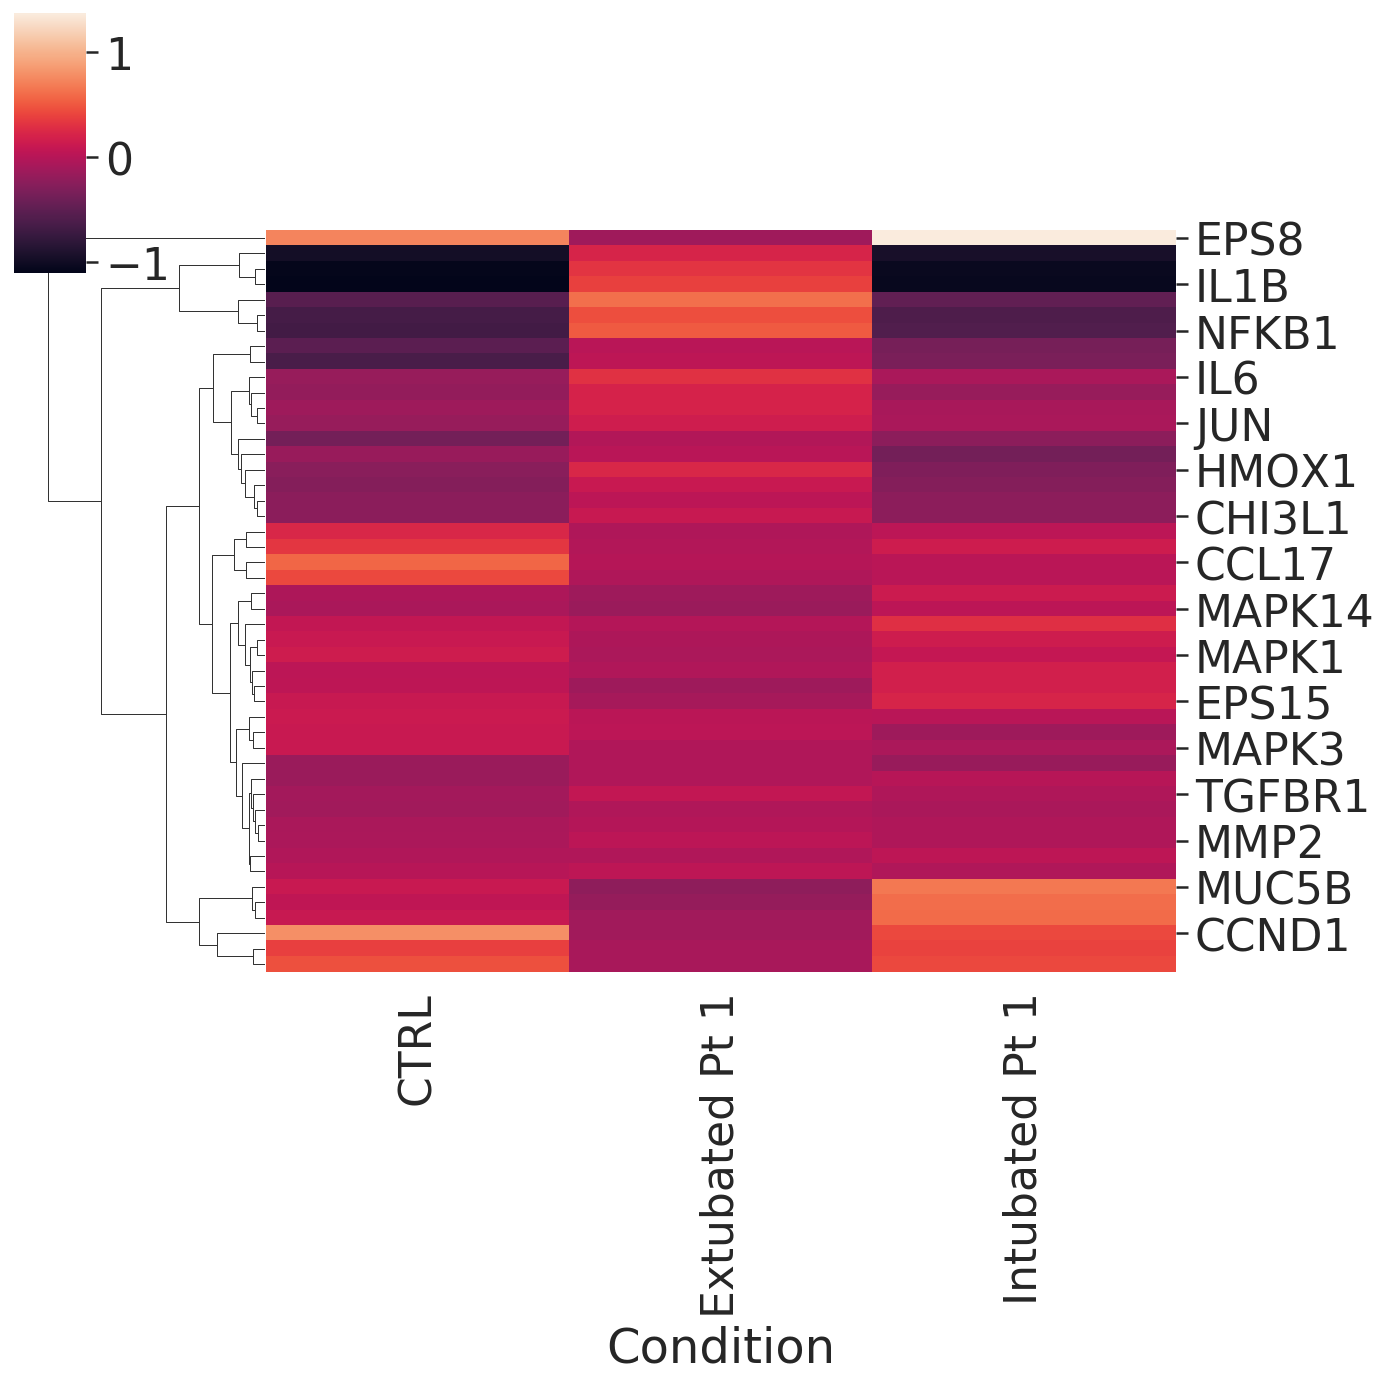

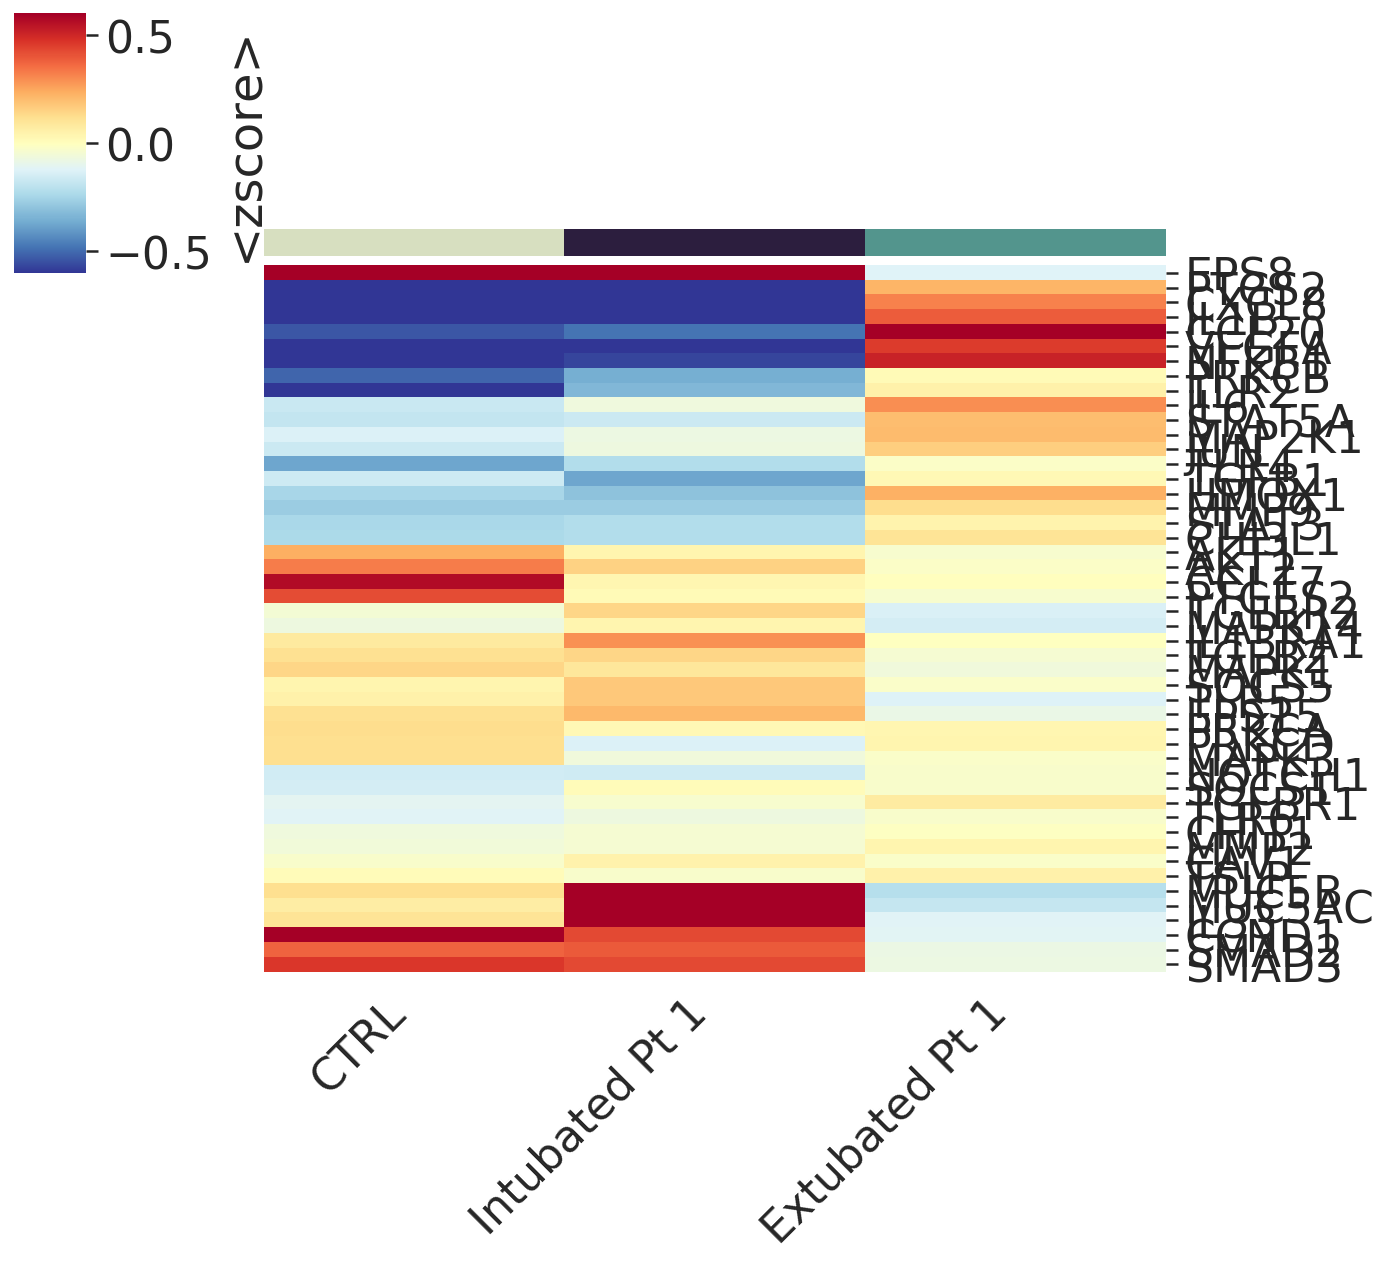

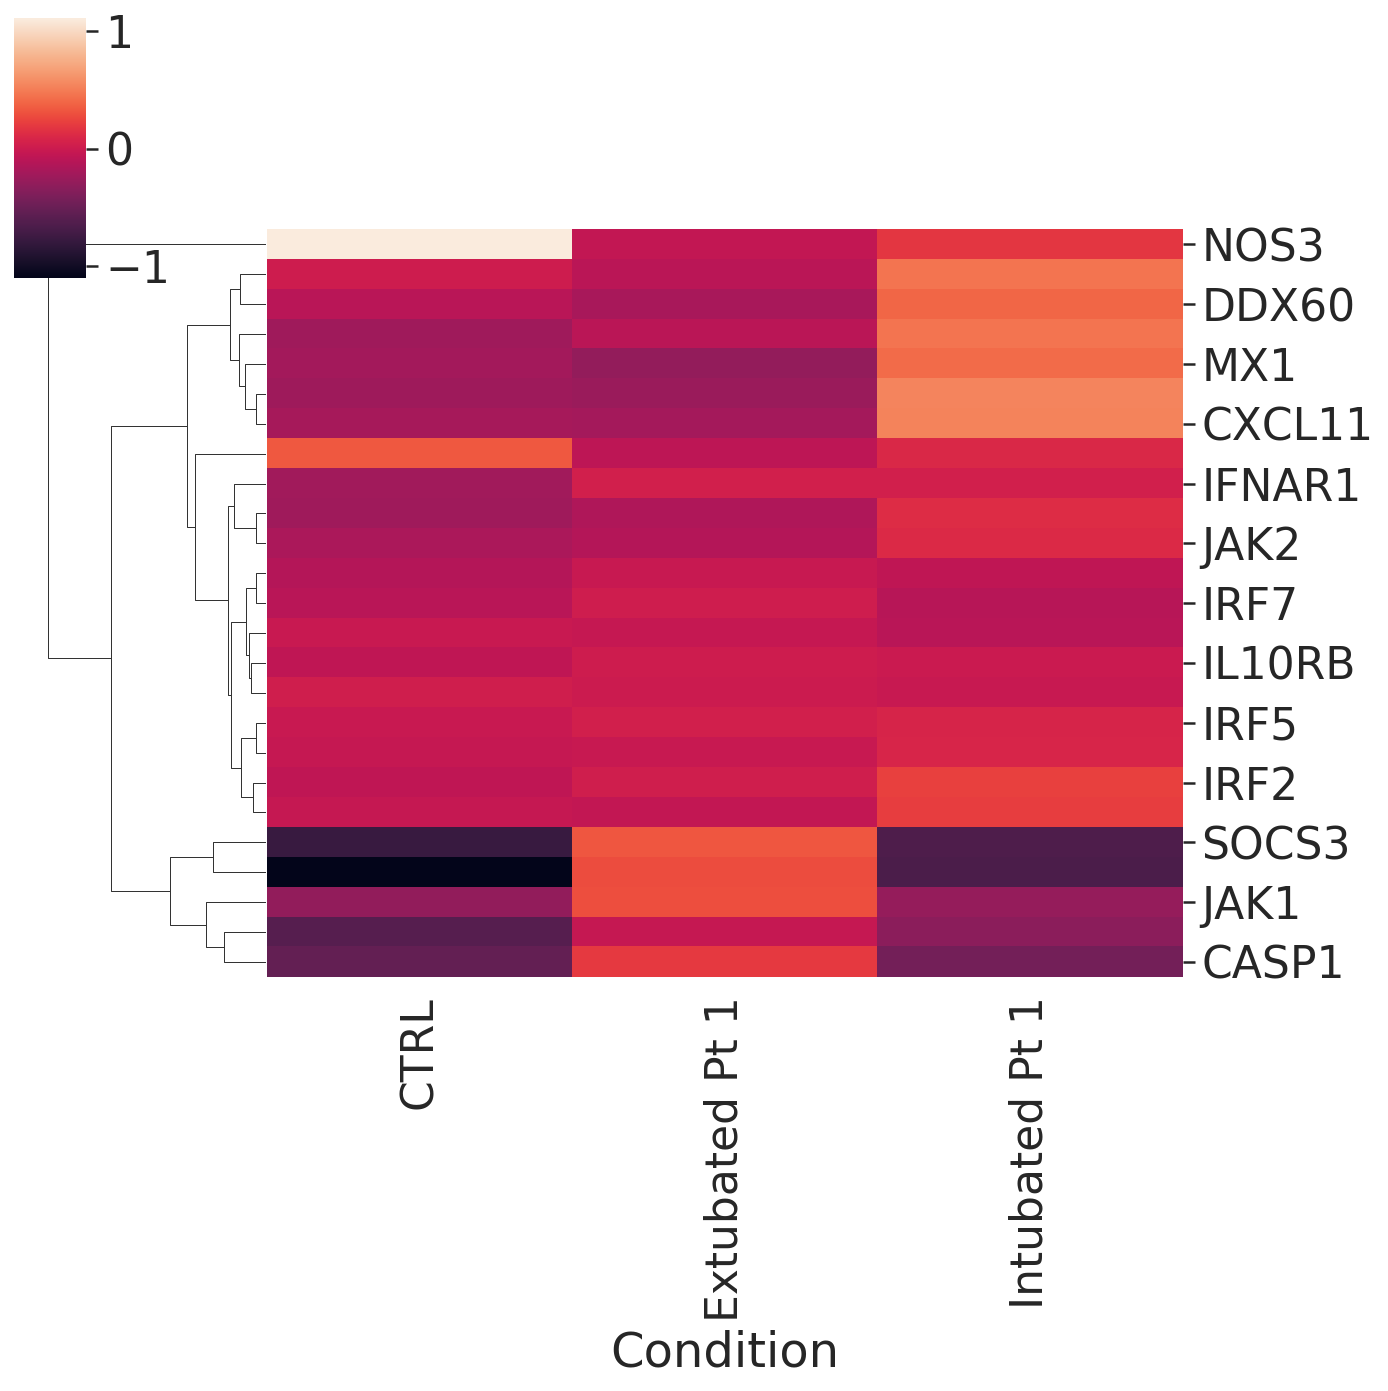

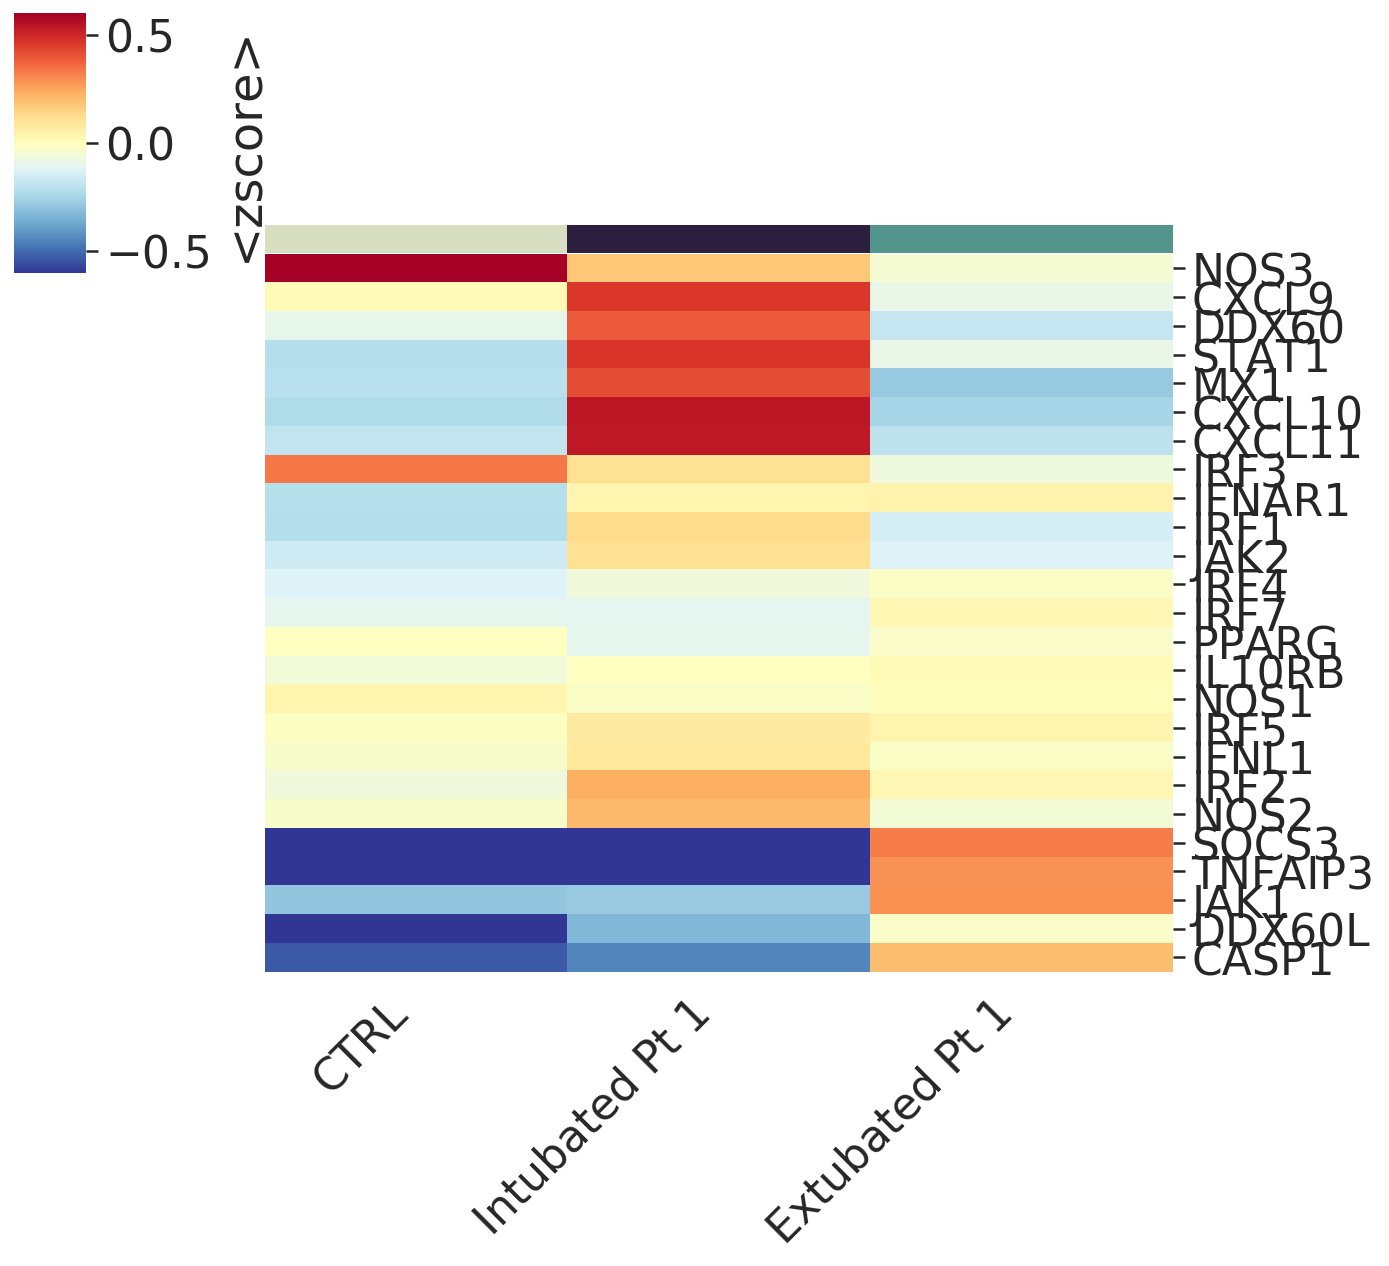

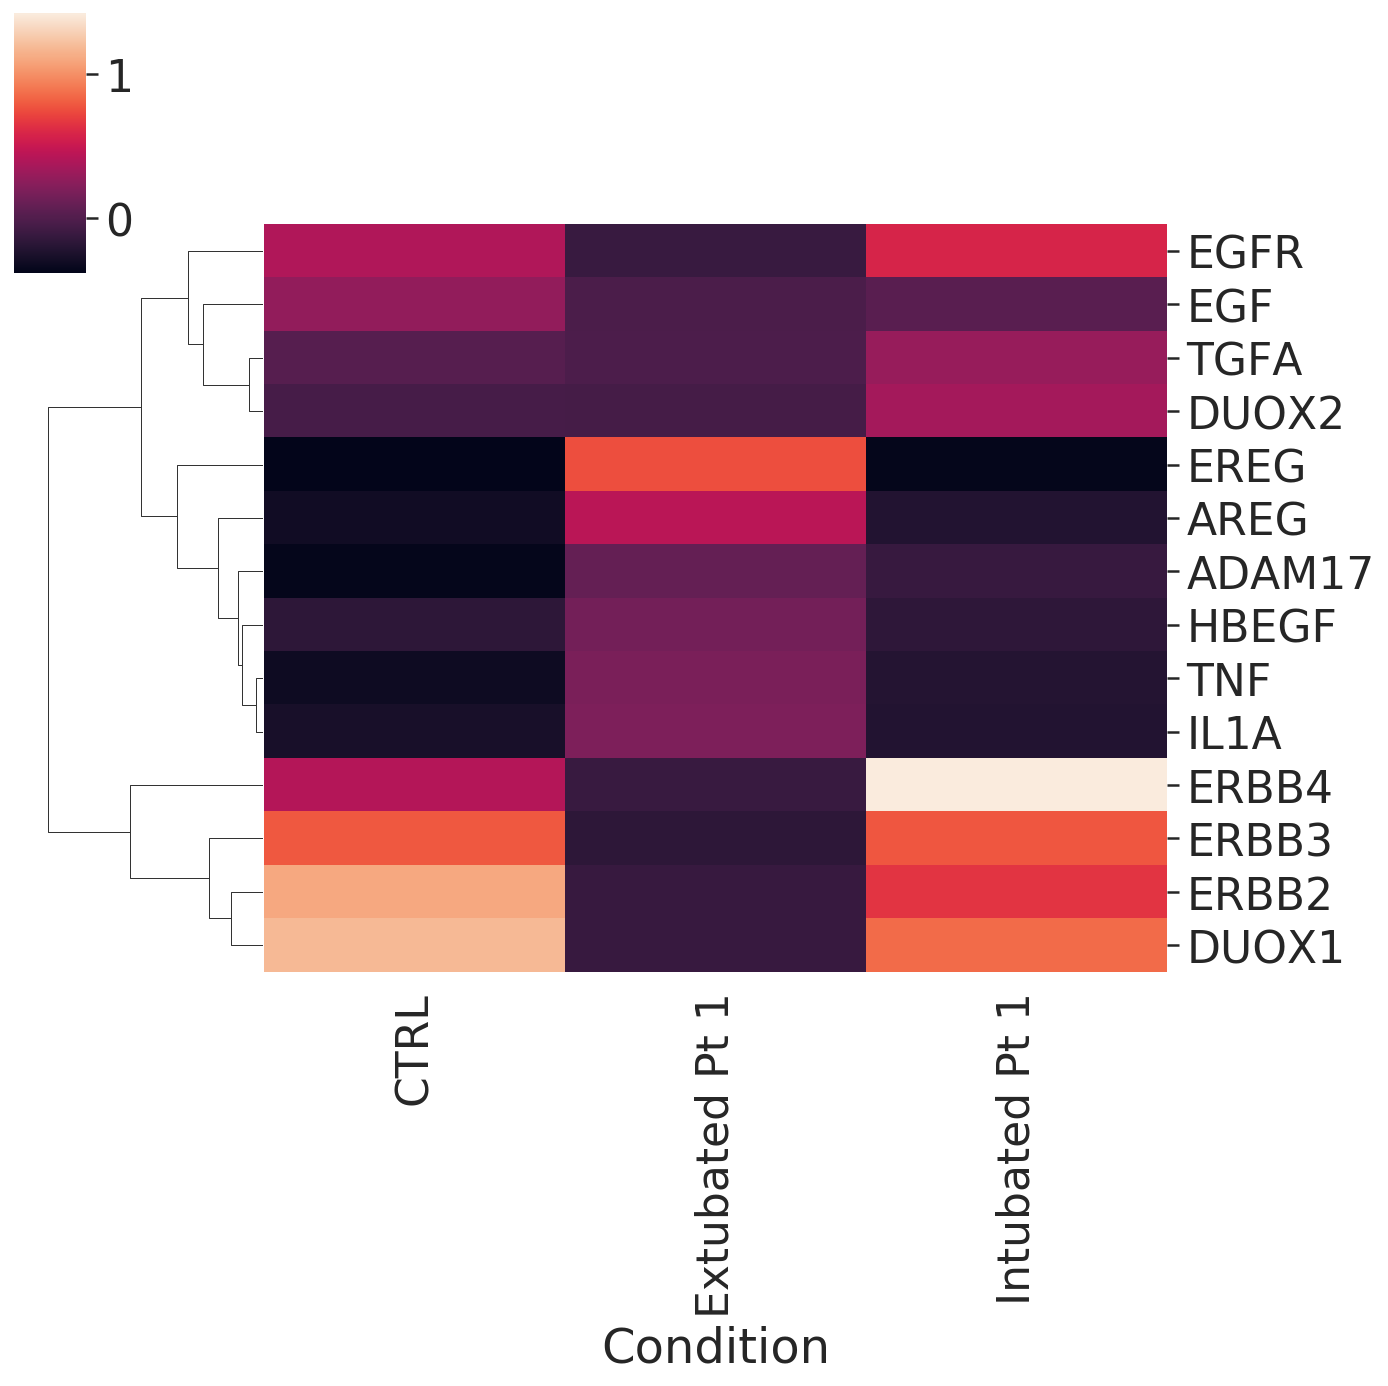

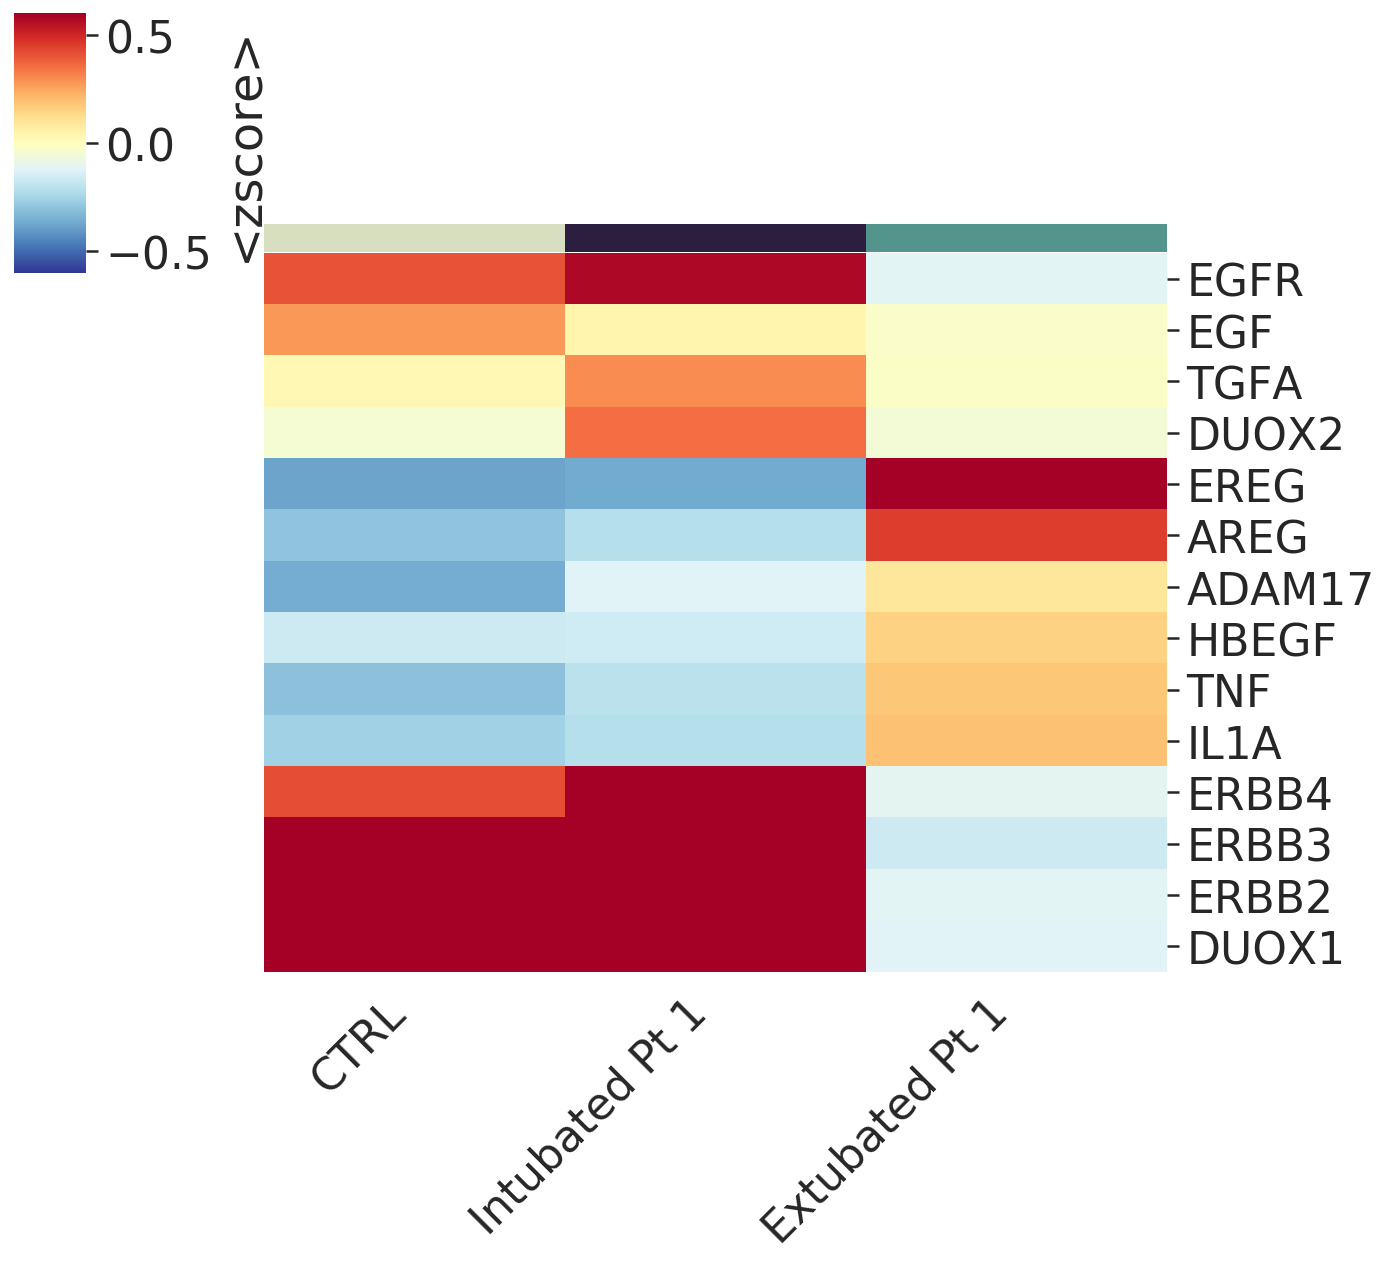

In [14]:


for ctype in ['Epithelial']: #[None]
    # aesthetics
    pal = sns.cubehelix_palette(3,start=.5, rot=-.75)
    col_colors = [pal[0]] + [pal[2]] + [pal[1]]

#     col_colors = [pal[0]] + ['white'] + 2*[pal[1]] + ['white'] + 2*[pal[2]]

    for fname in genes.keys():
        # construct dataframe
        X = pd.DataFrame(np.asarray(adata[:,genes[fname]].X.todense()), 
                        columns=genes[fname])
        X['Cell type'] = adata.obs['grouped_ctype'].astype(str).to_list()
        X['Condition'] = adata.obs['Condition'].astype(str).to_list()

        x = X
        x.loc[:,genes[fname]] = zscore(x.loc[:,genes[fname]])
        x = x.loc[x['Cell type']==ctype,:]

        if False:
            # sort alphabetically
            x['Condition'] = x['Condition'].astype('category')
            x = x.sort_values(by='Condition')

        if True:
            ave_zscore = x.groupby(['Condition']).mean().T
        else:
            ave_zscore = x.groupby(['Cell type','Condition']).mean().T

        # drop na 
        ave_zscore = ave_zscore.dropna()
        # get cluster order 
        p0 = sns.clustermap(
            ave_zscore,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            col_linkage=None,
        )
        ave_zscore = ave_zscore.reindex(ave_zscore.index[p0.dendrogram_row.reordered_ind])
        
#         order = ['CTRL', 'Extubated Pt 1',  'Extubated Pt 2', 'Intubated Pt 1', 'Intubated Pt 2']
#         order = ['CTRL', 'Extubated Pt 1', 'Intubated Pt 1']
        order = ['CTRL', 'Intubated Pt 1', 'Extubated Pt 1',]

        
        for i in order:
            if i not in ave_zscore.columns.to_list():
                ave_zscore[i] = np.nan

        #### MODIFY manually
        ave_zscore = ave_zscore[order]
        if False:
            # insert gaps 
            ave_zscore['1'] = np.nan
            ave_zscore['2'] = np.nan
            ave_zscore = ave_zscore[['CTRL', '1',
                                     'Extubated Pt 1', 
                                     '2','Intubated Pt 1']]

        p = sns.clustermap(
            ave_zscore,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
        #     figsize=(2,8),
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            col_linkage=None,
            row_colors=None,
            col_colors=col_colors,
            mask=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            cbar_kws={'label':'<zscore>','ticks':[-0.5,0,0.5]},
            vmin=-0.6,vmax=0.6,
        )
#         p.ax_heatmap.set_xticklabels(['CTRL', '',
#                                      'Extubated Pt 1',  
#                                      '','Intubated Pt 1'], rotation=45, ha='right')
        p.ax_heatmap.set_xticklabels(order, rotation=45, ha='right')
        p.ax_heatmap.set_xlabel('')
        if True:
            p.savefig(os.path.join(pfp,'heatmap_{}_{}.pdf'.format(fname.replace(' ',''),ctype.replace('/','-'))),dpi=300,bbox_inches='tight')

## DGE 

In [58]:
adata.obs['grouped_ctype'].unique()

array(['Epithelial', 'Macrophage', 'Monocyte', 'Progenitor', 'T cells',
       'Neutrophil', 'Eosinophil'], dtype=object)

In [59]:
fname = 'int1Vext1_epithelial'

dge = pd.DataFrame()
for t in ['covid1balf']:#adata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
    start_t=time.time()
    
    cluster='grouped_ctype'
    groups = ['Epithelial']#adata.obs[cluster].unique()
    for i in groups :
        start = time.time()
        
        print('  group: {}\n'.format(i))
        
        X = adata[(['extubated' in i.lower() for i in adata.obs['Condition']]) & (adata.obs[cluster]==i),:].X.todense()
        X_mut = adata[(['intubated' in i.lower() for i in adata.obs['Condition']]) & (adata.obs[cluster]==i),:].X.todense()
        
        X = np.asarray(X)
        X_mut = np.asarray(X_mut)
        
        print('    Ncells in X:{}'.format(X.shape[0]))
        print('    Ncells in X_mut:{}\n'.format(X_mut.shape[0]))

        p = mwu(X,X_mut,adata.var_names) # directionality doesn't matter
        emd = scprep.stats.differential_expression(X_mut,X,
                                                   measure = 'emd',
                                                   direction='both', 
                                                   gene_names=adata.var_names,
                                                   n_jobs=-1)
        emd['Gene']=emd.index
        emd=emd.drop(columns='rank')
        fc = log2aveFC(X_mut,X,adata.var_names.to_list())
        gene_mismatch = fc['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            fc = fc.loc[gene_mismatch,:]
            warnings.warn('Warning: {} genes dropped due to p-val NA.'.format((gene_mismatch==False).sum()))
        dt = pd.merge(p,fc,how='left',on="Gene")
        gene_mismatch = emd['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            emd = emd.loc[gene_mismatch,:]
        dt = pd.merge(dt,emd,how='left',on='Gene')
        dt['Cell type']=[i]*dt.shape[0]
        dt['timepoint']=[t]*dt.shape[0]
        dt['nlog10pvalcorrected']=(-1)*np.log10(dt['pval_corrected'])
        
        dge = dge.append(dt, ignore_index=True)
        print('... computed in {:.2f}-s'.format(time.time()-start))
    print('\nFinished timepoint {} in {:.2f}-min'.format(t,(time.time()-start_t)/60))
    
if True :
    # save volcano plot data
    dge.to_csv(os.path.join(pfp,'dge_'+fname+'.csv'),index=False)



starting timepoint covid1balf

  group: Epithelial

    Ncells in X:2947
    Ncells in X_mut:1062

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 16.39-s
... 50% completed in 34.99-s
... 75% completed in 56.10-s

... mwu computed in 80.01-s

... computed in 90.90-s

Finished timepoint covid1balf in 1.52-min


In [17]:
# filter the dge a bit
fname = 'int1Vext1_epithelial'
t = 'covid1balf'
ctype = 'Epithelial'

if True:
    # load
    dge = pd.read_csv(os.path.join(pfp,'dge_'+fname+'.csv'))

# just work with plot of interest
dt = dge.loc[dge['Cell type']==ctype,['Gene','nlog10pvalcorrected','emd', 'pval_corrected', 'log2FC']]

# drop scv2 transcript 
dt = dt.loc[dt['Gene']!='scv2_orf1-10',:]

# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'] = np.ceil(dt.loc[~dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'].max())

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()
    
genes_volcano = {fname:top10+bottom10}


    
## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Down'


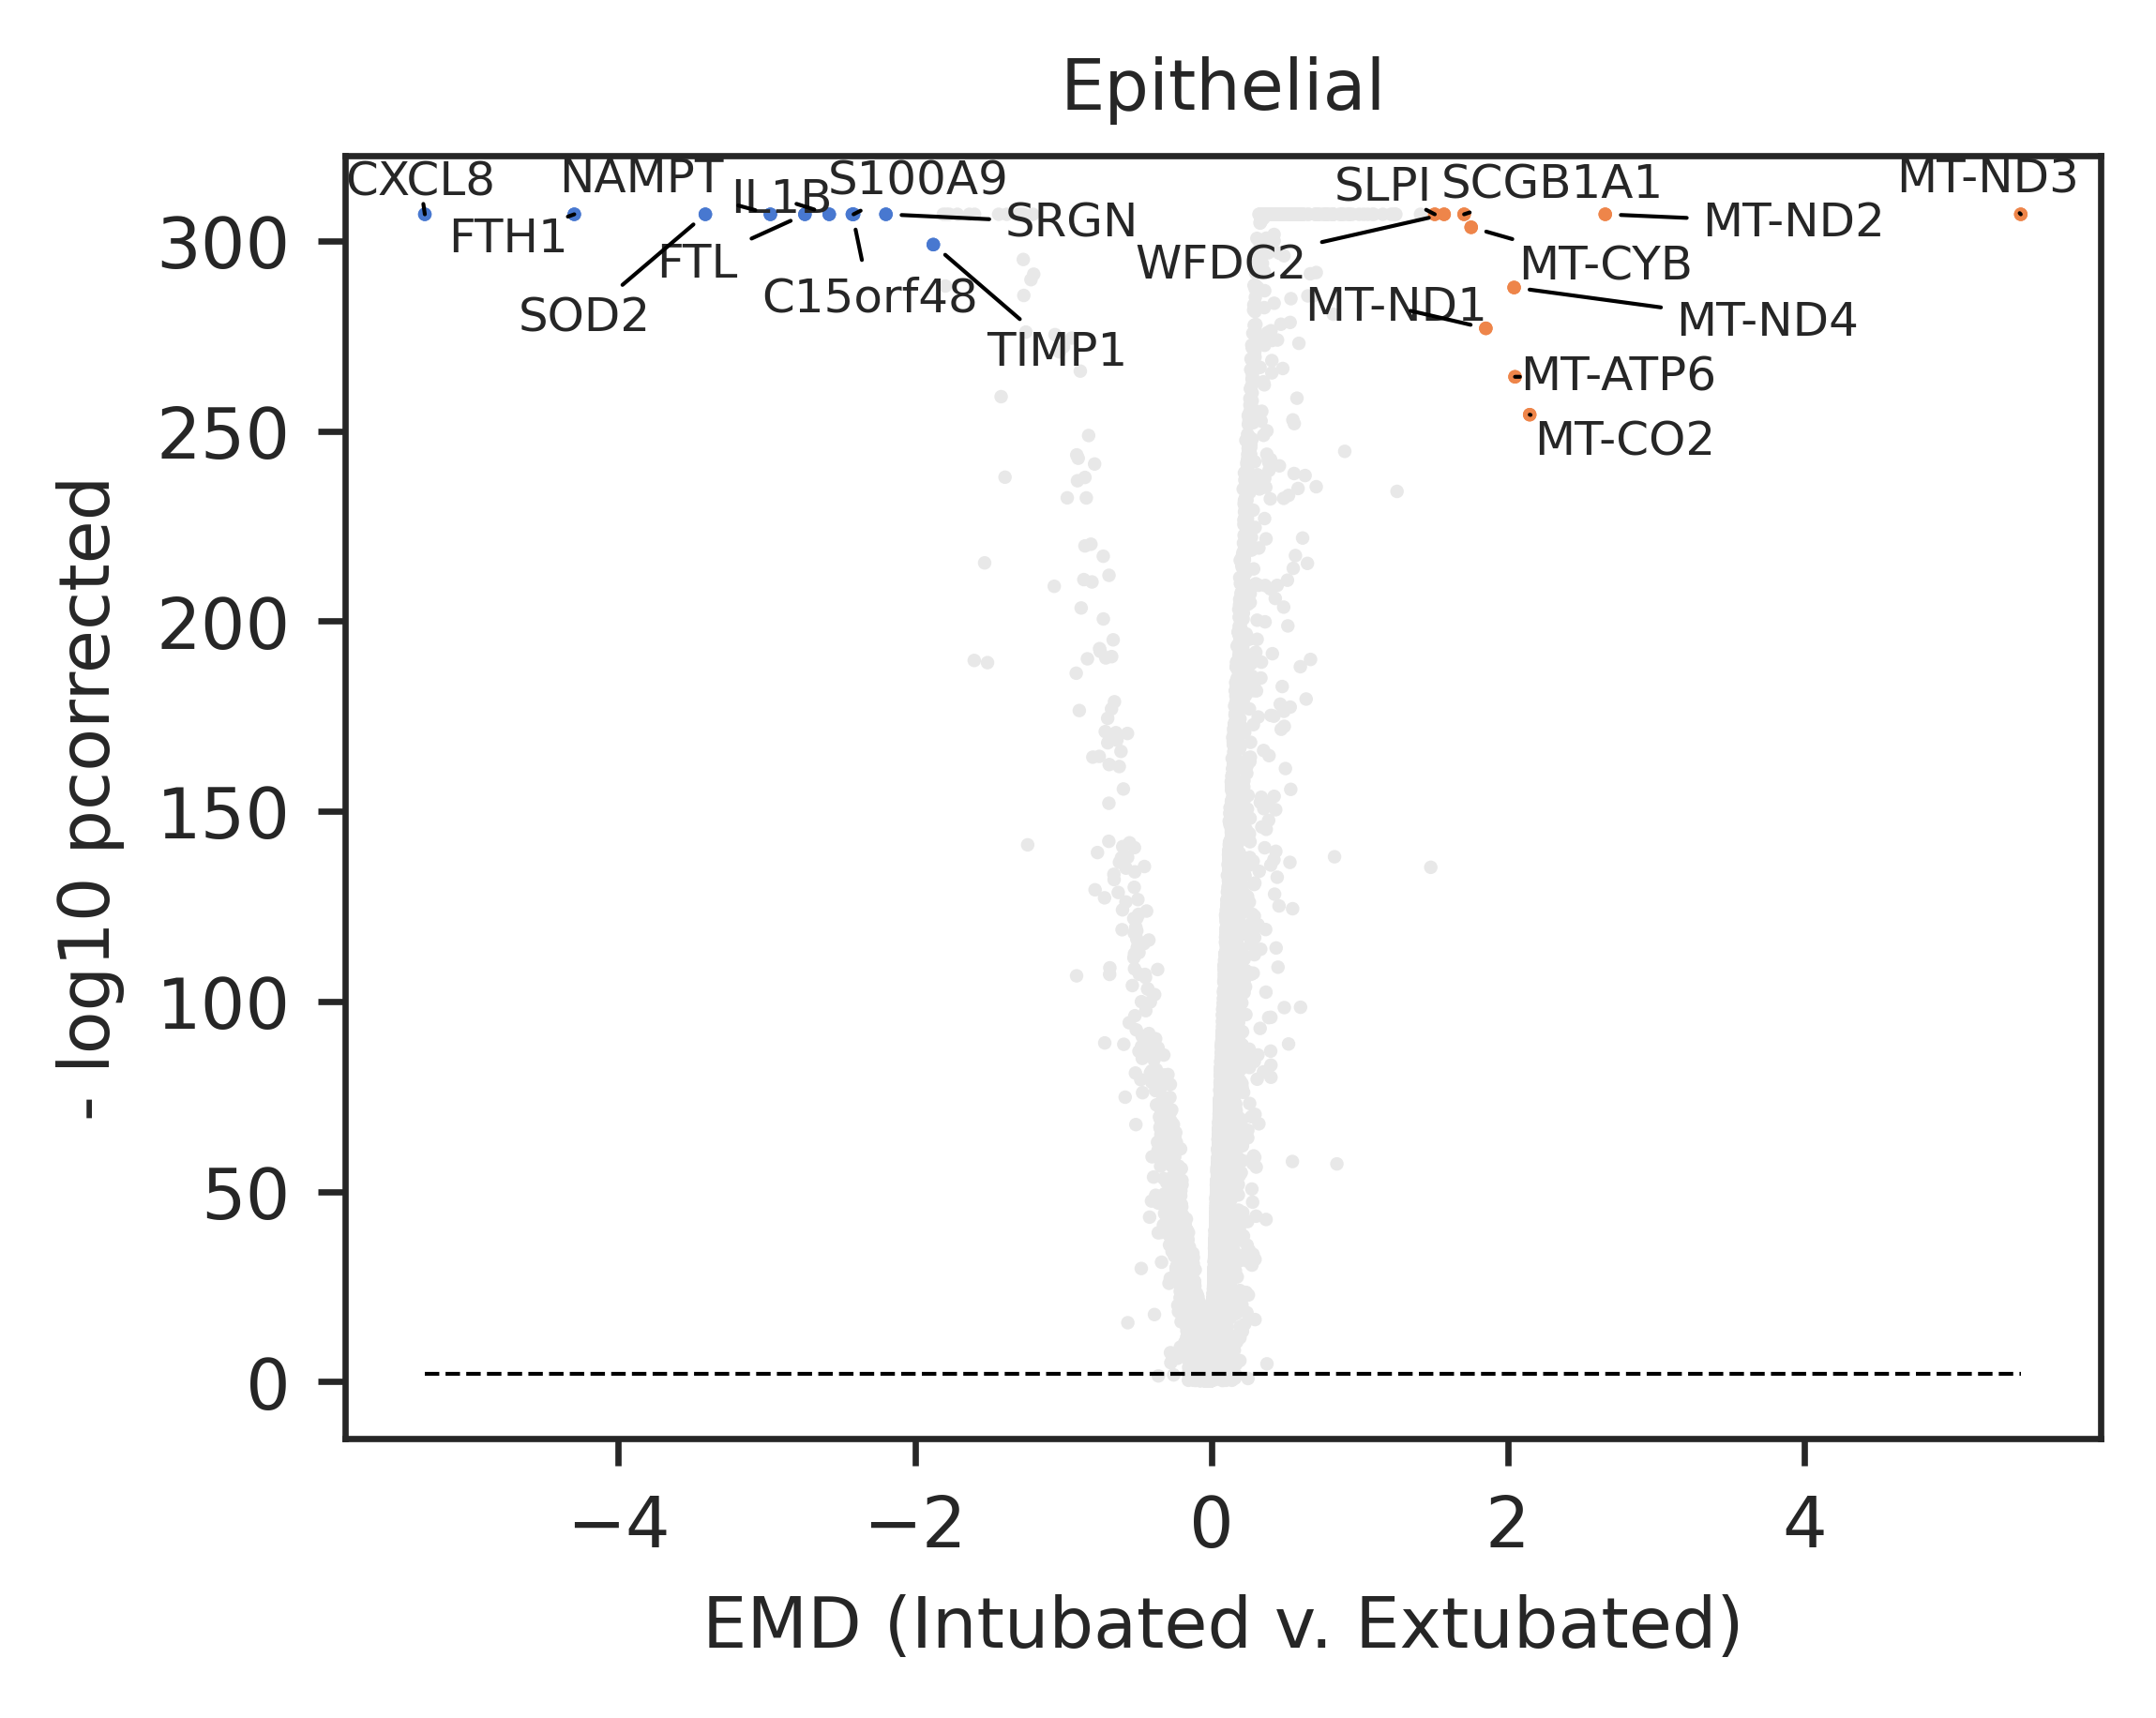

In [64]:
# filter the dge a bit
fname = 'int1Vext1_epithelial'
t = 'covid1balf'
ctype = 'Epithelial'

if True:
    # load
    dge = pd.read_csv(os.path.join(pfp,'dge_'+fname+'.csv'))

# just work with plot of interest
dt = dge.loc[dge['Cell type']==ctype,['Gene','nlog10pvalcorrected','emd', 'pval_corrected', 'log2FC']]

# drop scv2 transcript 
dt = dt.loc[dt['Gene']!='scv2_orf1-10',:]

# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'] = np.ceil(dt.loc[~dt['nlog10pvalcorrected'].isin([-np.inf, np.inf]), 'nlog10pvalcorrected'].max())

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()
    
genes_volcano = {fname:top10+bottom10}


    
## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval_corrected']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval_corrected']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Down'

## plot
fig,ax=plt.subplots(1,1,figsize=(4,3))
p2=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
p2top=sns.scatterplot(x='emd',y='nlog10pvalcorrected',
                  data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
ax.plot([dt['emd'].min(),dt['emd'].max()],
        (-1)*np.log10([0.01,0.01]),
        'k--',lw=0.5) # BH cut off
ax.set(xlabel='EMD (Intubated v. Extubated)',ylabel='- log10 pcorrected', title=ctype)



idx_g={}
for g in genes_volcano[fname]: # match fname with dict key
    idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

texts = [ax.text(dt['emd'][i],dt['nlog10pvalcorrected'][i],g,fontsize=6) for g,i in idx_g.items()]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'volcano_{}_{}.pdf'.format(fname,ctype)),dpi=300, bbox_inches='tight')




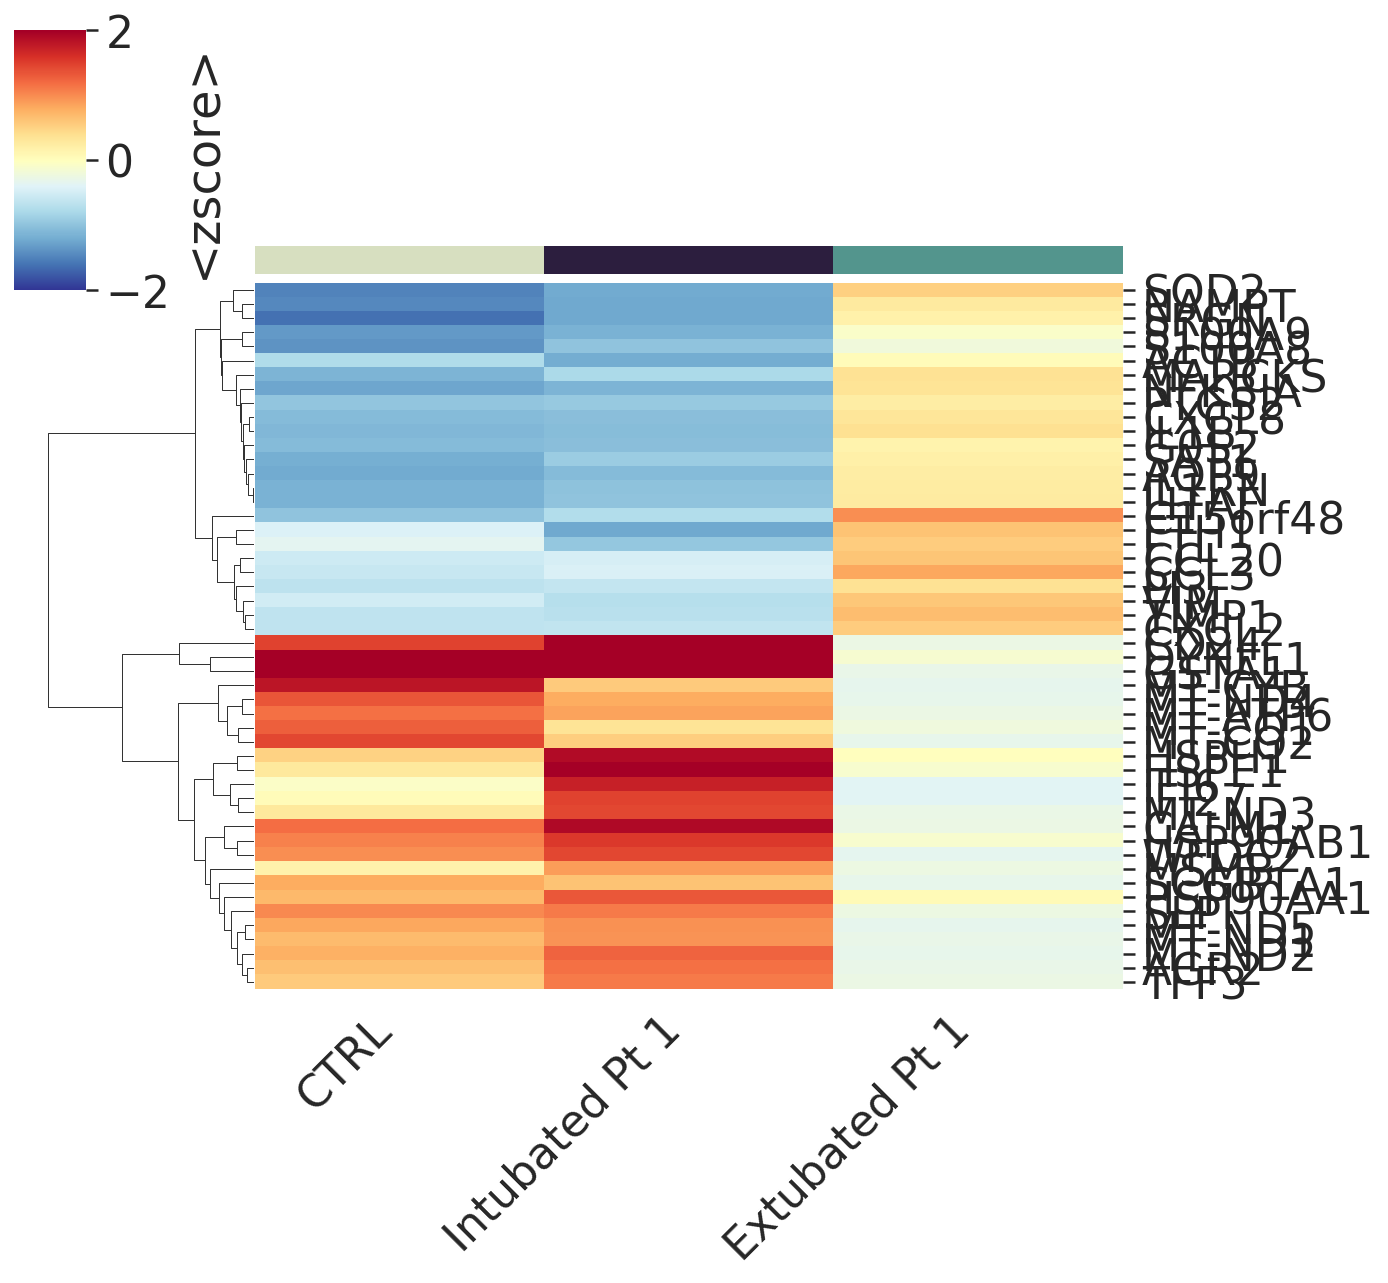

In [22]:
# HEATMAP

# grab top25 up and down (assume dt sorted)
cluster = 'grouped_ctype'
n = 25
topn = dt['Gene'][0:n].to_list()
bottomn = dt['Gene'][-n:].to_list()
    
genes_heatmap = {fname:topn+bottomn}

# construct dataframe
X = pd.DataFrame(np.asarray(adata[:,genes_heatmap[fname]].X.todense()), 
                columns=genes_heatmap[fname])
X['Cell type'] = adata.obs[cluster].astype(str).to_list()
X['Condition'] = adata.obs['Condition'].astype(str).to_list()

x = X
x.loc[:,genes_heatmap[fname]] = zscore(x.loc[:,genes_heatmap[fname]])
x = x.loc[x['Cell type']==ctype,:]

if False:
    x['Condition'] = x['Condition'].astype('category')
    x = x.sort_values(by='Condition')

if False:
    # original
    ave_zscore = x.groupby(['Cell type','Condition']).mean().T
else:
    ave_zscore = x.groupby(['Condition']).mean().T    
    
order = ['CTRL', 'Intubated Pt 1', 'Extubated Pt 1',]

for i in order:
    if i not in ave_zscore.columns.to_list():
        ave_zscore[i] = np.nan

#### MODIFY manually
ave_zscore = ave_zscore[order]


p = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
#     figsize=(2,8),
    cbar_kws={'label':'<zscore>','ticks':[-2,0,2]},
    row_cluster=True,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=col_colors,
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
    vmin=-2,vmax=2,
)
p.ax_heatmap.set_xticklabels(p.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
p.ax_heatmap.set_xlabel('')
if True:
    p.savefig(os.path.join(pfp,'heatmap_top25updown_{}_{}.pdf'.format(fname,ctype)),dpi=300,bbox_inches='tight')

## Additional genes

In [23]:
genes = {'Ciliated-DGE':['MALAT1','SCGB1A1','JUN','S100A2','SOX4','SCGB3A1','SERPINB3',
                         'NFKBIA','EGR1','FOS','HES1','TXNIP','PMAIP1','SQSTM1',
                         'ATF3','TMEM190','LGALS3','TSPAN1','C20orf85','C9orf24',
                         'TUBA1A','GSTP1','DYNLL1','HSP90AA1','FTH1','PRDX5',
                         'TUBB4B','S100A11','CAPS','S100A6'],
         }
marker_check(genes, adata)


All markers in data.


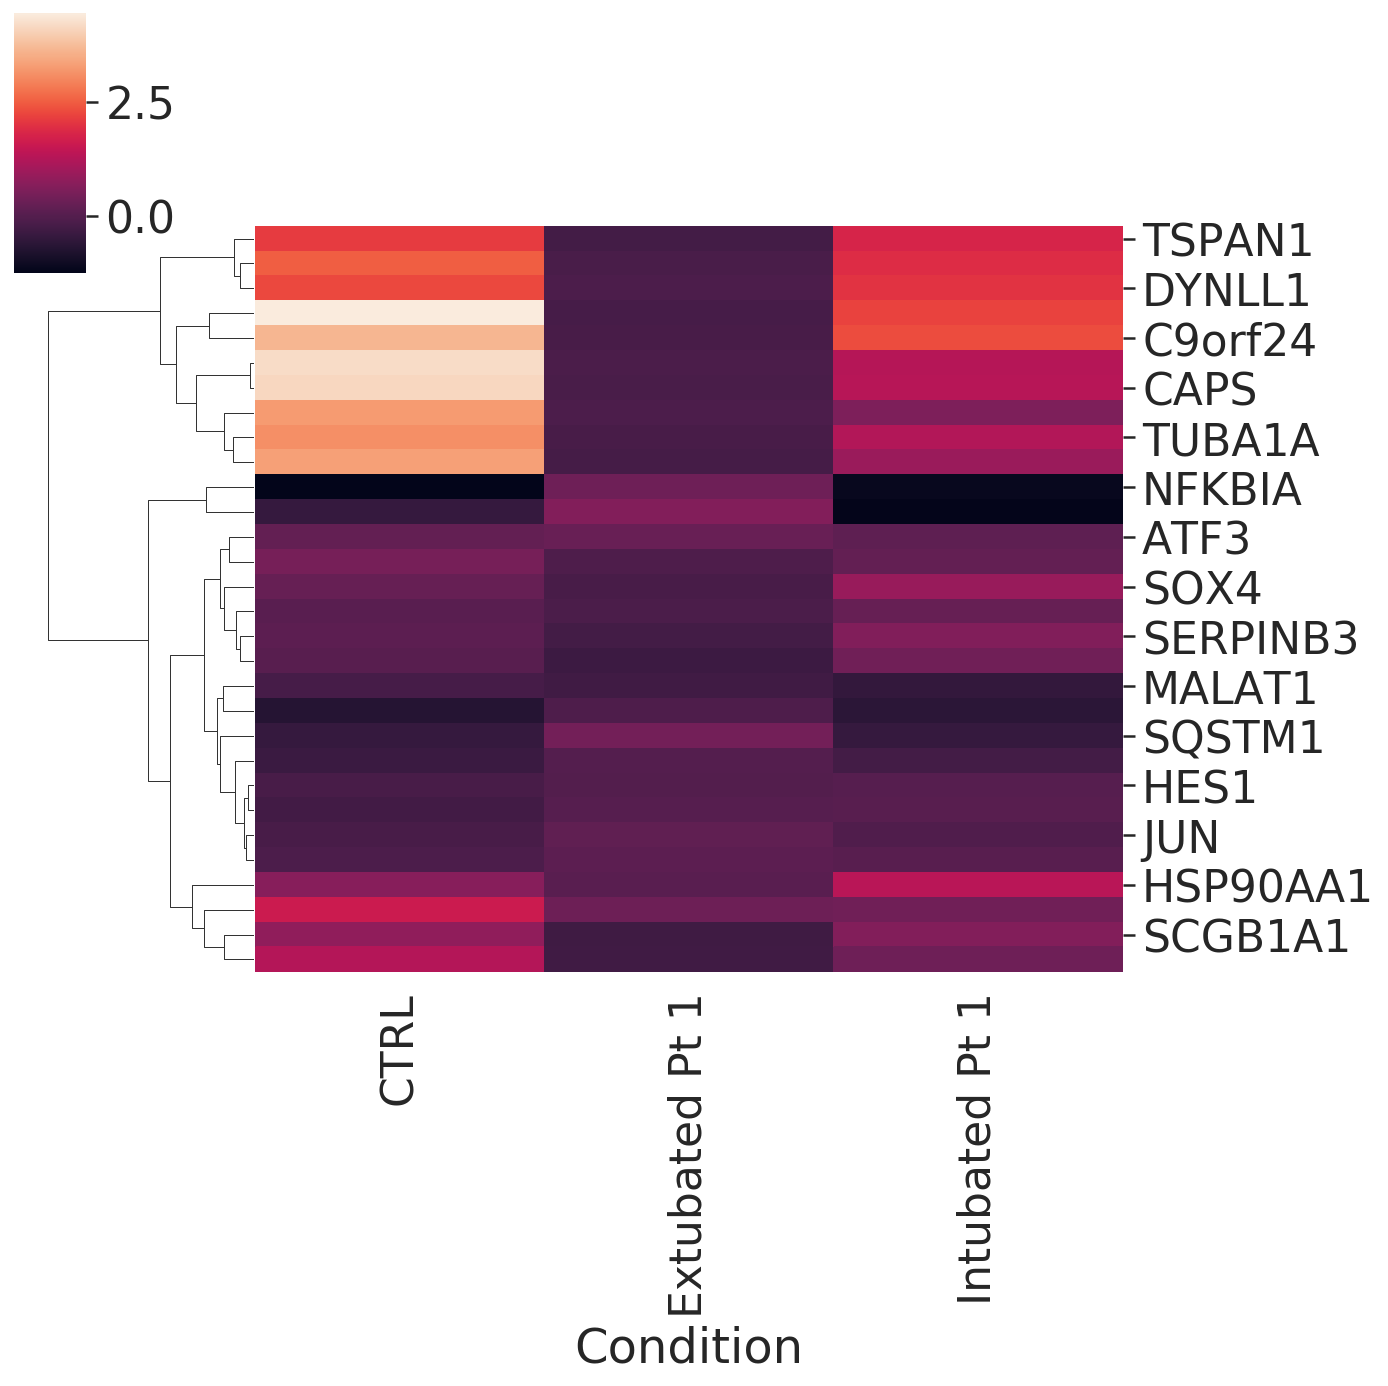

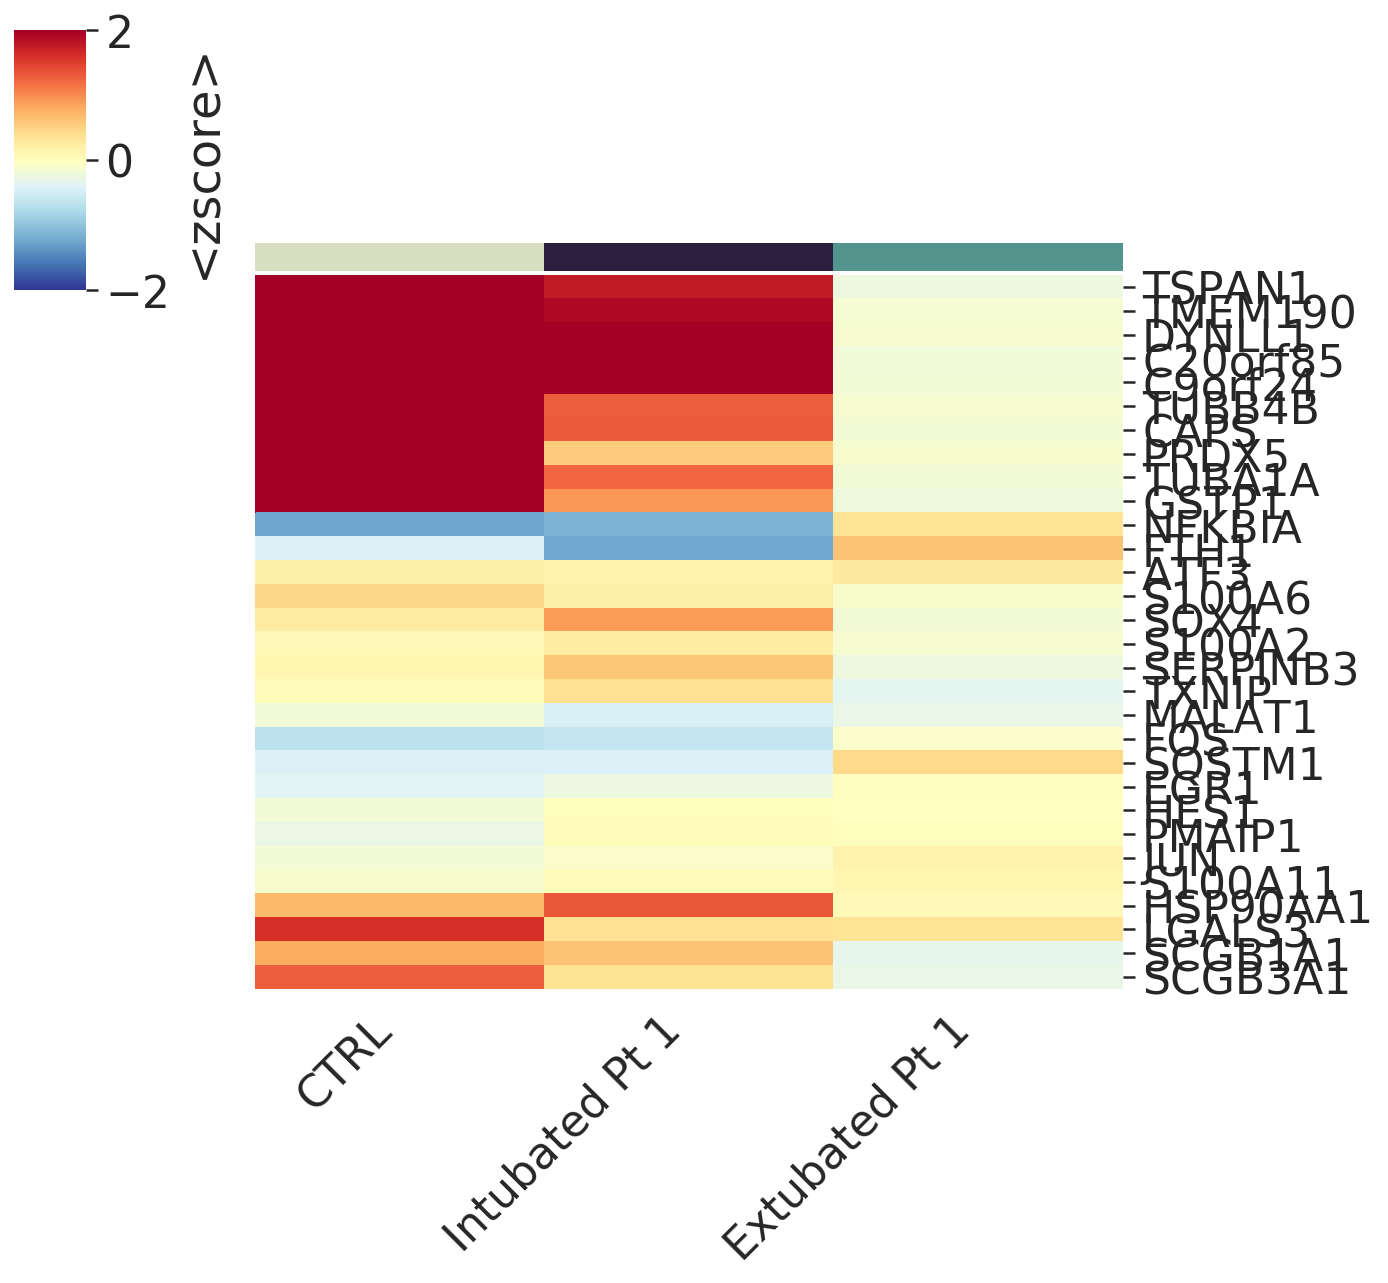

In [29]:


for ctype in ['Epithelial']: #[None]
    # aesthetics
    pal = sns.cubehelix_palette(3,start=.5, rot=-.75)
#     col_colors = [pal[0]] + ['white'] + 2*[pal[1]] + ['white'] + 2*[pal[2]]

    for fname in genes.keys():
        # construct dataframe
        X = pd.DataFrame(np.asarray(adata[:,genes[fname]].X.todense()), 
                        columns=genes[fname])
        X['Cell type'] = adata.obs['grouped_ctype'].astype(str).to_list()
        X['Condition'] = adata.obs['Condition'].astype(str).to_list()

        x = X
        x.loc[:,genes[fname]] = zscore(x.loc[:,genes[fname]])
        x = x.loc[x['Cell type']==ctype,:]

        if False:
            # sort alphabetically
            x['Condition'] = x['Condition'].astype('category')
            x = x.sort_values(by='Condition')

        if True:
            ave_zscore = x.groupby(['Condition']).mean().T
        else:
            ave_zscore = x.groupby(['Cell type','Condition']).mean().T

        # drop na 
        ave_zscore = ave_zscore.dropna()
        # get cluster order 
        p0 = sns.clustermap(
            ave_zscore,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            col_linkage=None,
        )
        ave_zscore = ave_zscore.reindex(ave_zscore.index[p0.dendrogram_row.reordered_ind])
        
#         order = ['CTRL', 'Extubated Pt 1',  'Extubated Pt 2', 'Intubated Pt 1', 'Intubated Pt 2']
        order = ['CTRL', 'Intubated Pt 1', 'Extubated Pt 1']
        
        for i in order:
            if i not in ave_zscore.columns.to_list():
                ave_zscore[i] = np.nan

        #### MODIFY manually
        ave_zscore = ave_zscore[order]
        if False:
            # insert gaps 
            ave_zscore['1'] = np.nan
            ave_zscore['2'] = np.nan
            ave_zscore = ave_zscore[['CTRL', '1',
                                     'Extubated Pt 1', 
                                     '2','Intubated Pt 1']]

        p = sns.clustermap(
            ave_zscore,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
        #     figsize=(2,8),
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            col_linkage=None,
            row_colors=None,
            col_colors=col_colors,
            mask=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            cbar_kws={'label':'<zscore>','ticks':[-2,0,2]},
            vmin=-2,vmax=2,
        )
#         p.ax_heatmap.set_xticklabels(['CTRL', '',
#                                      'Extubated Pt 1',  
#                                      '','Intubated Pt 1'], rotation=45, ha='right')
        p.ax_heatmap.set_xticklabels(order, rotation=45, ha='right')
        p.ax_heatmap.set_xlabel('')
        if True:
            p.savefig(os.path.join(pfp,'heatmap_{}_{}.pdf'.format(fname.replace(' ',''),ctype.replace('/','-'))),dpi=300,bbox_inches='tight')

### Contrast with ciliated hbec

In [127]:
# ave_zscore for hbec
ctype = 'Epithelial'
fname = 'Ciliated-DGE'

# construct dataframe
X = pd.DataFrame(np.asarray(adata[:,genes[fname]].X.todense()), 
                columns=genes[fname])
X['Cell type'] = adata.obs['grouped_ctype'].astype(str).to_list()
X['Condition'] = adata.obs['Condition'].astype(str).to_list()

# compute zscore on all data
X.loc[:,genes[fname]] = zscore(X.loc[:,genes[fname]])

if ctype is None:
    x = X
else:
    x = X.loc[X['Cell type']==ctype,:]

if False:
    # sort alphabetically
    x['Condition'] = x['Condition'].astype('category')
    x = x.sort_values(by='Condition')

if True:
    ave_zscore = x.groupby(['Condition']).mean().T
else:
    ave_zscore = x.groupby(['Cell type','Condition']).mean().T


In [128]:
ave_zscore_rp = ave_zscore

In [129]:
hdata.obs['Infected'] = hdata.obs['scv2_10+'].map({1:'Infected',0:'Bystander'})
hdata.obs.loc[hdata.obs['Condition']=='Mock', 'Infected'] = 'Mock'

In [130]:
# ave_zscore for hbec
ctype = 'Ciliated cells'
fname = 'Ciliated-DGE'

# construct dataframe
X = pd.DataFrame(np.asarray(hdata[:,genes[fname]].X.todense()), 
                columns=genes[fname])
X['Cell type'] = hdata.obs['ctype'].astype(str).to_list()
X['Infected'] = hdata.obs['Infected'].astype(str).to_list()

# compute zscore before subsetting
X.loc[:,genes[fname]] = zscore(X.loc[:,genes[fname]])

if ctype is None:
    x = X
else:
    x = X.loc[X['Cell type']==ctype,:]

if True:
    ave_zscore = x.groupby(['Infected']).mean().T
else:
    ave_zscore = x.groupby(['Cell type','Infected']).mean().T


In [131]:
ave_zscore_hbec = ave_zscore

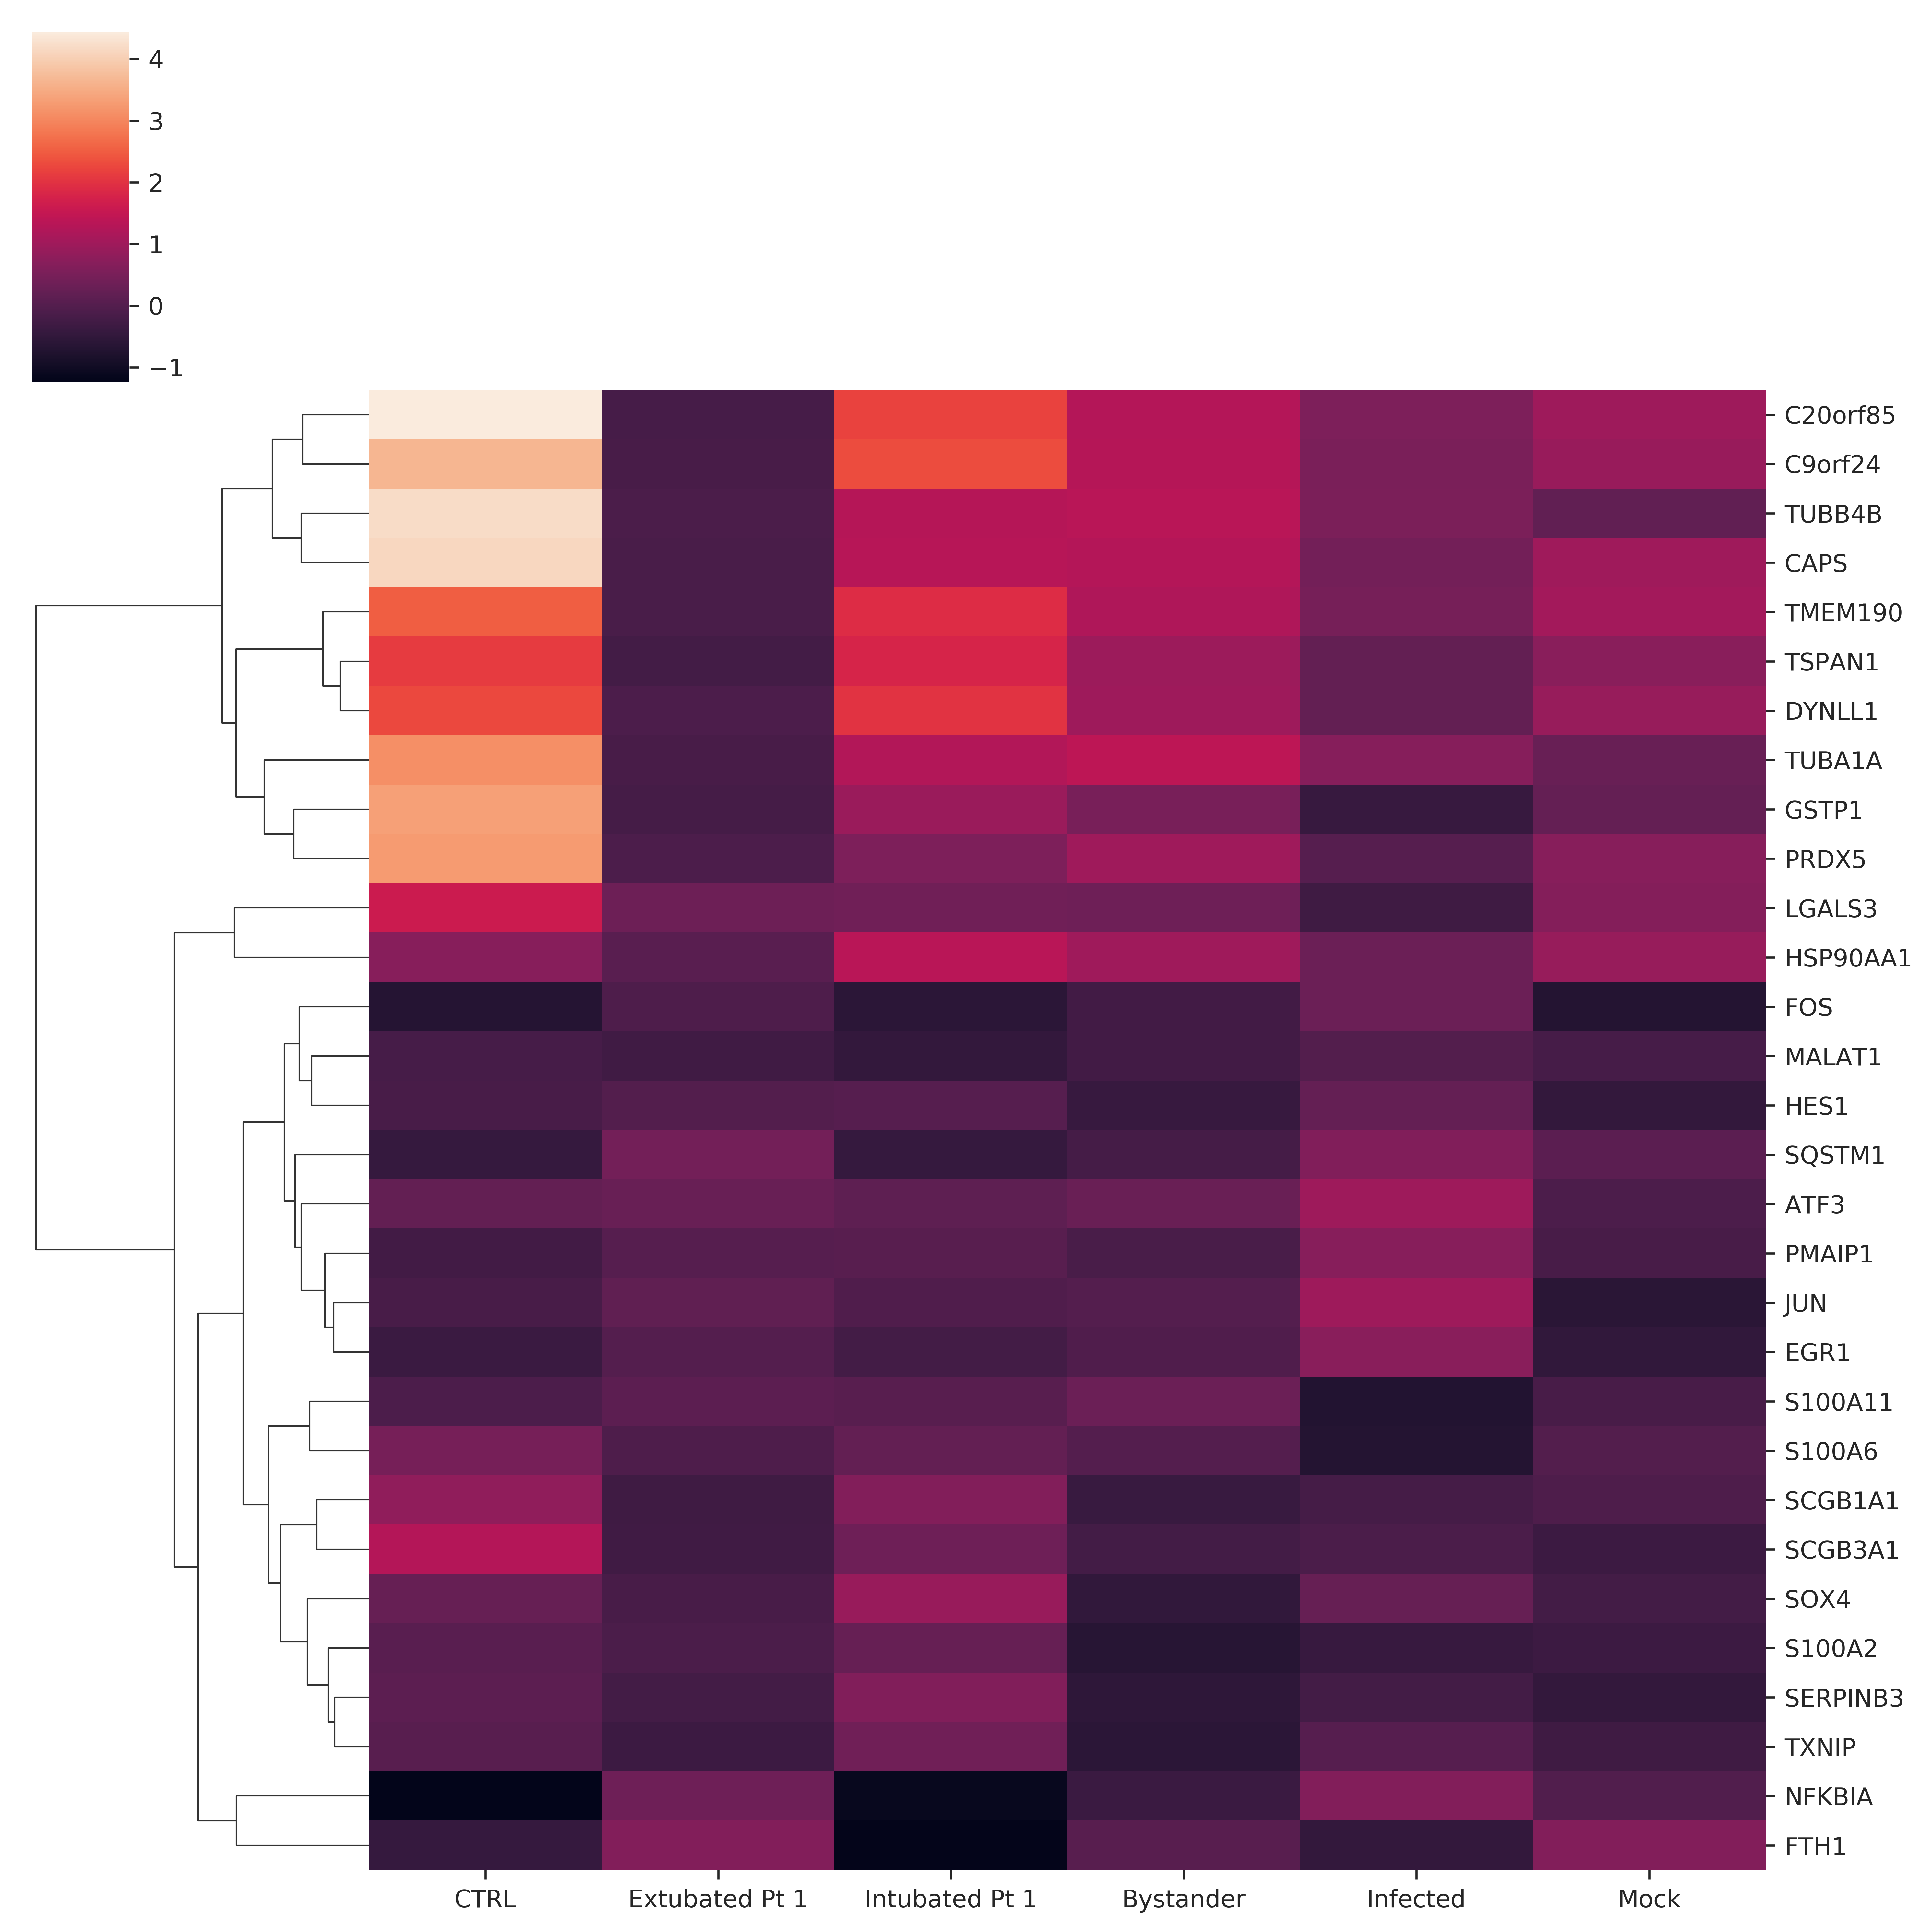

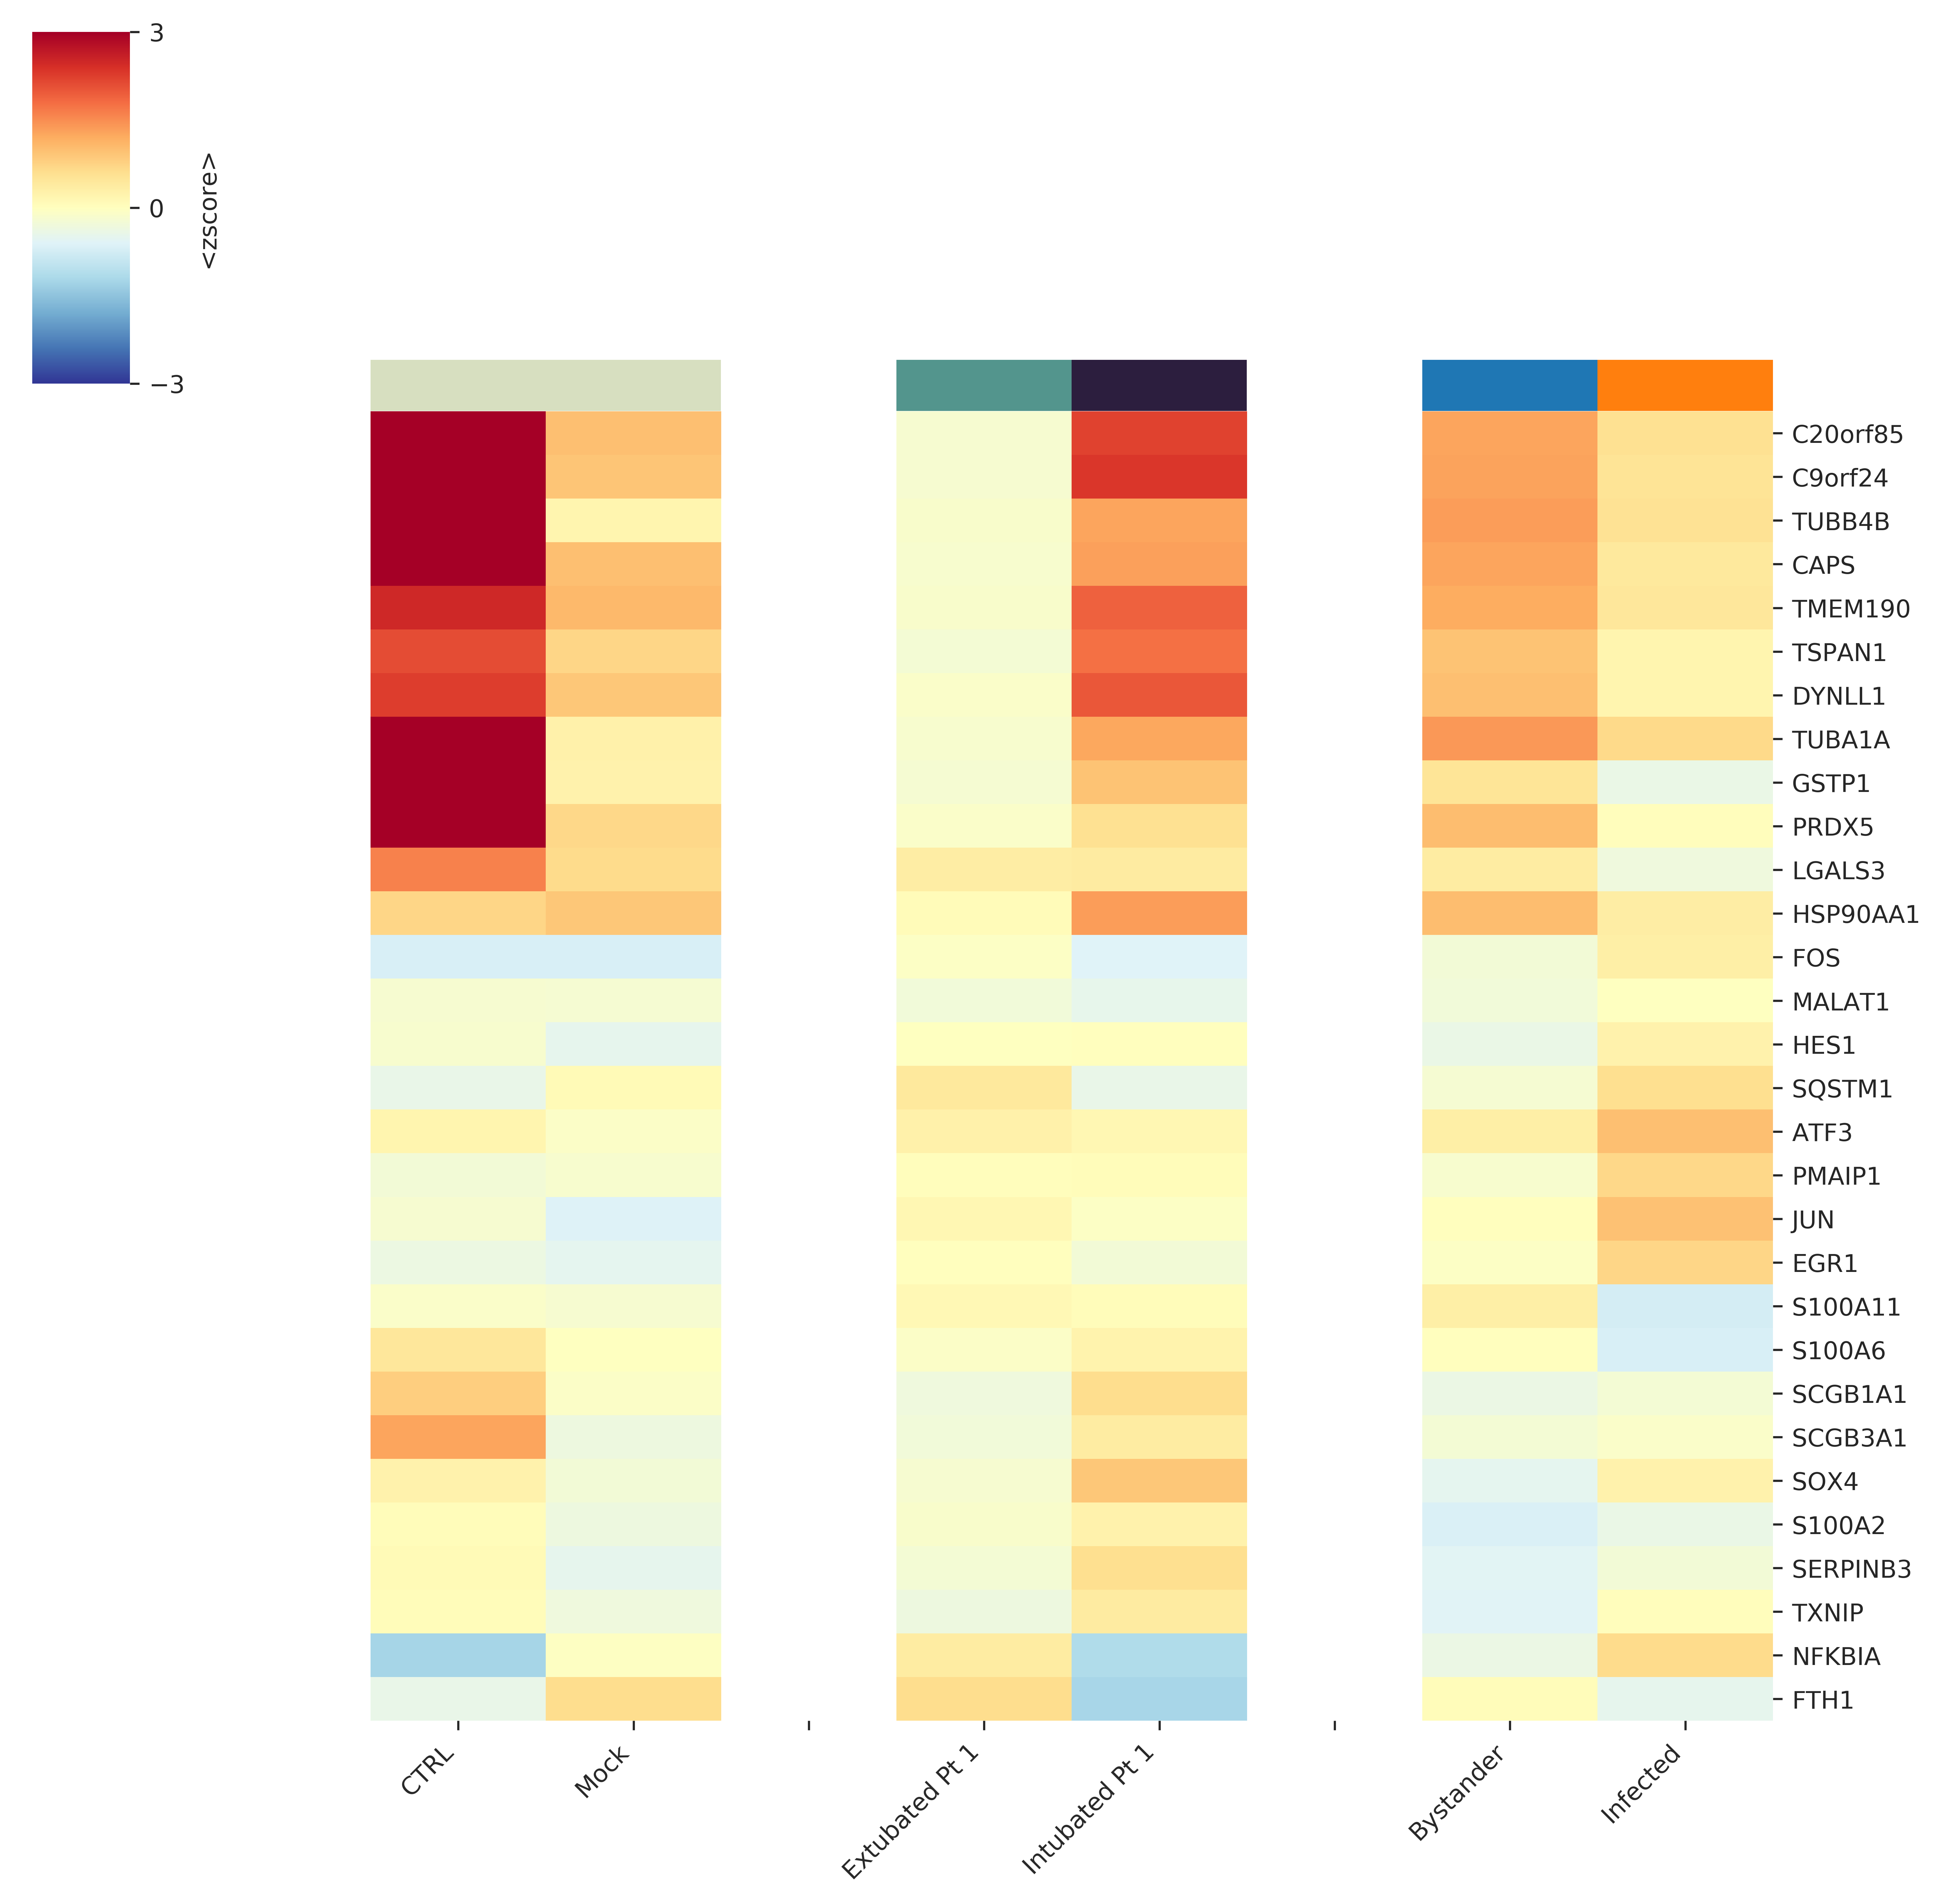

In [132]:
# plot

# rearrange
ave_zscore = pd.concat([ave_zscore_rp, ave_zscore_hbec], axis=1)

# aesthetics
pal = sns.cubehelix_palette(3,start=.5, rot=-.75) + sns.color_palette()
col_colors = [pal[0]] + [pal[0]] + ['white'] + [pal[1]] + [pal[2]] + ['white'] + [pal[3]] + [pal[4]]

p0 = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    row_cluster=True,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
)
ave_zscore = ave_zscore.reindex(ave_zscore.index[p0.dendrogram_row.reordered_ind])

order = ['CTRL', 'Mock', 'Extubated Pt 1', 'Intubated Pt 1', 'Bystander', 'Infected']

for i in order:
    if i not in ave_zscore.columns.to_list():
        ave_zscore[i] = np.nan

#### MODIFY manually
ave_zscore = ave_zscore[order]
if True:
    # insert gaps 
    ave_zscore['1'] = np.nan
    ave_zscore['2'] = np.nan
    ave_zscore = ave_zscore[['CTRL', 'Mock', '1', 'Extubated Pt 1', 'Intubated Pt 1', '2', 'Bystander', 'Infected']]

p = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
#     figsize=(2,8),
    row_cluster=False,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=col_colors,
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
    cbar_kws={'label':'<zscore>','ticks':[-3,0,3]},
    vmin=-3,vmax=3,
)
p.ax_heatmap.set_xticklabels(['CTRL', 'Mock', '', 'Extubated Pt 1', 'Intubated Pt 1', '', 'Bystander', 'Infected'], rotation=45, ha='right')
p.ax_heatmap.set_xlabel('')

if True:
    p.savefig(os.path.join(pfp,'heatmap_{}_{}.pdf'.format(fname.replace(' ',''),ctype.replace('/','-').replace(' ', ''))),dpi=300,bbox_inches='tight')

#### Compare immune + SCV2 genes of interest in this way

In [137]:
genes = {'Ciliated-DGE':['MALAT1','SCGB1A1','JUN','S100A2','SOX4','SCGB3A1','SERPINB3',
                         'NFKBIA','EGR1','FOS','HES1','TXNIP','PMAIP1','SQSTM1',
                         'ATF3','TMEM190','LGALS3','TSPAN1','C20orf85','C9orf24',
                         'TUBA1A','GSTP1','DYNLL1','HSP90AA1','FTH1','PRDX5',
                         'TUBB4B','S100A11','CAPS','S100A6'],
         'hbec_highlights':['IFNL1','IFNAR1','IFNLR1','IFI27','IFITM3','IFI6','IFIT1',
                             'MX1','ISG15','CCL2','CXCL9','CXCL10','CXCL11','CXCL16','IL1A','IL1B','IL1RN','IL6','IL10','TNF',
                            'ACE','ACE2','TMPRSS2','TMPRSS4','CTSL',
                          'CLTRN','DPP4','ANPEP'],
        }
marker_check(genes, adata)
marker_check(genes, hdata)

All markers in data.
All markers in data.


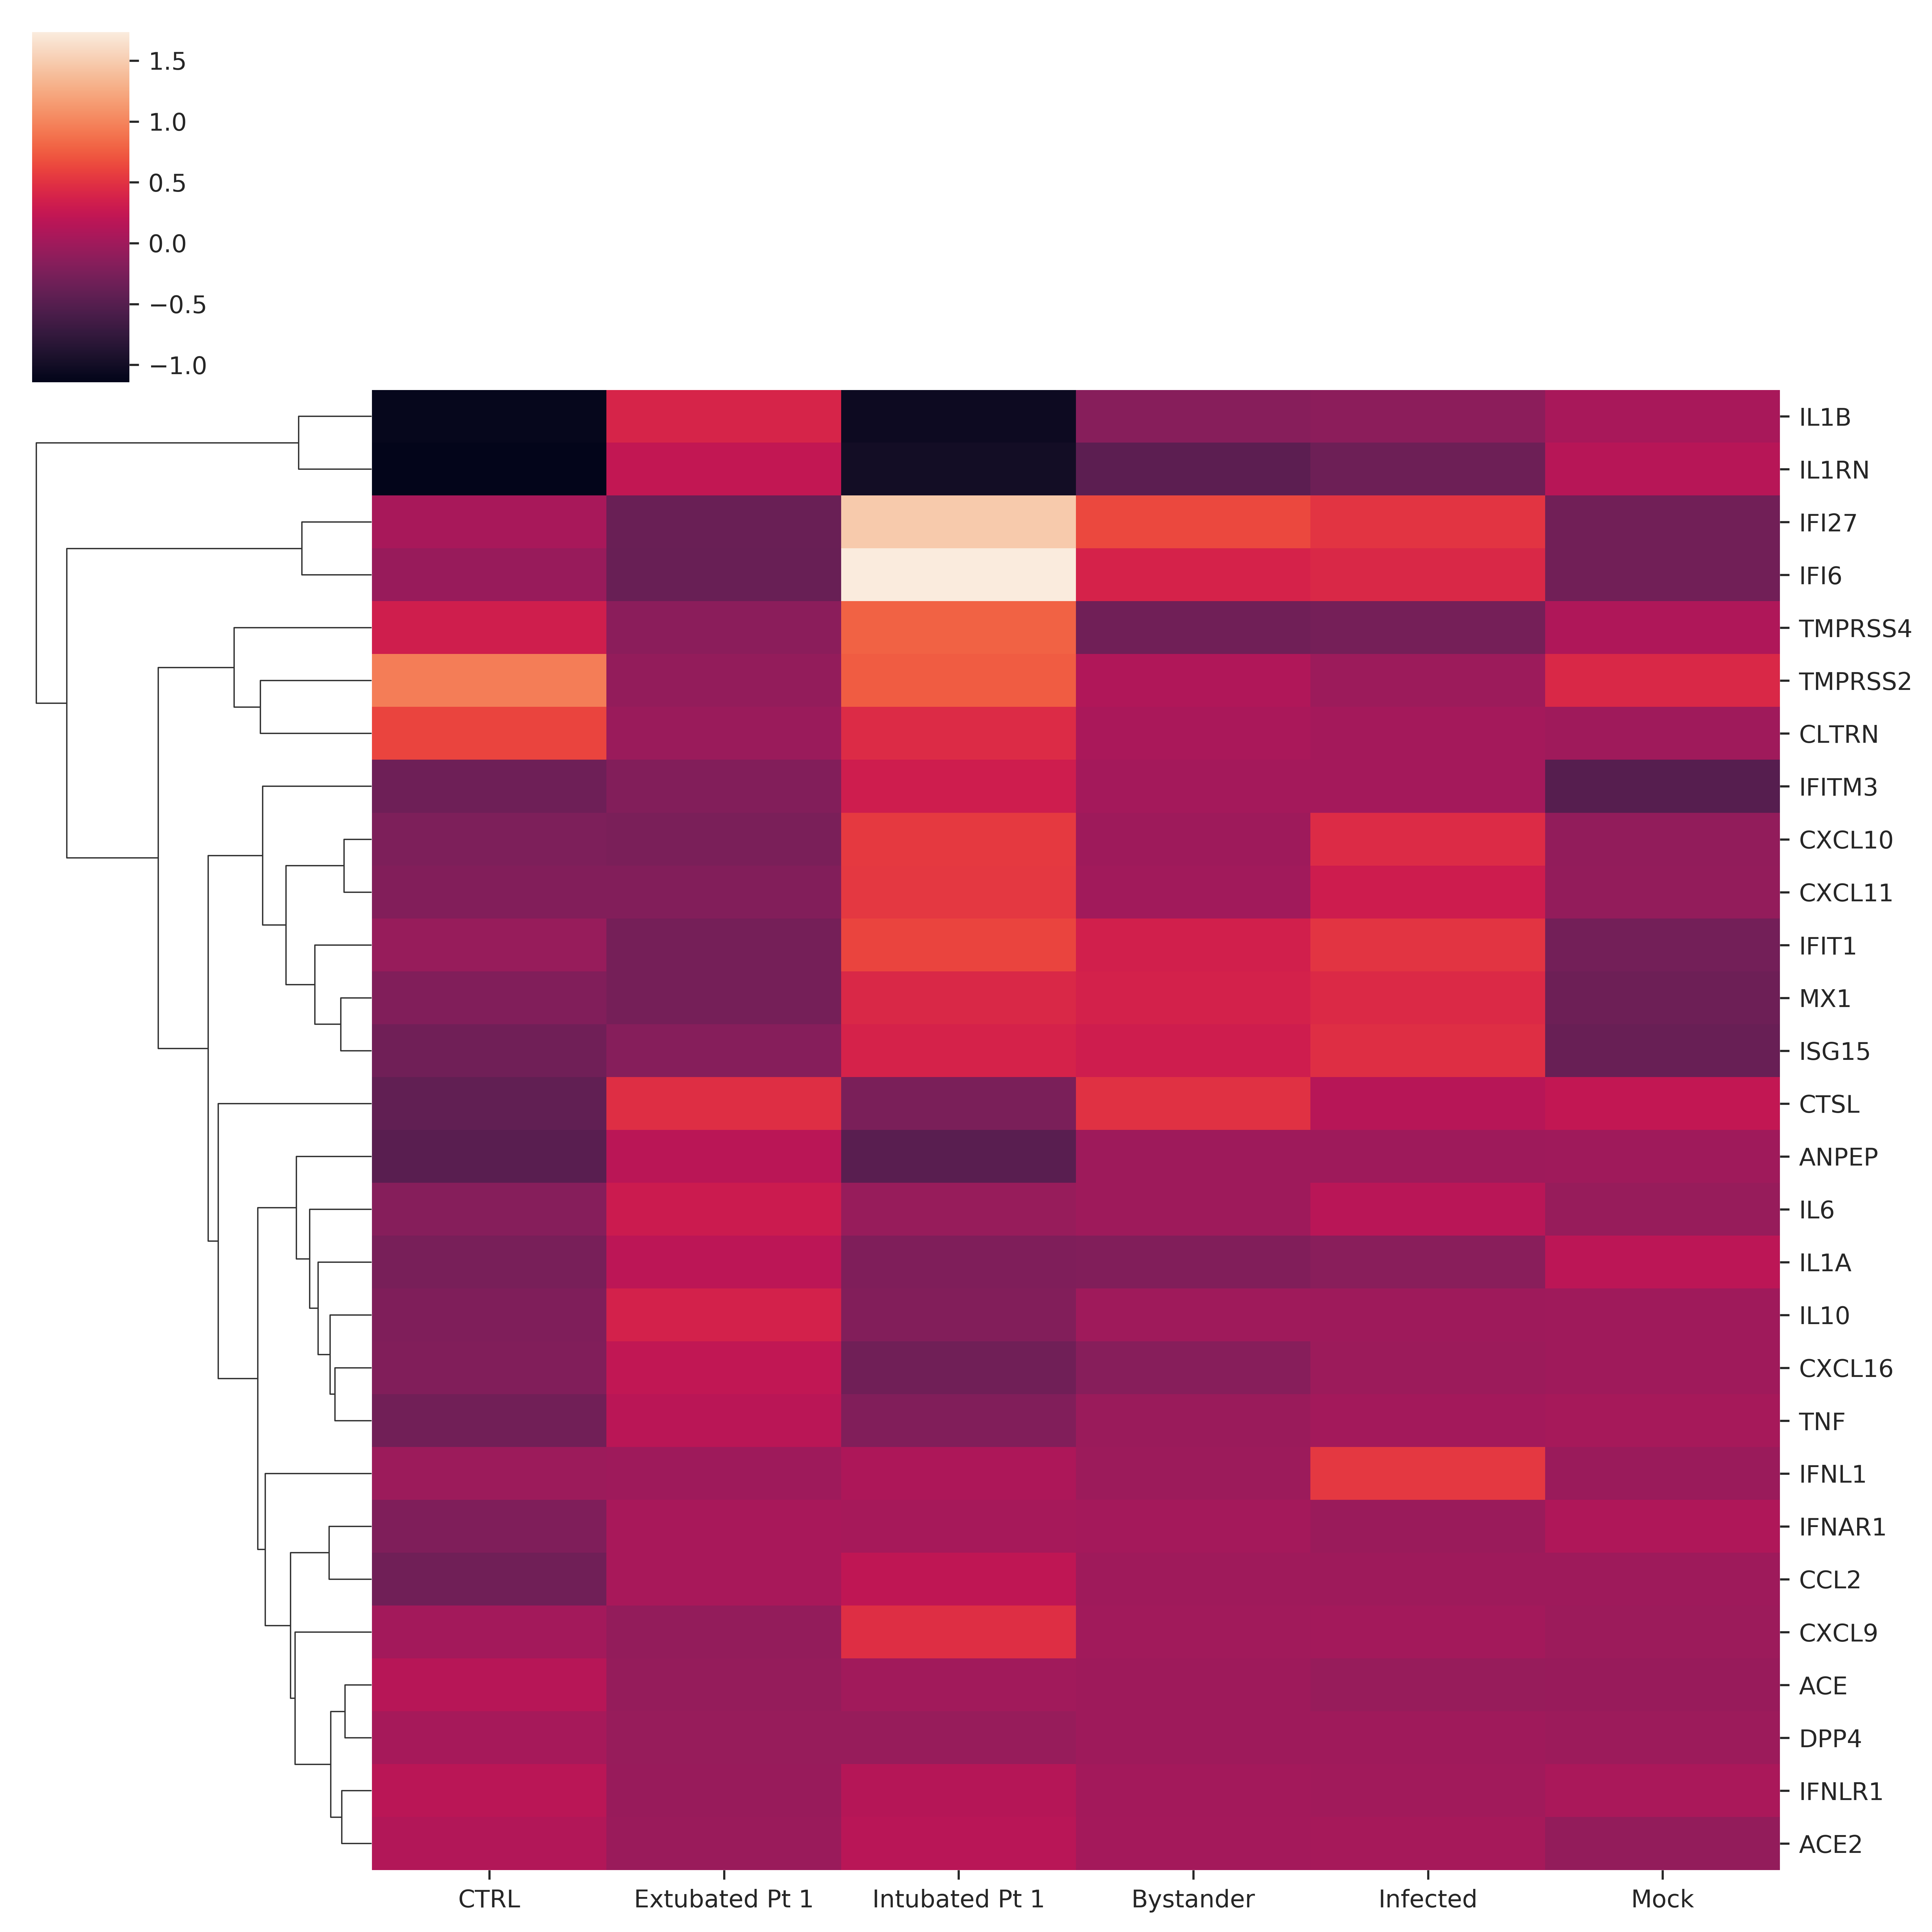

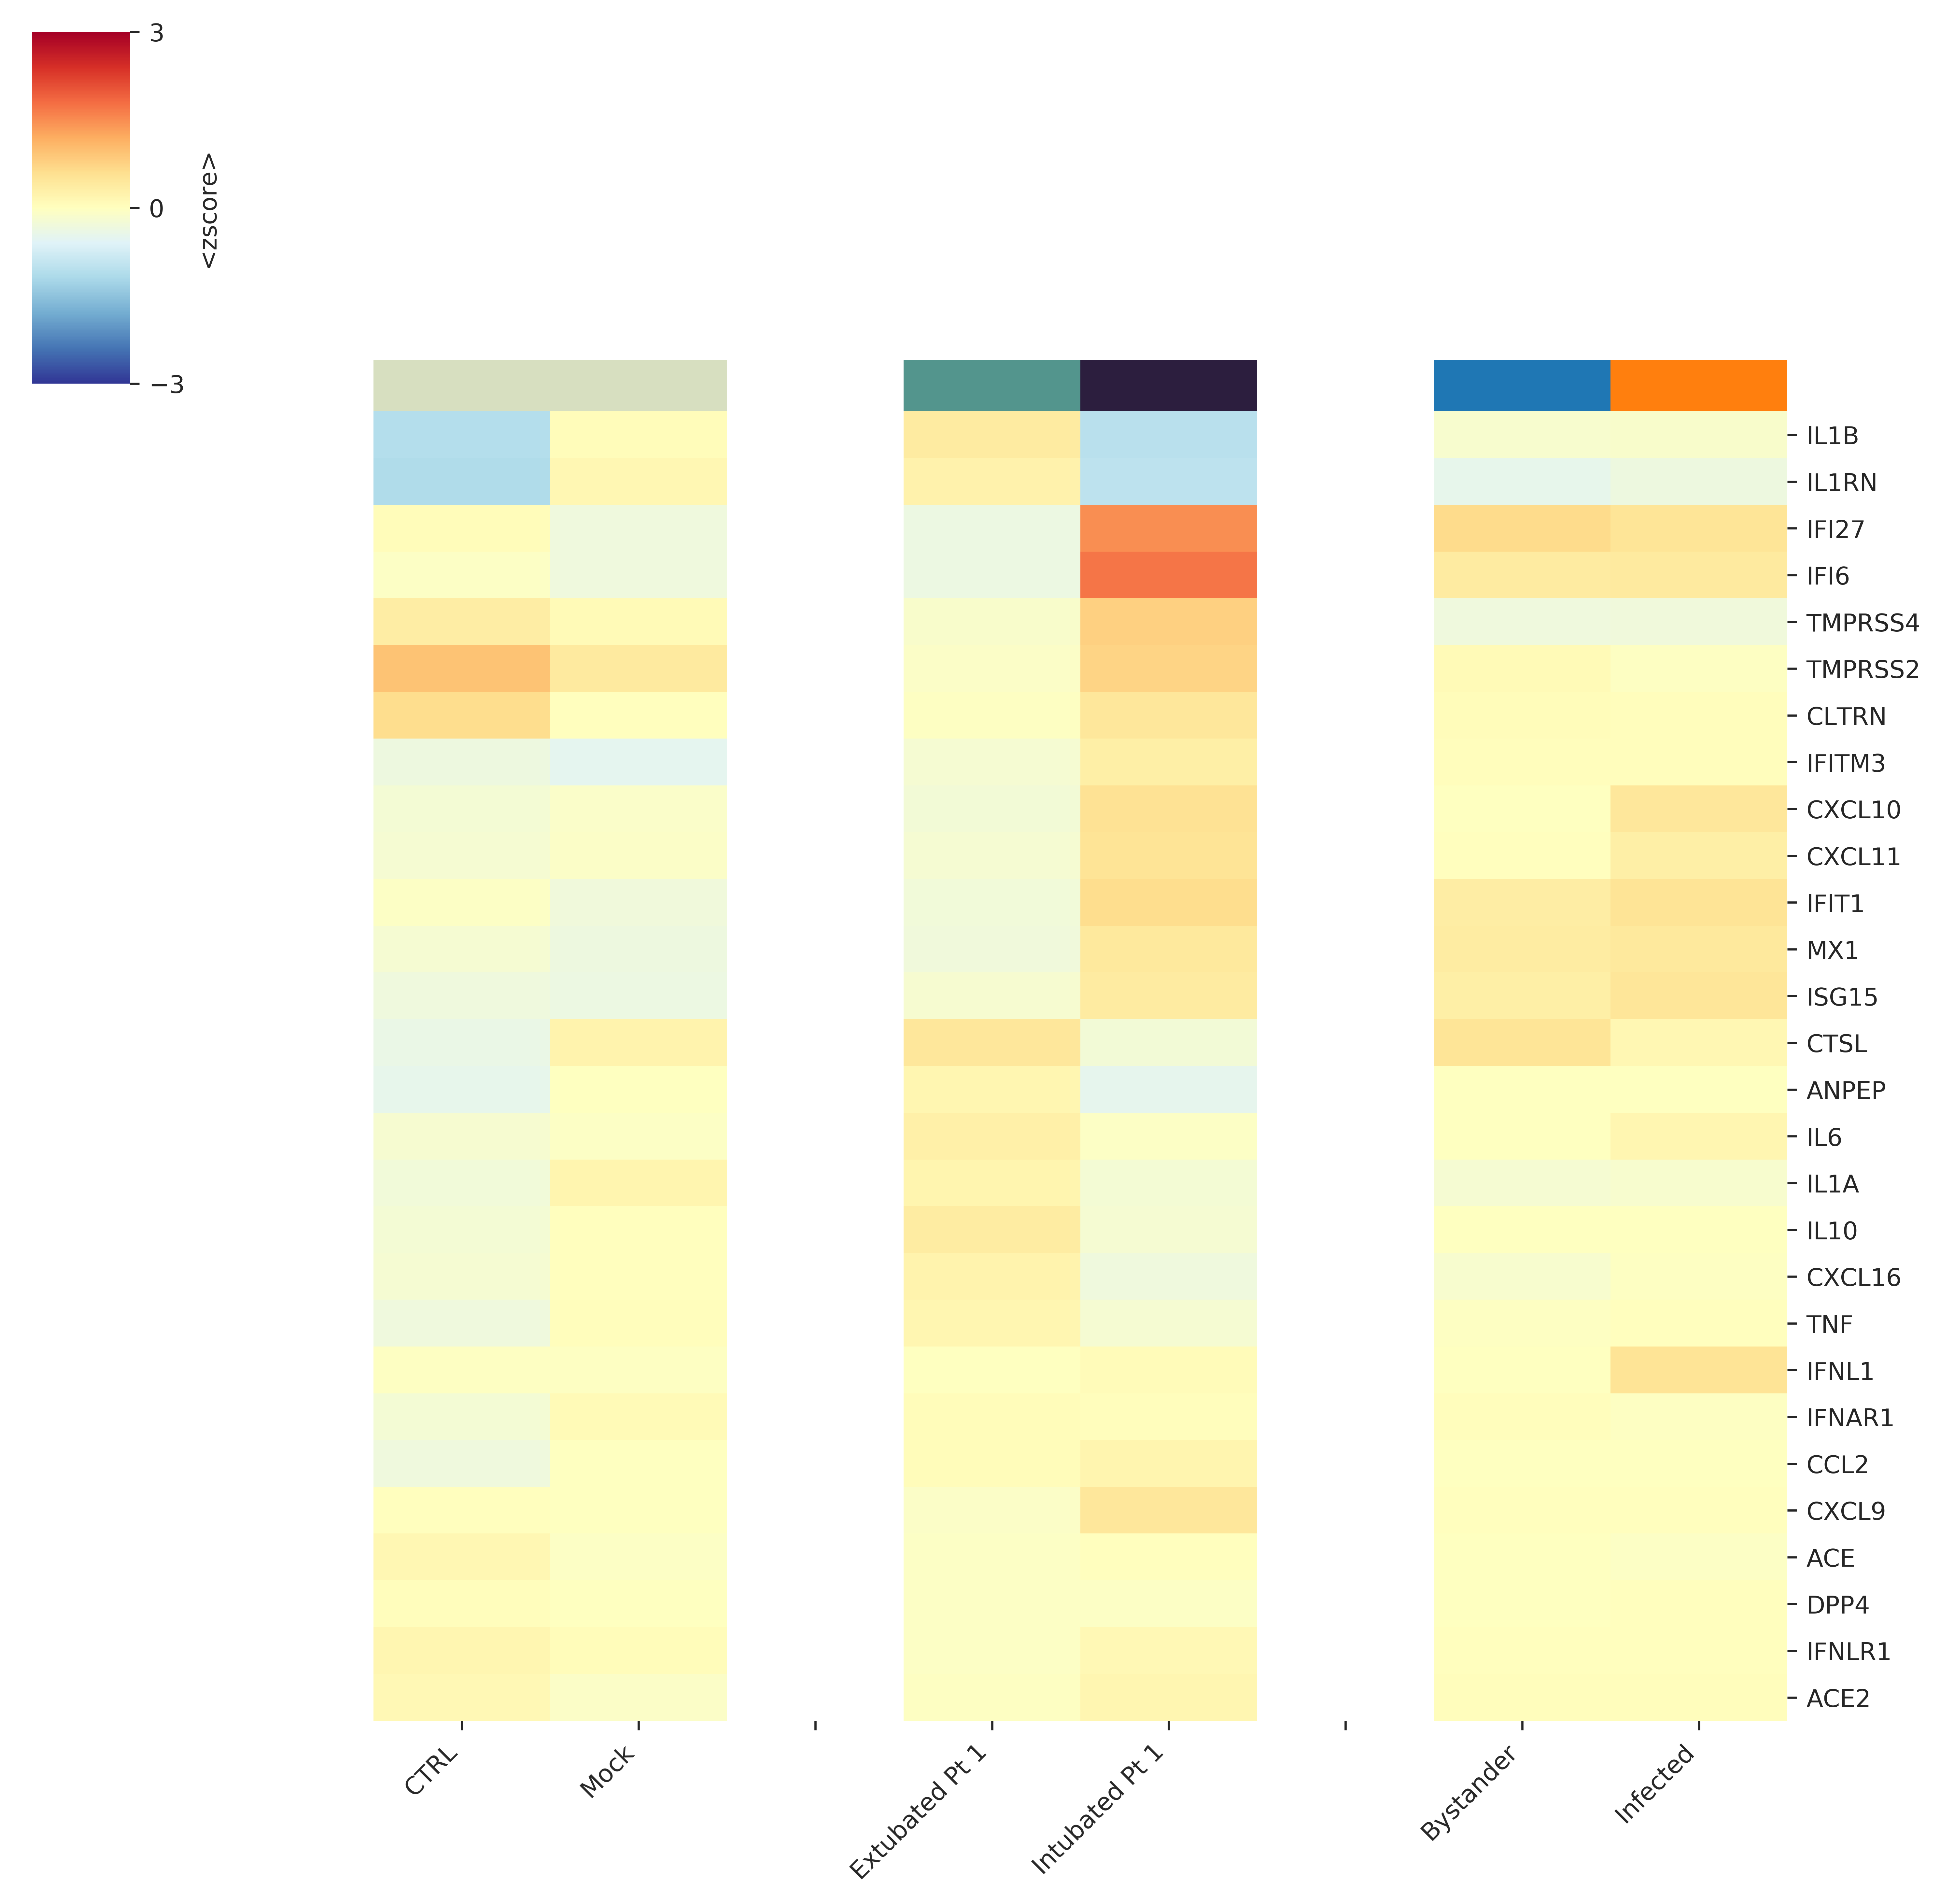

In [138]:
# ave_zscore for hbec
ctype = 'Epithelial'
fname = 'hbec_highlights'

# construct dataframe
X = pd.DataFrame(np.asarray(adata[:,genes[fname]].X.todense()), 
                columns=genes[fname])
X['Cell type'] = adata.obs['grouped_ctype'].astype(str).to_list()
X['Condition'] = adata.obs['Condition'].astype(str).to_list()

# compute zscore on all data
X.loc[:,genes[fname]] = zscore(X.loc[:,genes[fname]])

if ctype is None:
    x = X
else:
    x = X.loc[X['Cell type']==ctype,:]

if False:
    # sort alphabetically
    x['Condition'] = x['Condition'].astype('category')
    x = x.sort_values(by='Condition')

if True:
    ave_zscore = x.groupby(['Condition']).mean().T
else:
    ave_zscore = x.groupby(['Cell type','Condition']).mean().T
    
ave_zscore_rp = ave_zscore


# ave_zscore for hbec
ctype = 'Ciliated cells'

# construct dataframe
X = pd.DataFrame(np.asarray(hdata[:,genes[fname]].X.todense()), 
                columns=genes[fname])
X['Cell type'] = hdata.obs['ctype'].astype(str).to_list()
X['Infected'] = hdata.obs['Infected'].astype(str).to_list()

# compute zscore before subsetting
X.loc[:,genes[fname]] = zscore(X.loc[:,genes[fname]])

if ctype is None:
    x = X
else:
    x = X.loc[X['Cell type']==ctype,:]

if True:
    ave_zscore = x.groupby(['Infected']).mean().T
else:
    ave_zscore = x.groupby(['Cell type','Infected']).mean().T
    
ave_zscore_hbec = ave_zscore
    
# plot

# rearrange
ave_zscore = pd.concat([ave_zscore_rp, ave_zscore_hbec], axis=1)

# aesthetics
pal = sns.cubehelix_palette(3,start=.5, rot=-.75) + sns.color_palette()
col_colors = [pal[0]] + [pal[0]] + ['white'] + [pal[1]] + [pal[2]] + ['white'] + [pal[3]] + [pal[4]]

p0 = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    row_cluster=True,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
)
ave_zscore = ave_zscore.reindex(ave_zscore.index[p0.dendrogram_row.reordered_ind])

order = ['CTRL', 'Mock', 'Extubated Pt 1', 'Intubated Pt 1', 'Bystander', 'Infected']

for i in order:
    if i not in ave_zscore.columns.to_list():
        ave_zscore[i] = np.nan

#### MODIFY manually
ave_zscore = ave_zscore[order]
if True:
    # insert gaps 
    ave_zscore['1'] = np.nan
    ave_zscore['2'] = np.nan
    ave_zscore = ave_zscore[['CTRL', 'Mock', '1', 'Extubated Pt 1', 'Intubated Pt 1', '2', 'Bystander', 'Infected']]

p = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
#     figsize=(2,8),
    row_cluster=False,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=col_colors,
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
    cbar_kws={'label':'<zscore>','ticks':[-3,0,3]},
    vmin=-3,vmax=3,
)
p.ax_heatmap.set_xticklabels(['CTRL', 'Mock', '', 'Extubated Pt 1', 'Intubated Pt 1', '', 'Bystander', 'Infected'], rotation=45, ha='right')
p.ax_heatmap.set_xlabel('')

if True:
    p.savefig(os.path.join(pfp,'heatmap_{}_{}.pdf'.format(fname.replace(' ',''),ctype.replace('/','-').replace(' ', ''))),dpi=300,bbox_inches='tight')

## Fixing expression 

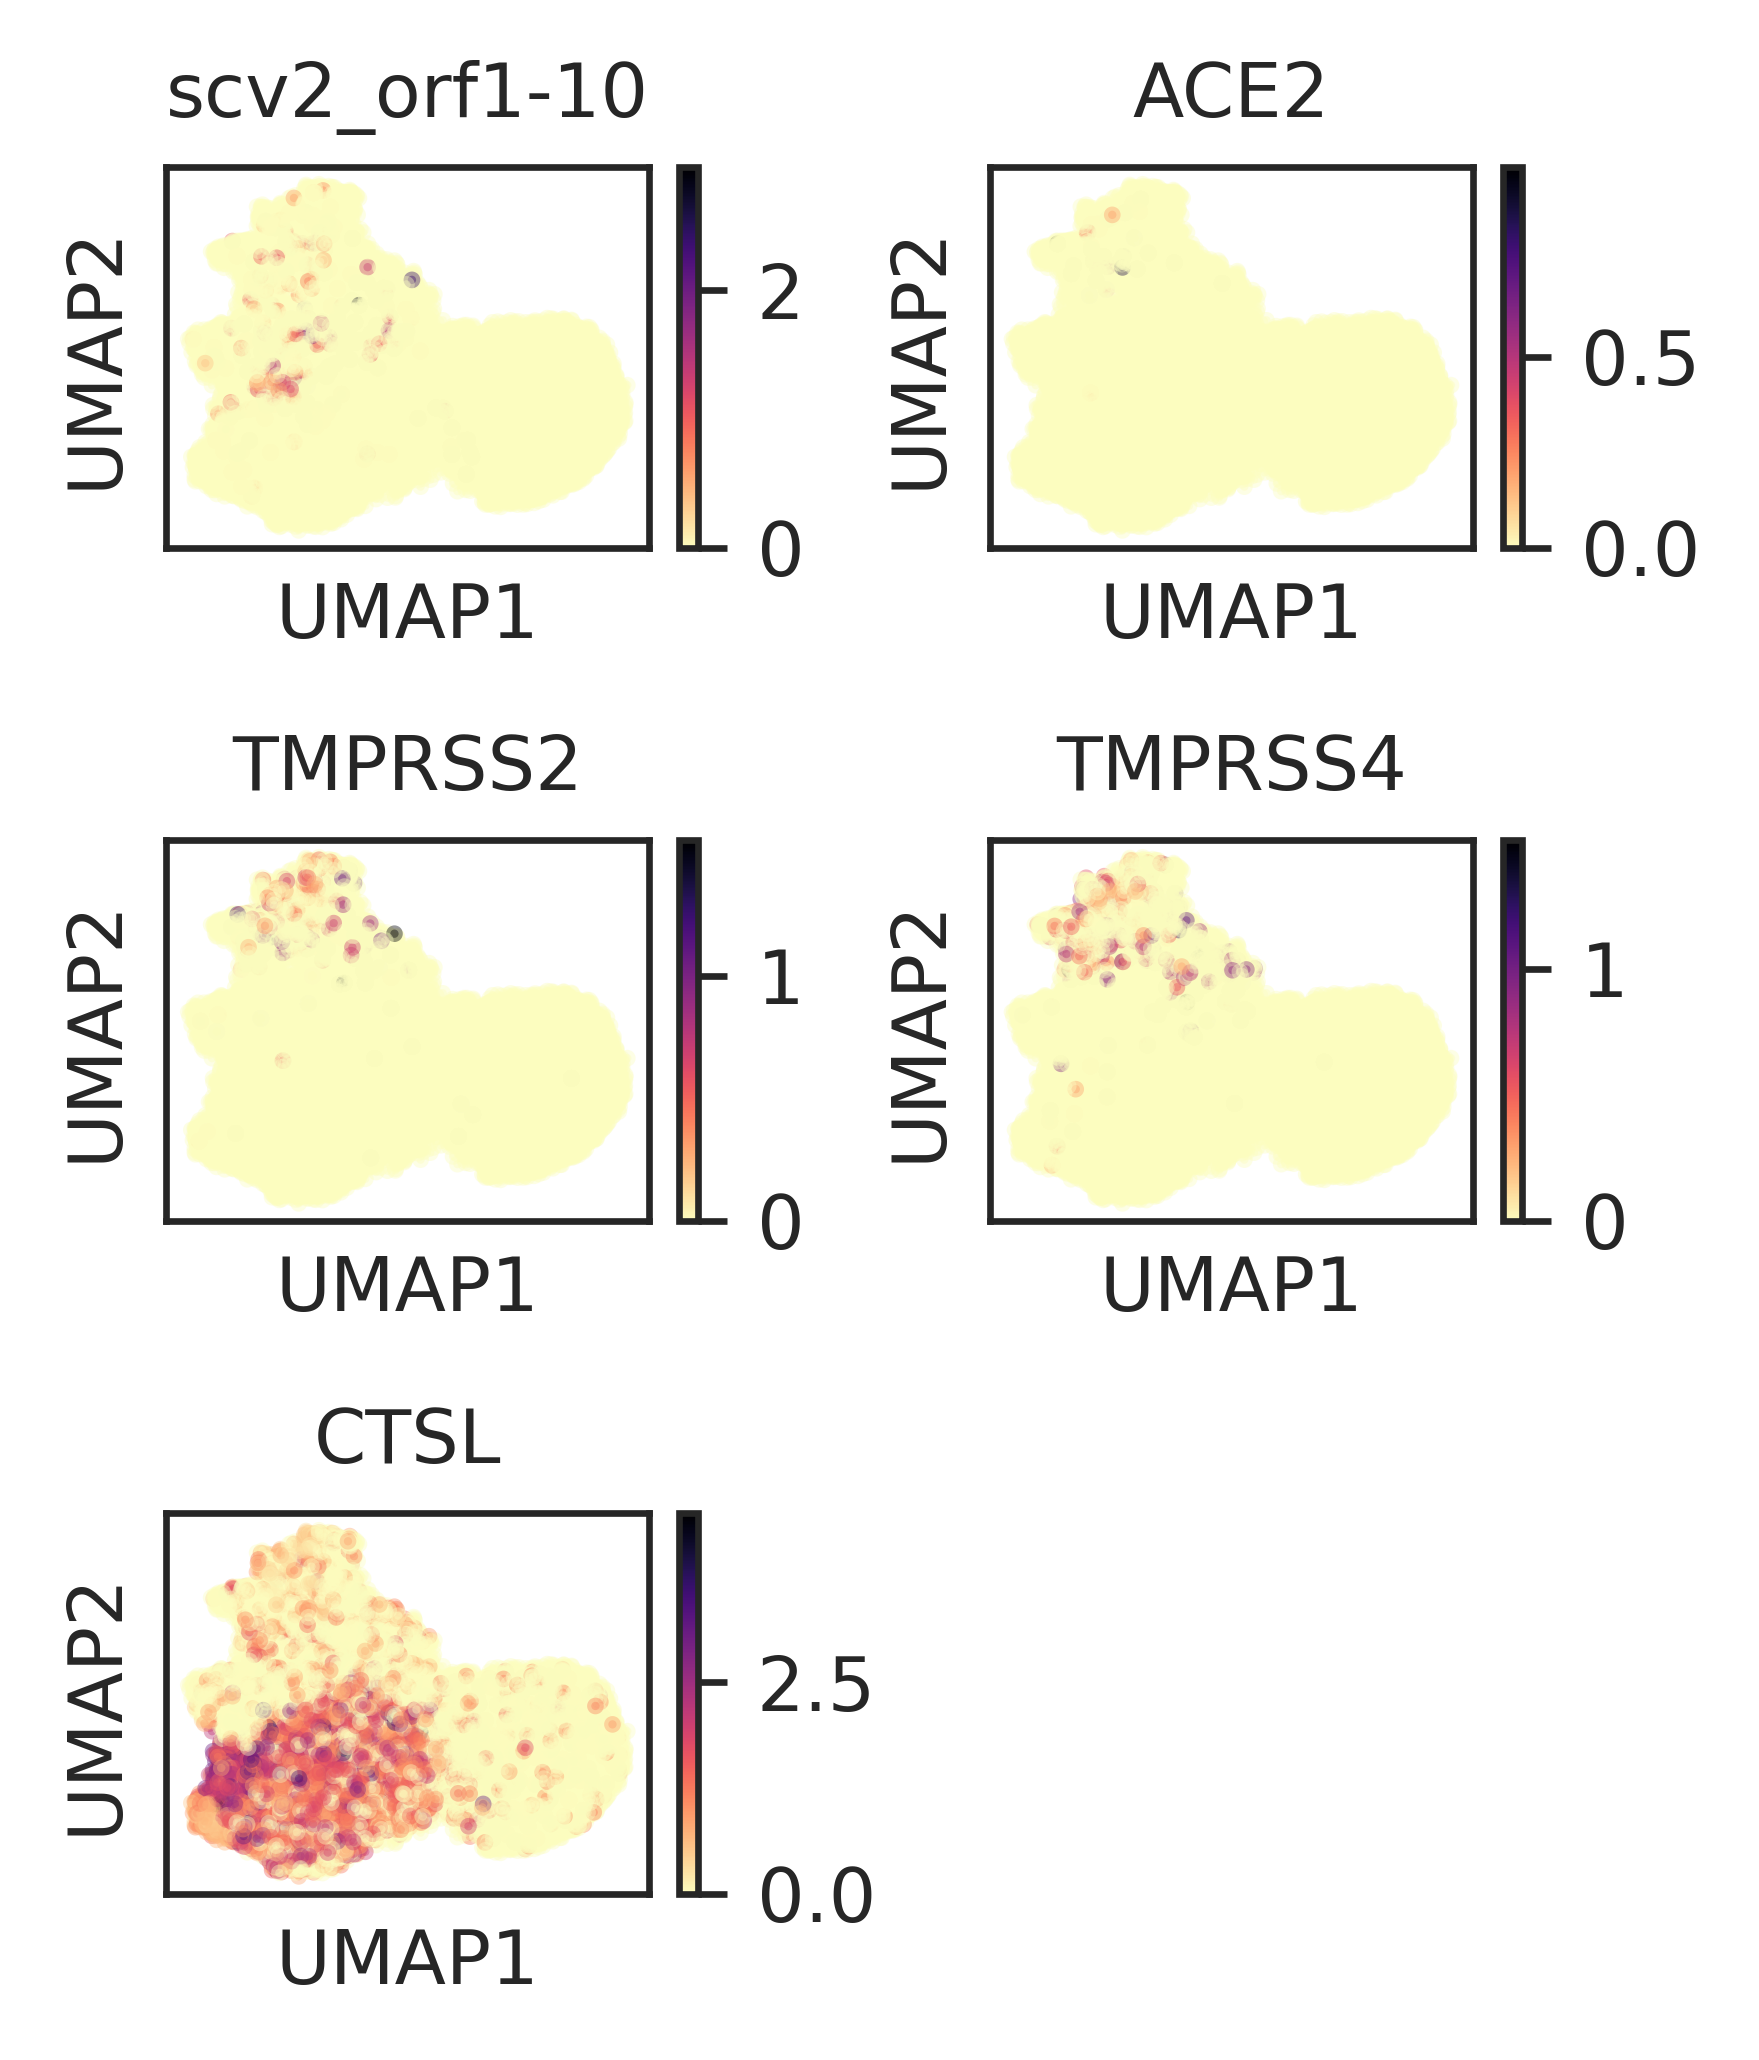

In [115]:
genes = ['scv2_orf1-10', 'ACE2', 'TMPRSS2', 'TMPRSS4','CTSL']
fig = plt.figure(figsize=(3,3.5))
for i,g in enumerate(genes):
    ax = fig.add_subplot(3,2,i+1)
    scprep.plot.scatter2d(adata.obsm['X_umap'],
                          c=np.asarray(adata[:,g].X.todense()).flatten(),
                          cmap='magma_r',
                          s=1,
                          alpha=0.4,
                        cmap_scale='linear',
                        ax=ax,
                        ticks=False,
                        xticks=None,
                        yticks=None,
                        ticklabels=True,
                        xticklabels=None,
                        yticklabels=None,
                        label_prefix='UMAP',
                        title=None,
                        legend_loc='best',
                          rasterized=True,
                          )
    ax.set_title(g)
fig.tight_layout()
fig.savefig(os.path.join(pfp,'embeds_goi.pdf'),dpi=300,bbox_inches='tight')

# Check overlap in expression

In [5]:
glob.glob(os.path.join(pfp, 'dge*.csv'))

['/home/ngr4/project/sccovid/results/dge_1dpiinfVmock_WTdown_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_2dpiinfVmock_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_3dpi_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_1dpiinfVmock_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_123dpi_infVbystander.csv',
 '/home/ngr4/project/sccovid/results/dge_2dpi_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_1dpiuninfVmock_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_123dpi_infVmock.csv',
 '/home/ngr4/project/sccovid/results/dge_2dpiinfVmock_WTdown_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_3dpiuninfVmock_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_3dpiinfVmock_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_3dpi_WTdown_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_1dpi_WTup_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_1dpi_WTdown_noimp.csv',
 '/home/ngr4/project/sccovid/results/dge_2dpi

In [40]:
x = pd.read_csv('/home/ngr4/project/sccovid/results/dge_int1Vext1_epithelial.csv')
y = pd.read_csv('/home/ngr4/project/sccovid/results/dge_123dpi_infVbystander.csv')

# select only significant ones
x = x.loc[x['pval_corrected']<=0.01,:]
y = y.loc[y['pval_corrected']<=0.01,:]
z = y.loc[y['Cell type']=='Ciliated cells',:]



In [41]:
setx = set(x['Gene'])
sety = set(y['Gene'])
setz = set(z['Gene'])

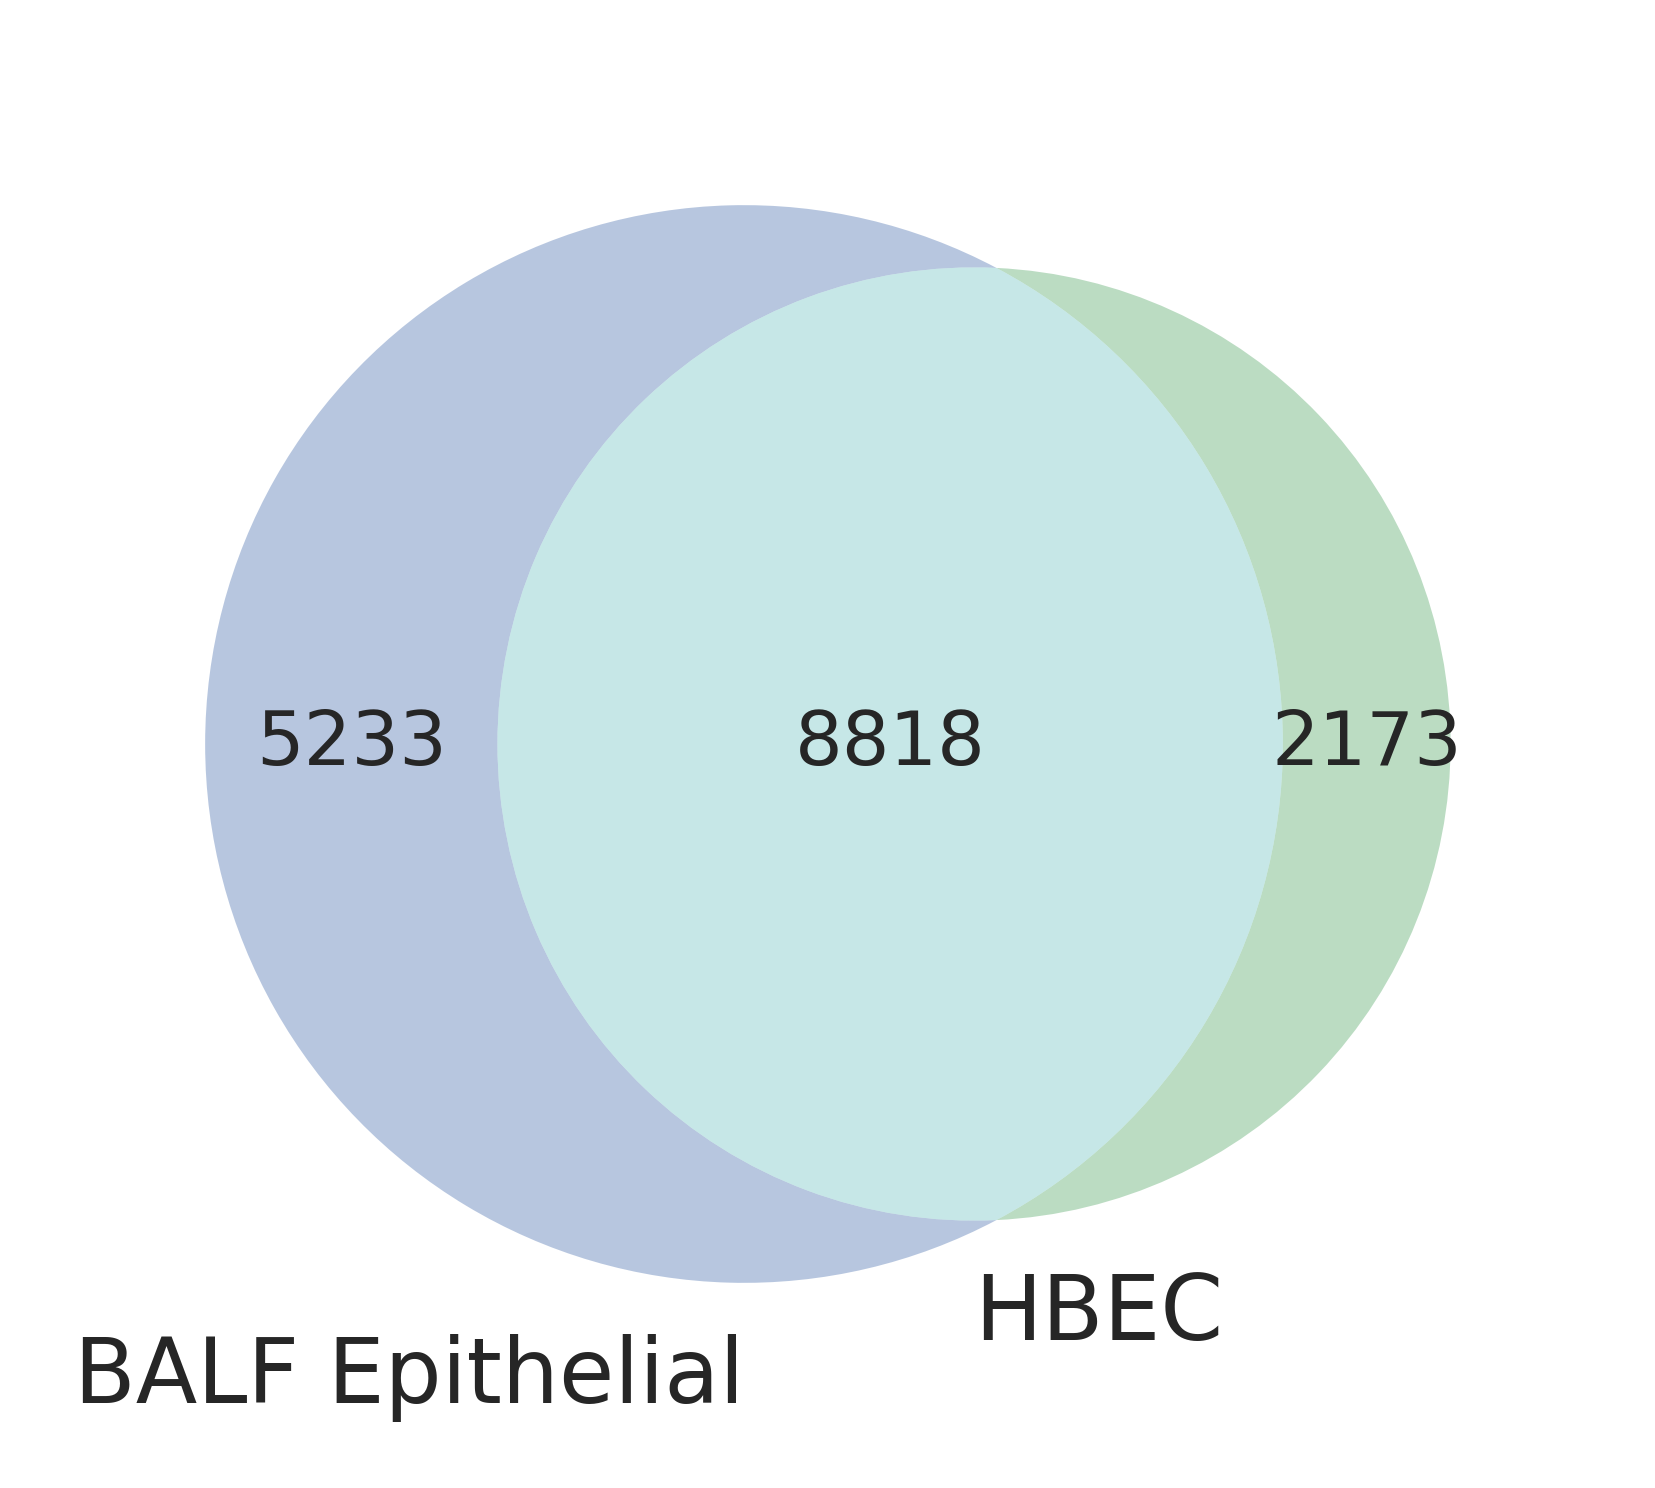

In [45]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
venn2(
    [setx, sety],
    set_labels=('BALF Epithelial', 'HBEC'),
    set_colors=(sns.color_palette('deep')[0], sns.color_palette('deep')[2]),
    alpha=0.4,
    normalize_to=0.5,
    ax=ax,
    subset_label_formatter=None,
)
if False:
    # add wee circles
    c = venn3_circles([setx, sety, setz], normalize_to=0.5)
    c[0].set_ls('dotted')
    c[1].set_ls('dashed')
fig.savefig(os.path.join(pfp,'pt_balf_hbec_dge_overlap_2.pdf'))

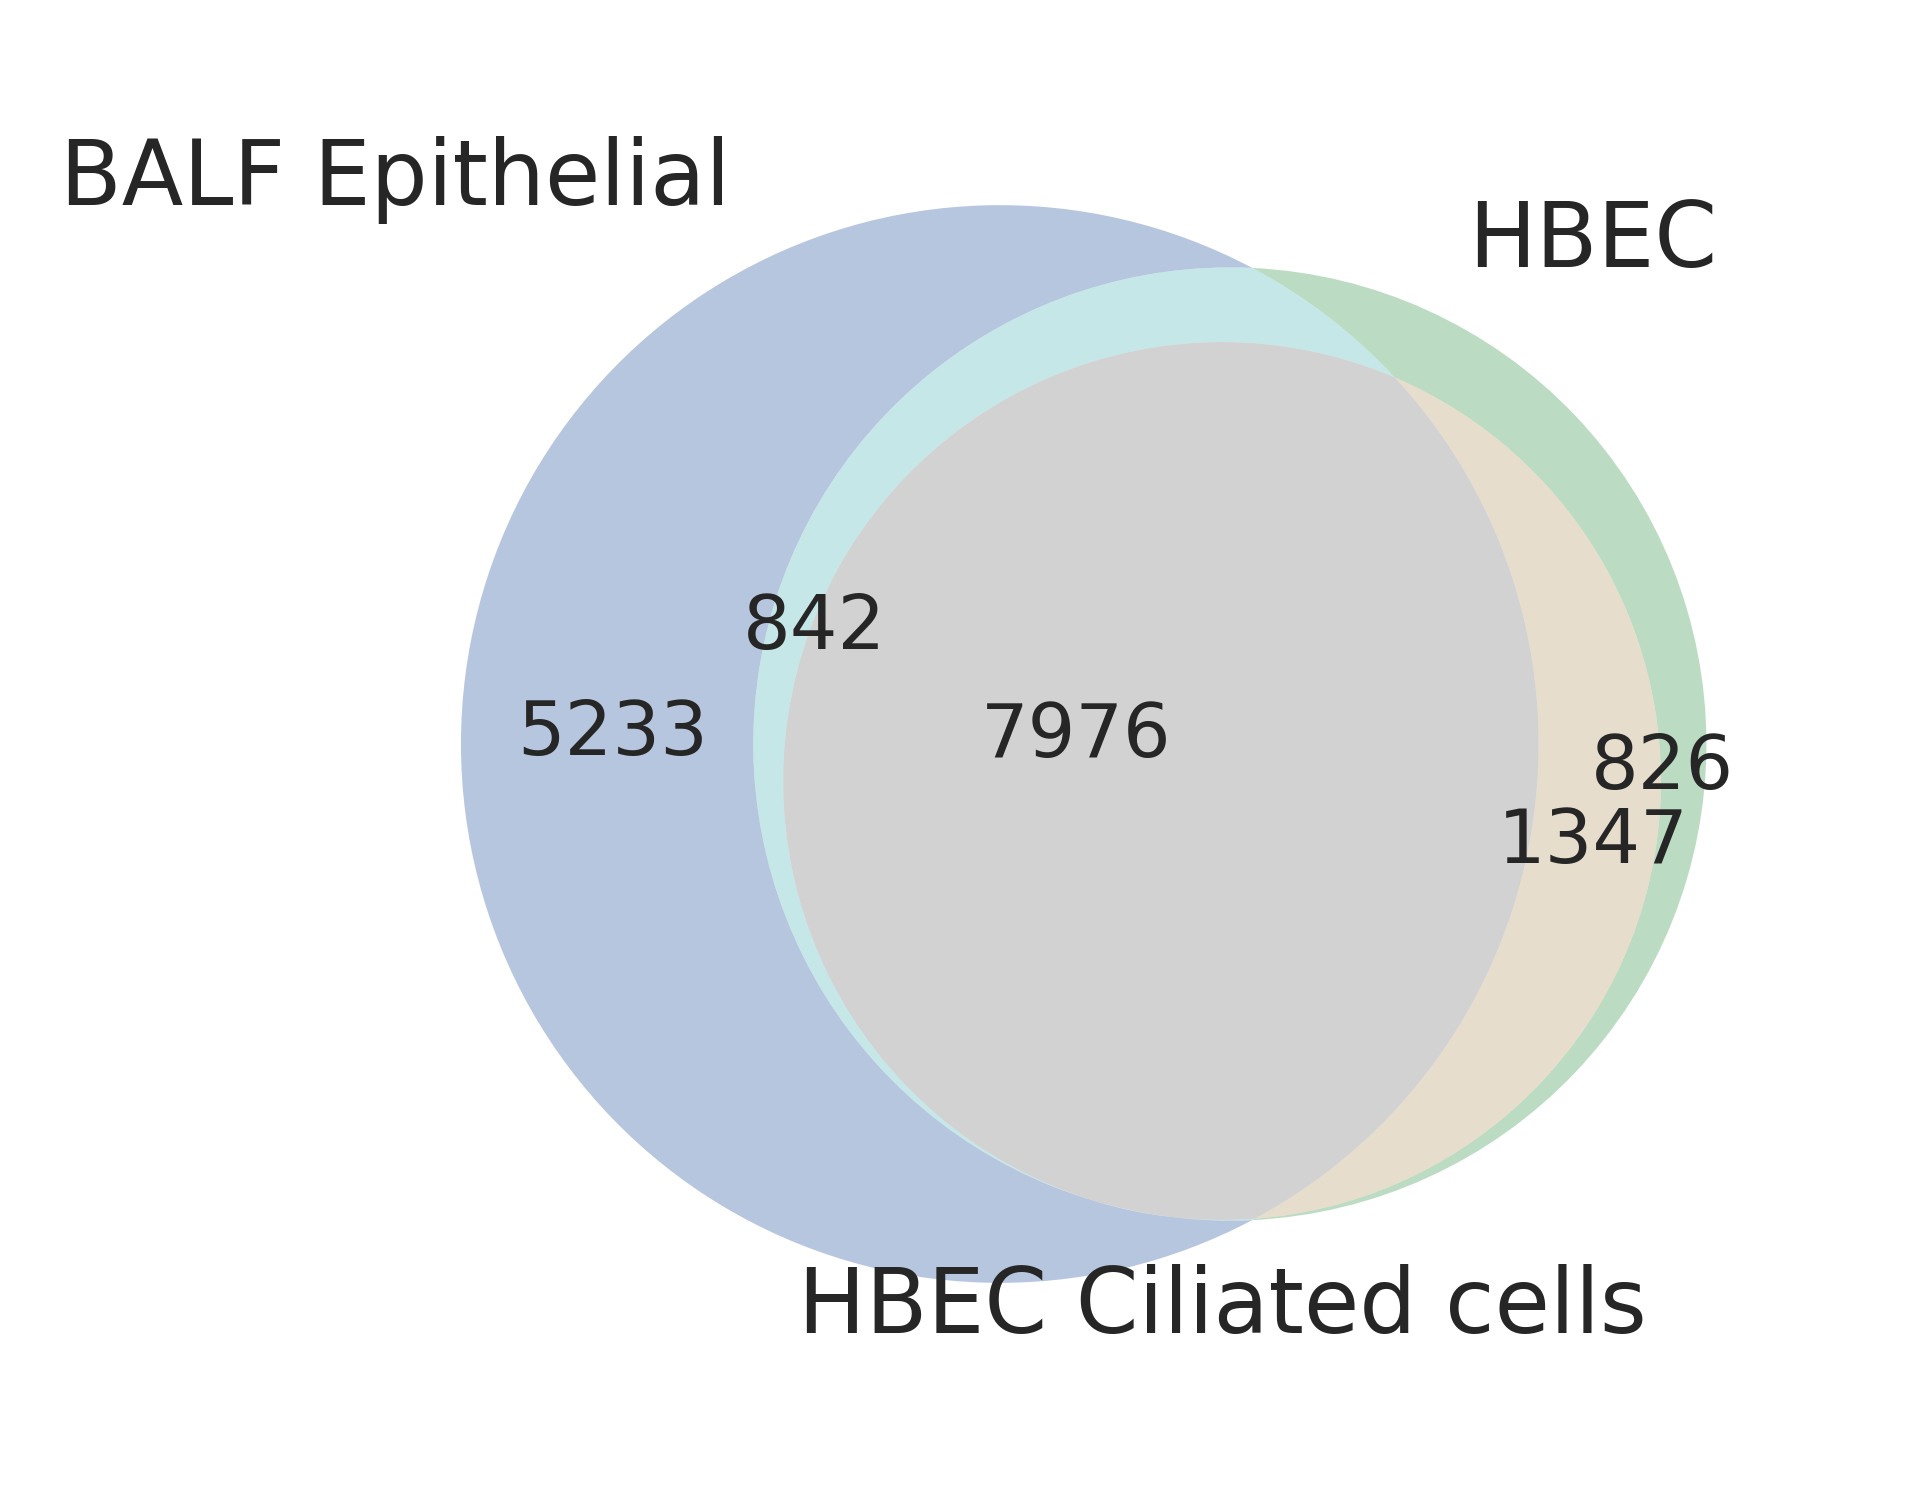

In [44]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
venn3(
    [setx, sety, setz],
    set_labels=('BALF Epithelial', 'HBEC', 'HBEC Ciliated cells'),
    set_colors=(sns.color_palette('deep')[0], sns.color_palette('deep')[2], sns.color_palette('deep')[3]),
    alpha=0.4,
    normalize_to=0.5,
    ax=ax,
    subset_label_formatter=None,
)
if False:
    # add wee circles
    c = venn3_circles([setx, sety, setz], normalize_to=0.5)
    c[0].set_ls('dotted')
    c[1].set_ls('dashed')
fig.savefig(os.path.join(pfp,'pt_balf_hbec_dge_overlap.pdf'))